In [ ]:
!pip install gym cma glfw mujoco
!pip install brax

In [ ]:
# import gym
# env = gym.make("HalfCheetah-v4")

In [ ]:
import brax
from brax import envs
import jax
import jax.numpy as jnp

#env = brax.envs.half_cheetah.Halfcheetah()
#env = brax.envs.inverted_double_pendulum.InvertedDoublePendulum()
#rng = jax.random.PRNGKey(0)

#env.reset(rng)

In [ ]:
# action_space = env.action_space
# print(action_space)

In [ ]:
import gym
import numpy as np
import torch
import brax
from brax import envs
import jax
import jax.numpy as jnp
from copy import deepcopy, copy

import warnings

# Suppress specific DeprecationWarnings related to jax.tree_map
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*jax.tree_map is deprecated.*")

class BraxToGymWrapper(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, env_name="inverted_double_pendulum"):
        super(BraxToGymWrapper, self).__init__()

        self.observation_space = None

        #env = brax.envs.inverted_double_pendulum.InvertedDoublePendulum()

        #env = brax.envs.half_cheetah.Halfcheetah()
        #self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)

        env = brax.envs.inverted_double_pendulum.InvertedDoublePendulum()
        self.action_space = gym.spaces.Box(low=-3.0, high=3.0, shape=(1,), dtype=np.float32)

        rng = jax.random.PRNGKey(0)
        s = env.reset(rng)
        self.env = env
        self.rng = jax.random.PRNGKey(0)
        self.state = s
        self.prev_state = None

        # Adjust dtype to numpy dtype for Gym compatibility
        print(f'Action space: {self.action_space}')
        #self.observation_space = gym.spaces.Box(low=-float('inf'), high=float('inf'), shape=(6,), dtype=np.float32)

    def reset(self):
        self.rng, rng_input = jax.random.split(self.rng)
        self.state = self.env.reset(rng_input)
        obs = self.concat_state(self.state)

        if self.observation_space is None:
          # Determine the size of the observation
          observation_size = obs.shape[0]
          self.observation_size = observation_size
          print(f'Setting observation size: {observation_size}')

          # Optionally, determine the range of each observation component
          # This step might require domain knowledge or further inspection of multiple observations
          self.observation_space = gym.spaces.Box(low=-float('inf'), high=float('inf'), shape=(observation_size,) , dtype=np.float32)


        return torch.from_numpy(np.array(obs, dtype=np.float32))

    def step(self, action):
        # Ensure action is a JAX array and has the correct shape and dtype
        action = jnp.array(action, dtype=jnp.float32)
        self.prev_state = self.state
        self.state = self.brax_step(self.state, action)
        obs = self.concat_state(self.state)
        # Convert JAX device arrays to NumPy arrays first
        reward = np.array(self.state.reward, dtype=np.float32)
        done = np.array(self.state.done, dtype=bool)
        # Then convert these NumPy arrays to PyTorch tensors
        return (torch.from_numpy(np.array(obs, dtype=np.float32).copy()), torch.from_numpy(reward), torch.from_numpy(done), {})

    def concat_state(self, state):
        q, qd = state.pipeline_state.q, state.pipeline_state.qd
        return jnp.concatenate((q, qd))

    def render(self, mode='human'):
        pass  # Add rendering logic if necessary

    def close(self):
        pass  # Add any necessary cleanup



    @staticmethod
    @jax.jit
    def get_jacobian(s, a):

      def qd_step(s, a):
        s_prime = benv.step(s, a)
        ps_prime = s_prime.pipeline_state
        q, qd = ps_prime.q, ps_prime.qd
        return jnp.concatenate((q, qd))

      jac_qd_step = jax.jacobian(qd_step, argnums=[0, 1])
      j_s, j_a = jac_qd_step(s, a)
      j_qd = jnp.concatenate((j_s.pipeline_state.q, j_s.pipeline_state.qd), axis=1)
      #j_a = jnp.expand_dims(j_a, axis=1)
      j = jnp.concatenate((j_qd, j_a), axis=1)
      return j

    @staticmethod
    @jax.jit
    def brax_step(s, a):
        s_prime = benv.step(s, a)
        return s_prime

    ## @staticmethod
    # @jax.jit
    # def step_and_jacobian(s, a):
    #     # Define a function that computes the next state
    #     def state_transition(s, a):
    #         s_prime = benv.step(s, a)
    #         return s_prime

    #     # Compute the next state
    #     next_state = state_transition(s, a)

    #     # Now compute the Jacobian of the state transition w.r.t. both state and action
    #     jac_fn = jax.jacobian(state_transition, argnums=(0, 1))
    #     j_s, j_a = jac_fn(s, a)

    #     # Concatenate q and qd for the current state
    #     q, qd = next_state.qp.q, next_state.qp.qd
    #     obs = jnp.concatenate((q, qd))

    #     return next_state, obs, j_s, j_a


# Initialize the environment
env = BraxToGymWrapper()
benv = env.env
# Test the environment with one step
obs = env.reset()
rng = jax.random.PRNGKey(0)

action = env.action_space.sample()
print(action)

s = copy(env.state)
new_obs, reward, done, info = env.step(action)
print("Observation:", new_obs)
print("Reward:", reward)
print("Done:", done)
print("Info:", info)
print("Actiom:", action)

s = env.state
print('curr state')
print(s)

j = env.get_jacobian(s, action)
print(j)





In [ ]:
def rolloutBraxEnv(env, num_steps=100):
    states = []
    actions = []
    jacobians = []
    next_states = []
    obs = env.reset()
    states.append(obs)  # Initial state
    print("Initial observation captured")

    for i in range(num_steps):
        action = env.action_space.sample()  # Sample a random action
        new_obs, reward, done, _ = env.step(action)  # Take a step in the environment

        actions.append(action)  # Append the action taken
        next_states.append(new_obs)  # Append the next state
        print(f"Step {i}: Action taken and next state observed")

        # Get Jacobian
        j = env.get_jacobian(env.prev_state, action)
        jacobians.append(j)
        print(f"Step {i}: Jacobian calculated")

        if done:
            print('Environment reset due to done flag')
            obs = env.reset()  # Reset environment and start a new episode
            states.append(obs)  # Append the new initial state after reset
        else:
            states.append(new_obs)  # Append the new state if not done

    # Assert and warn for any inconsistencies before popping the last state
    if len(states) != len(next_states) + 1:
        warnings.warn(
            f"Expected states and next_states to differ by 1, got {len(states)} and {len(next_states)}",
            RuntimeWarning
        )

    # Remove the last state since it doesn't have a corresponding next state
    states.pop()
    states = np.array(states)
    actions = np.array(actions)
    jacobians = np.array(jacobians)
    next_states = np.array(next_states)
    print("Shape of states:", states.shape)
    print("Shape of actions:", actions.shape)
    print("Shape of jacobians:", jacobians.shape)
    print("Shape of next_states:", next_states.shape)
    return states, actions, jacobians, next_states



states, actions, jacobians, next_states = rolloutBraxEnv(env, num_steps=3000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
import os
def ensure_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
    print(f"Directory checked/created at: {path}")

    # Define the path for data storage
data_path = '/content/drive/MyDrive/WorldModel/data-half-cheetah/'

# Ensure the directory exists
ensure_directory(data_path)


Directory checked/created at: /content/drive/MyDrive/WorldModel/data-half-cheetah/


In [ ]:
import pickle

def save_simulation_data(data, folder_path, file_name='simulation_data.pkl'):
    """
    Saves the simulation data to a specified folder in Google Drive.

    Parameters:
    - data (tuple): Tuple containing states, actions, jacobians, next_states.
    - folder_path (str): The folder path where the data will be saved.
    - file_name (str): The name of the file to save the data.
    """
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)
    print(f"Data saved successfully to {file_path}")

def load_simulation_data(folder_path, file_name='simulation_data.pkl'):
    """
    Loads the simulation data from a specified folder in Google Drive.

    Parameters:
    - folder_path (str): The folder path from which the data will be loaded.
    - file_name (str): The name of the file from which to load the data.

    Returns:
    - tuple: Tuple containing states, actions, jacobians, next_states.
    """
    file_path = os.path.join(folder_path, file_name)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No file found at {file_path}")

    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return data


# Save the data to a file

# Save the data
#save_simulation_data((states, actions, jacobians, next_states), data_path)

# Later, load the data
#states, actions, jacobians, next_states = load_simulation_data(data_path)

Data loaded successfully from /content/drive/MyDrive/WorldModel/data-half-cheetah/simulation_data.pkl


In [6]:
states = np.array(states)
actions = np.array(actions)
jacobians = np.array(jacobians)
next_states = np.array(next_states)

print("Shape of states:", states.shape)
print("Shape of actions:", actions.shape)
print("Shape of jacobians:", jacobians.shape)
print("Shape of next_states:", next_states.shape)

Shape of states: (300, 6)
Shape of actions: (300, 1)
Shape of jacobians: (300, 6, 7)
Shape of next_states: (300, 6)


## FCN Half-Cheetah Experiments

In [ ]:
import matplotlib.pyplot as plt

def plot_jacobians(jacobians):
    # Calculate the number of subplots needed
    num_jacobians = len(jacobians)
    cols = 4  # You can adjust this number based on your display preferences
    rows = (num_jacobians + cols - 1) // cols  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    for i, ax in enumerate(axes.flatten()):
        if i < num_jacobians:
            im = ax.imshow(jacobians[i], aspect='auto', interpolation='none', cmap='viridis')
            ax.set_title(f'Jacobian {i + 1}')
            fig.colorbar(im, ax=ax)
        ax.axis('off')  # Turn off axis if no data
    plt.tight_layout()
    plt.show()
plot_jacobians(jacobians[:10])

In [ ]:
def rolloutBraxEnv(env, num_trajectories=10, num_steps=100):
    all_states = []
    all_actions = []
    all_jacobians = []
    all_next_states = []

    for traj in range(num_trajectories):
        states = []
        actions = []
        jacobians = []
        next_states = []

        obs = env.reset()
        states.append(obs)  # Initial state
        print(f"Trajectory {traj}: Initial observation captured")

        for i in range(num_steps):
            action = env.action_space.sample()  # Sample a random action
            new_obs, reward, done, _ = env.step(action)  # Take a step in the environment
            actions.append(action)  # Append the action taken
            next_states.append(new_obs)  # Append the next state
            print(f"Trajectory {traj}, Step {i}: Action taken and next state observed")

            # Get Jacobian
            j = env.get_jacobian(env.prev_state, action)
            jacobians.append(j)
            print(f"Trajectory {traj}, Step {i}: Jacobian calculated")

            if done:
                print(f'Trajectory {traj}: Environment reset due to done flag')
                break
            else:
                states.append(new_obs)  # Append the new state if not done

        # Remove the last state since it doesn't have a corresponding next state
        states.pop()

        all_states.append(np.array(states))
        all_actions.append(np.array(actions))
        all_jacobians.append(np.array(jacobians))
        all_next_states.append(np.array(next_states))

    print("Shape of all_states:", [s.shape for s in all_states])
    print("Shape of all_actions:", [a.shape for a in all_actions])
    print("Shape of all_jacobians:", [j.shape for j in all_jacobians])
    print("Shape of all_next_states:", [ns.shape for ns in all_next_states])

    return all_states, all_actions, all_jacobians, all_next_states

all_states, all_actions, all_jacobians, all_next_states = rolloutBraxEnv(env, num_trajectories=10, num_steps=100)


In [42]:
# Print shapes of all collected data at the end
print("Shape of all_states:", [s.shape for s in all_states])
print("Shape of all_actions:", [a.shape for a in all_actions])
print("Shape of all_jacobians:", [j.shape for j in all_jacobians])
print("Shape of all_next_states:", [ns.shape for ns in all_next_states])


Shape of all_states: [(9, 6), (13, 6), (36, 6), (12, 6), (11, 6), (21, 6), (31, 6), (22, 6), (16, 6), (11, 6)]
Shape of all_actions: [(10, 1), (14, 1), (37, 1), (13, 1), (12, 1), (22, 1), (32, 1), (23, 1), (17, 1), (12, 1)]
Shape of all_jacobians: [(10, 6, 7), (14, 6, 7), (37, 6, 7), (13, 6, 7), (12, 6, 7), (22, 6, 7), (32, 6, 7), (23, 6, 7), (17, 6, 7), (12, 6, 7)]
Shape of all_next_states: [(10, 6), (14, 6), (37, 6), (13, 6), (12, 6), (22, 6), (32, 6), (23, 6), (17, 6), (12, 6)]


In [18]:
import torch
device = 'cuda'
states_tensor = torch.from_numpy(states).float().to(device)
actions_tensor = torch.from_numpy(actions).float().to(device)
jacobians_tensor = torch.from_numpy(jacobians).float().to(device)
next_states_tensor = torch.from_numpy(next_states).float().to(device)

In [19]:
# print("Shape of states_np:", states_np.shape)
# print("Shape of actions_np:", actions_np.shape)
# print("Shape of jacobians_np:", jacobians_np.shape)

print("Shape of states_tensor:", states_tensor.shape)
print("Shape of actions_tensor:", actions_tensor.shape)
print("Shape of jacobians_tensor:", jacobians_tensor.shape)
print("Shape of next_states_tensor:", next_states_tensor.shape)

Shape of states_tensor: torch.Size([3000, 6])
Shape of actions_tensor: torch.Size([3000, 1])
Shape of jacobians_tensor: torch.Size([3000, 6, 7])
Shape of next_states_tensor: torch.Size([3000, 6])


In [ ]:
# import gc

# # Assuming 'env' is your Brax environment
# del env
# gc.collect()


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

CUDA cache cleared


In [ ]:
if torch.cuda.is_available():
    torch.cuda.reset_accumulated_memory_stats()  # Reset accumulated memory stats
    torch.cuda.reset_peak_memory_stats()  # Reset peak memory stats

    # Resets the current device, releasing all memory allocated on the GPU
    torch.cuda.reset_max_memory_allocated()  # Resets only the tracked max memory

    # If you need a full reset of all devices (caution: this will impact all CUDA applications)
    torch.cuda.synchronize()
    torch.cuda.ipc_collect()  # clear any used shared-memory blocks
    for i in range(torch.cuda.device_count()):
        torch.cuda.device(i)
        torch.cuda.reset_peak_memory_stats()
    print("All CUDA devices have been reset")

All CUDA devices have been reset


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [65]:
s = states_tensor[:5]
a = actions_tensor[:5]
# Add batch dimension:
# s = states_tensor[0].unsqueeze(0)
# a = actions_tensor[0].unsqueeze(0)
print(s.shape)
print(a.shape)
s = s.requires_grad_(True).to(device)
a = a.requires_grad_(True).to(device)

def model_outputs(s, a):
    return model(s, a)

model = NextStatePredictor(state_dim, action_dim).to(device)

# Compute the Jacobian using the correct function signature
model_jacobian = torch.autograd.functional.jacobian(model_outputs, (s, a), vectorize=True, create_graph=True)

torch.Size([5, 6])
torch.Size([5, 1])


In [66]:
model_jacobian = torch.cat((model_jacobian[0], model_jacobian[1]), dim=3)

print(model_jacobian.shape)

torch.Size([5, 6, 5, 7])


In [75]:
model_jacobian[2, :, 2, :]

tensor([[-0.1355,  0.0550, -0.0098,  0.0075, -0.2245,  0.0276,  0.0661],
        [-0.1410,  0.0774,  0.1215,  0.0191,  0.0151,  0.0220, -0.0855],
        [-0.1163, -0.0816,  0.0834,  0.0834, -0.0241, -0.0416, -0.0692],
        [ 0.0891,  0.1052,  0.0338,  0.0116,  0.0743, -0.0973, -0.0287],
        [-0.1190, -0.0033,  0.0773, -0.0116,  0.0584,  0.0032,  0.0714],
        [ 0.0003,  0.1578, -0.0423,  0.0458, -0.0096, -0.2124,  0.1303]],
       device='cuda:0', grad_fn=<SliceBackward0>)

Training alignment model...
Epoch 1/200 complete: Avg Prediction Loss = 5.2186, Avg Alignment Loss = 0.0531, Total Batches Processed = 47
Plotting the Jacobians During Training
States shape: torch.Size([3, 6])
Actions shape: torch.Size([3, 1])
Jacobians shape: torch.Size([3, 6, 7])
nn_jacobian shape: torch.Size([3, 6, 3, 7])
jacobians shape: torch.Size([3, 6, 7])


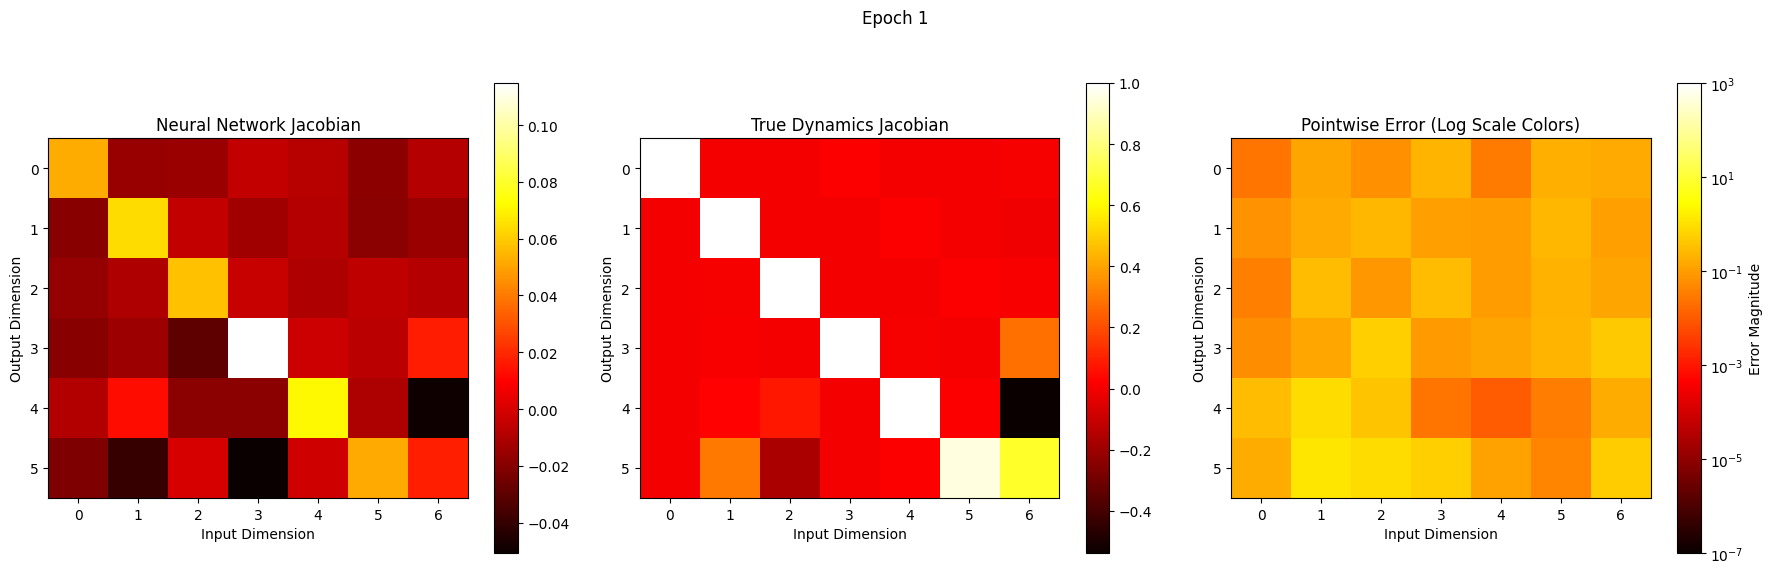

Epoch 2/200 complete: Avg Prediction Loss = 4.4718, Avg Alignment Loss = 0.0387, Total Batches Processed = 47
Epoch 3/200 complete: Avg Prediction Loss = 4.3669, Avg Alignment Loss = 0.0387, Total Batches Processed = 47
Epoch 4/200 complete: Avg Prediction Loss = 4.2363, Avg Alignment Loss = 0.0345, Total Batches Processed = 47
Epoch 5/200 complete: Avg Prediction Loss = 4.2321, Avg Alignment Loss = 0.0347, Total Batches Processed = 47
Epoch 6/200 complete: Avg Prediction Loss = 4.1753, Avg Alignment Loss = 0.0364, Total Batches Processed = 47
Epoch 7/200 complete: Avg Prediction Loss = 4.0725, Avg Alignment Loss = 0.0322, Total Batches Processed = 47
Epoch 8/200 complete: Avg Prediction Loss = 4.0440, Avg Alignment Loss = 0.0301, Total Batches Processed = 47
Epoch 9/200 complete: Avg Prediction Loss = 4.1094, Avg Alignment Loss = 0.0330, Total Batches Processed = 47
Epoch 10/200 complete: Avg Prediction Loss = 3.9789, Avg Alignment Loss = 0.0338, Total Batches Processed = 47
Epoch 11/

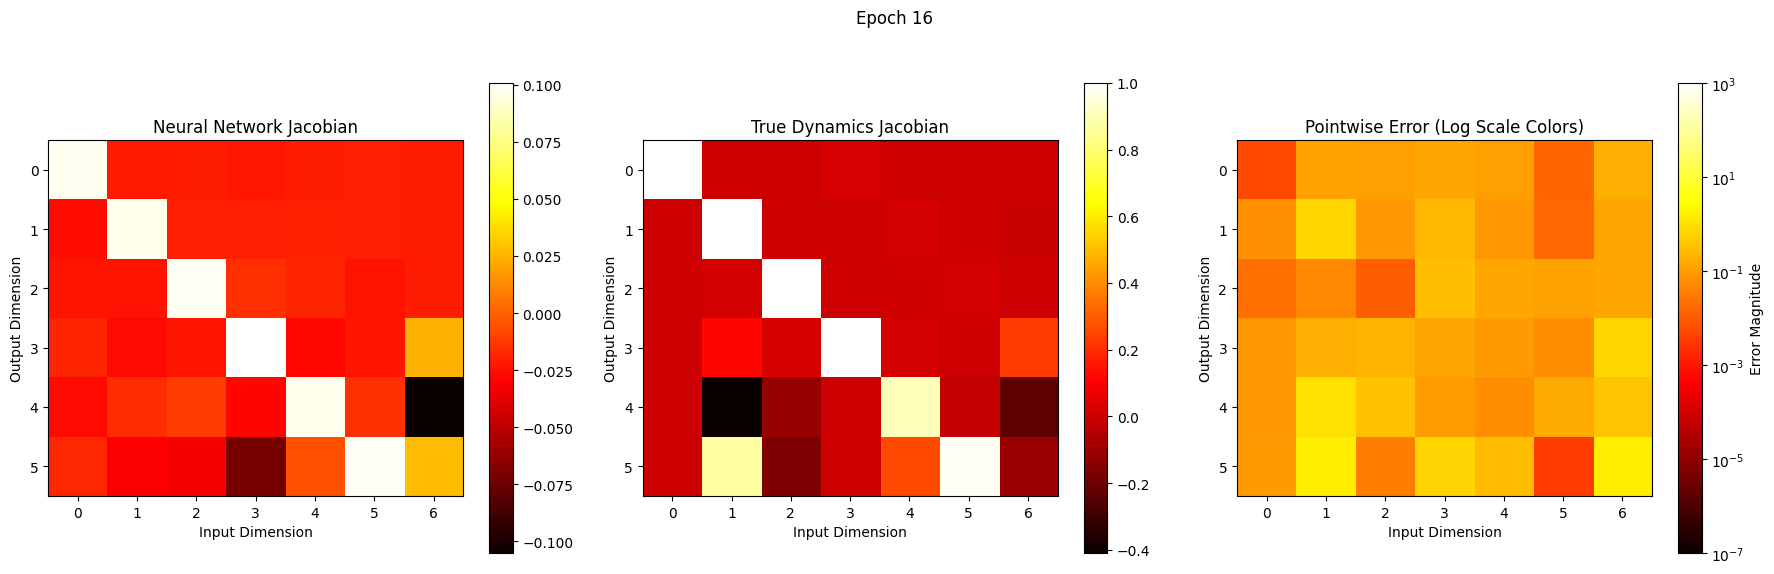

Epoch 17/200 complete: Avg Prediction Loss = 3.0271, Avg Alignment Loss = 0.0288, Total Batches Processed = 47
Epoch 18/200 complete: Avg Prediction Loss = 2.9895, Avg Alignment Loss = 0.0331, Total Batches Processed = 47
Epoch 19/200 complete: Avg Prediction Loss = 2.8360, Avg Alignment Loss = 0.0277, Total Batches Processed = 47
Epoch 20/200 complete: Avg Prediction Loss = 2.8329, Avg Alignment Loss = 0.0264, Total Batches Processed = 47
Epoch 21/200 complete: Avg Prediction Loss = 2.7012, Avg Alignment Loss = 0.0302, Total Batches Processed = 47
Epoch 22/200 complete: Avg Prediction Loss = 2.5454, Avg Alignment Loss = 0.0281, Total Batches Processed = 47
Epoch 23/200 complete: Avg Prediction Loss = 2.5718, Avg Alignment Loss = 0.0260, Total Batches Processed = 47
Epoch 24/200 complete: Avg Prediction Loss = 2.5271, Avg Alignment Loss = 0.0274, Total Batches Processed = 47
Epoch 25/200 complete: Avg Prediction Loss = 2.5755, Avg Alignment Loss = 0.0261, Total Batches Processed = 47
E

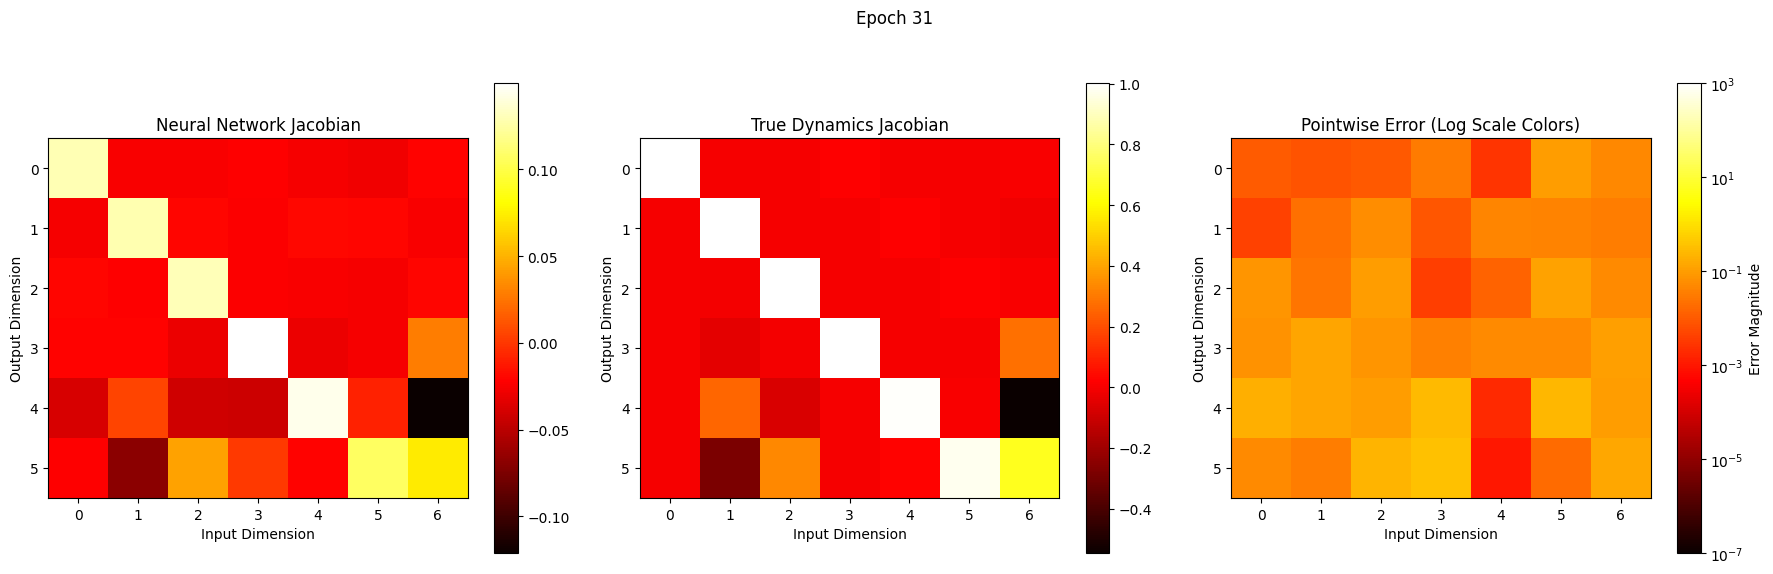

Epoch 32/200 complete: Avg Prediction Loss = 2.2934, Avg Alignment Loss = 0.0235, Total Batches Processed = 47
Epoch 33/200 complete: Avg Prediction Loss = 2.1688, Avg Alignment Loss = 0.0251, Total Batches Processed = 47
Epoch 34/200 complete: Avg Prediction Loss = 2.1828, Avg Alignment Loss = 0.0259, Total Batches Processed = 47
Epoch 35/200 complete: Avg Prediction Loss = 2.2318, Avg Alignment Loss = 0.0269, Total Batches Processed = 47
Epoch 36/200 complete: Avg Prediction Loss = 2.0803, Avg Alignment Loss = 0.0255, Total Batches Processed = 47
Epoch 37/200 complete: Avg Prediction Loss = 2.0602, Avg Alignment Loss = 0.0240, Total Batches Processed = 47
Epoch 38/200 complete: Avg Prediction Loss = 2.1780, Avg Alignment Loss = 0.0220, Total Batches Processed = 47
Epoch 39/200 complete: Avg Prediction Loss = 2.1018, Avg Alignment Loss = 0.0236, Total Batches Processed = 47
Epoch 40/200 complete: Avg Prediction Loss = 2.0433, Avg Alignment Loss = 0.0235, Total Batches Processed = 47
E

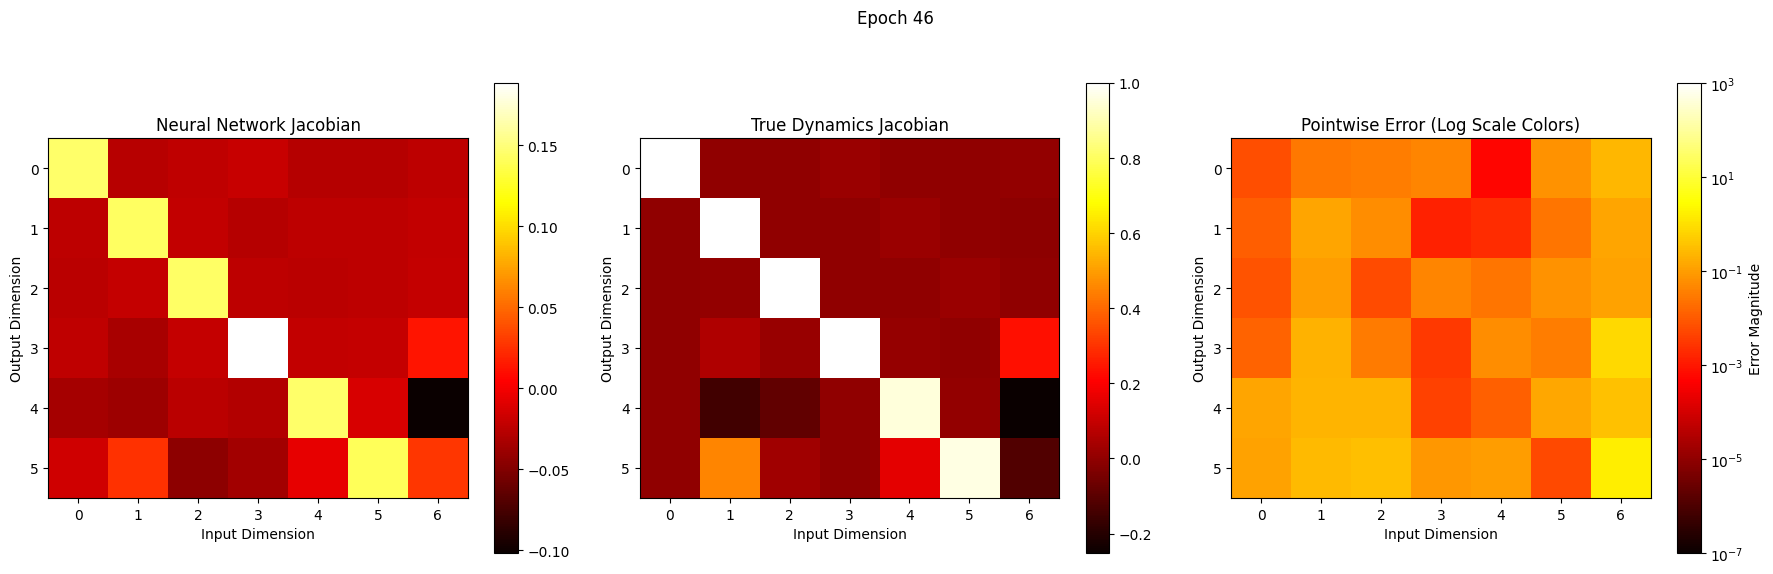

Epoch 47/200 complete: Avg Prediction Loss = 1.9768, Avg Alignment Loss = 0.0230, Total Batches Processed = 47
Epoch 48/200 complete: Avg Prediction Loss = 1.8801, Avg Alignment Loss = 0.0268, Total Batches Processed = 47
Epoch 49/200 complete: Avg Prediction Loss = 1.7606, Avg Alignment Loss = 0.0237, Total Batches Processed = 47
Epoch 50/200 complete: Avg Prediction Loss = 1.7923, Avg Alignment Loss = 0.0235, Total Batches Processed = 47
Epoch 51/200 complete: Avg Prediction Loss = 1.7874, Avg Alignment Loss = 0.0246, Total Batches Processed = 47
Epoch 52/200 complete: Avg Prediction Loss = 1.7405, Avg Alignment Loss = 0.0221, Total Batches Processed = 47
Epoch 53/200 complete: Avg Prediction Loss = 1.8616, Avg Alignment Loss = 0.0234, Total Batches Processed = 47
Epoch 54/200 complete: Avg Prediction Loss = 1.6571, Avg Alignment Loss = 0.0251, Total Batches Processed = 47
Epoch 55/200 complete: Avg Prediction Loss = 1.7383, Avg Alignment Loss = 0.0189, Total Batches Processed = 47
E

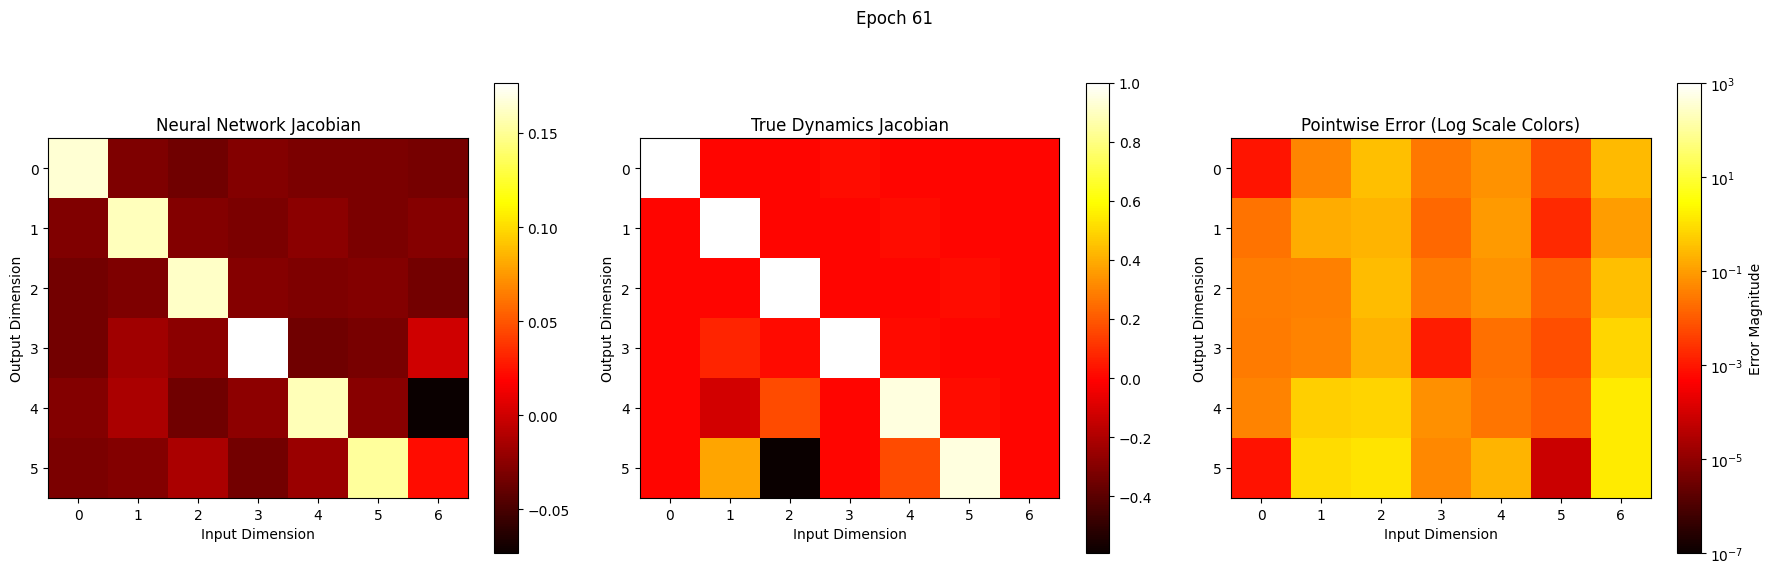

Epoch 62/200 complete: Avg Prediction Loss = 1.6084, Avg Alignment Loss = 0.0220, Total Batches Processed = 47
Epoch 63/200 complete: Avg Prediction Loss = 1.6266, Avg Alignment Loss = 0.0220, Total Batches Processed = 47
Epoch 64/200 complete: Avg Prediction Loss = 1.7030, Avg Alignment Loss = 0.0219, Total Batches Processed = 47
Epoch 65/200 complete: Avg Prediction Loss = 1.5095, Avg Alignment Loss = 0.0206, Total Batches Processed = 47
Epoch 66/200 complete: Avg Prediction Loss = 1.6621, Avg Alignment Loss = 0.0251, Total Batches Processed = 47
Epoch 67/200 complete: Avg Prediction Loss = 1.5466, Avg Alignment Loss = 0.0196, Total Batches Processed = 47
Epoch 68/200 complete: Avg Prediction Loss = 1.4527, Avg Alignment Loss = 0.0184, Total Batches Processed = 47
Epoch 69/200 complete: Avg Prediction Loss = 1.5194, Avg Alignment Loss = 0.0213, Total Batches Processed = 47
Epoch 70/200 complete: Avg Prediction Loss = 1.4795, Avg Alignment Loss = 0.0196, Total Batches Processed = 47
E

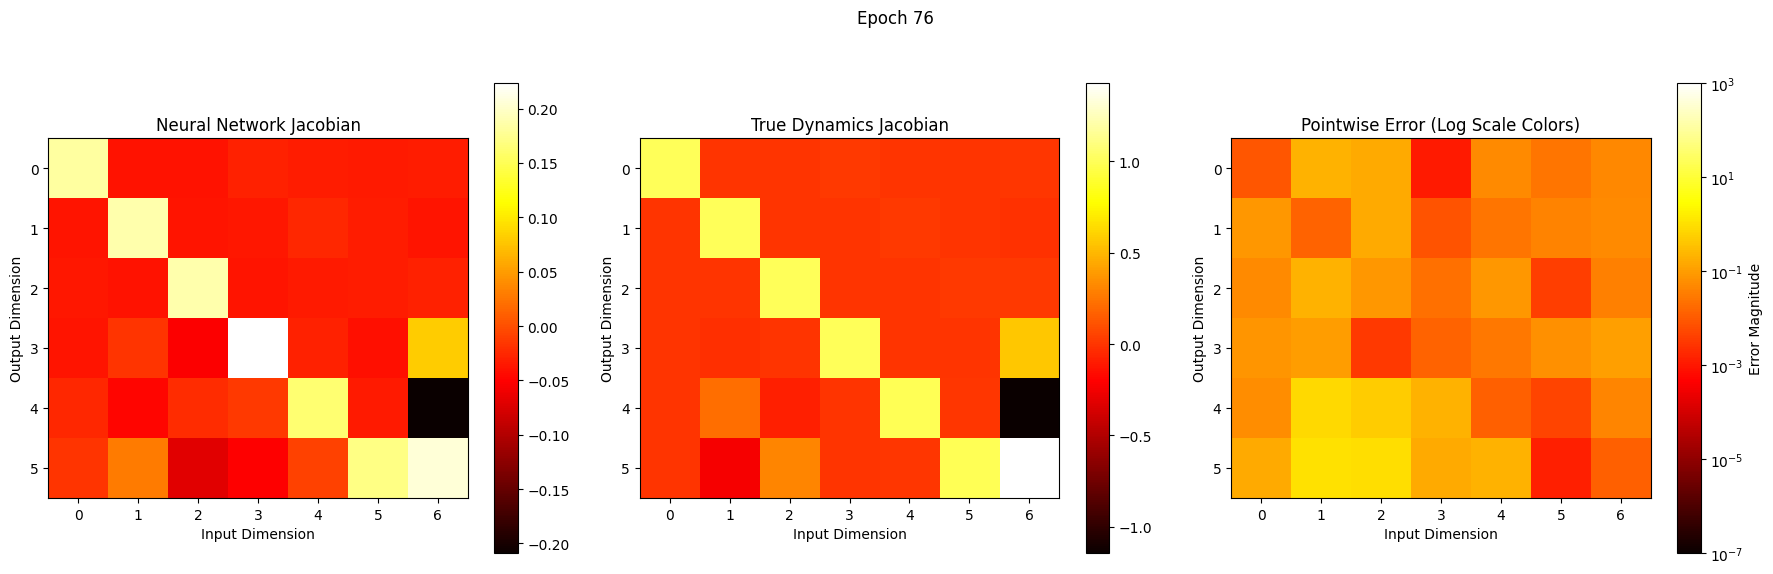

Epoch 77/200 complete: Avg Prediction Loss = 1.3202, Avg Alignment Loss = 0.0204, Total Batches Processed = 47
Epoch 78/200 complete: Avg Prediction Loss = 1.4324, Avg Alignment Loss = 0.0209, Total Batches Processed = 47
Epoch 79/200 complete: Avg Prediction Loss = 1.3943, Avg Alignment Loss = 0.0215, Total Batches Processed = 47
Epoch 80/200 complete: Avg Prediction Loss = 1.3338, Avg Alignment Loss = 0.0225, Total Batches Processed = 47
Epoch 81/200 complete: Avg Prediction Loss = 1.2402, Avg Alignment Loss = 0.0198, Total Batches Processed = 47
Epoch 82/200 complete: Avg Prediction Loss = 1.3581, Avg Alignment Loss = 0.0224, Total Batches Processed = 47
Epoch 83/200 complete: Avg Prediction Loss = 1.2634, Avg Alignment Loss = 0.0213, Total Batches Processed = 47
Epoch 84/200 complete: Avg Prediction Loss = 1.2316, Avg Alignment Loss = 0.0195, Total Batches Processed = 47
Epoch 85/200 complete: Avg Prediction Loss = 1.3102, Avg Alignment Loss = 0.0219, Total Batches Processed = 47
E

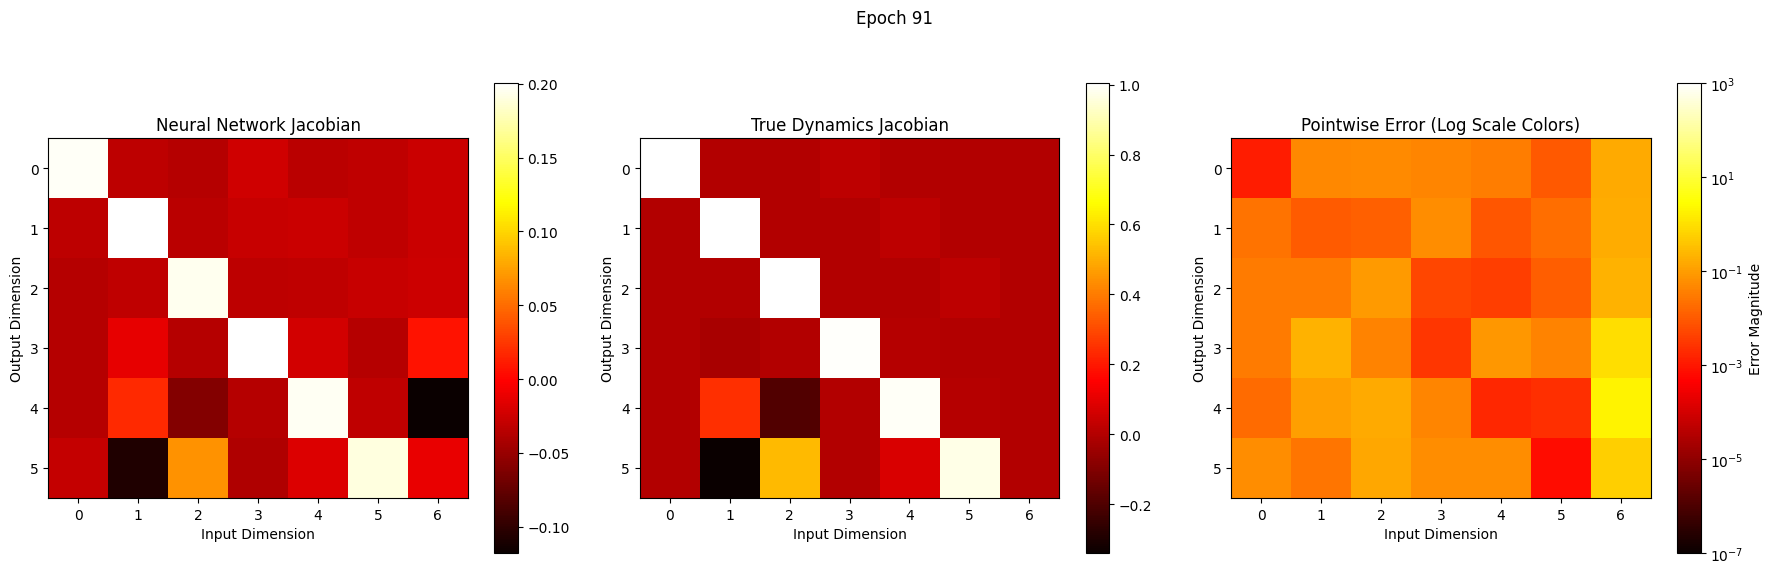

Epoch 92/200 complete: Avg Prediction Loss = 1.1455, Avg Alignment Loss = 0.0191, Total Batches Processed = 47
Epoch 93/200 complete: Avg Prediction Loss = 1.1256, Avg Alignment Loss = 0.0186, Total Batches Processed = 47
Epoch 94/200 complete: Avg Prediction Loss = 1.1689, Avg Alignment Loss = 0.0207, Total Batches Processed = 47
Epoch 95/200 complete: Avg Prediction Loss = 1.0950, Avg Alignment Loss = 0.0213, Total Batches Processed = 47
Epoch 96/200 complete: Avg Prediction Loss = 1.1099, Avg Alignment Loss = 0.0211, Total Batches Processed = 47
Epoch 97/200 complete: Avg Prediction Loss = 1.1569, Avg Alignment Loss = 0.0224, Total Batches Processed = 47
Epoch 98/200 complete: Avg Prediction Loss = 1.1866, Avg Alignment Loss = 0.0230, Total Batches Processed = 47
Epoch 99/200 complete: Avg Prediction Loss = 1.1870, Avg Alignment Loss = 0.0205, Total Batches Processed = 47
Epoch 100/200 complete: Avg Prediction Loss = 1.1939, Avg Alignment Loss = 0.0214, Total Batches Processed = 47


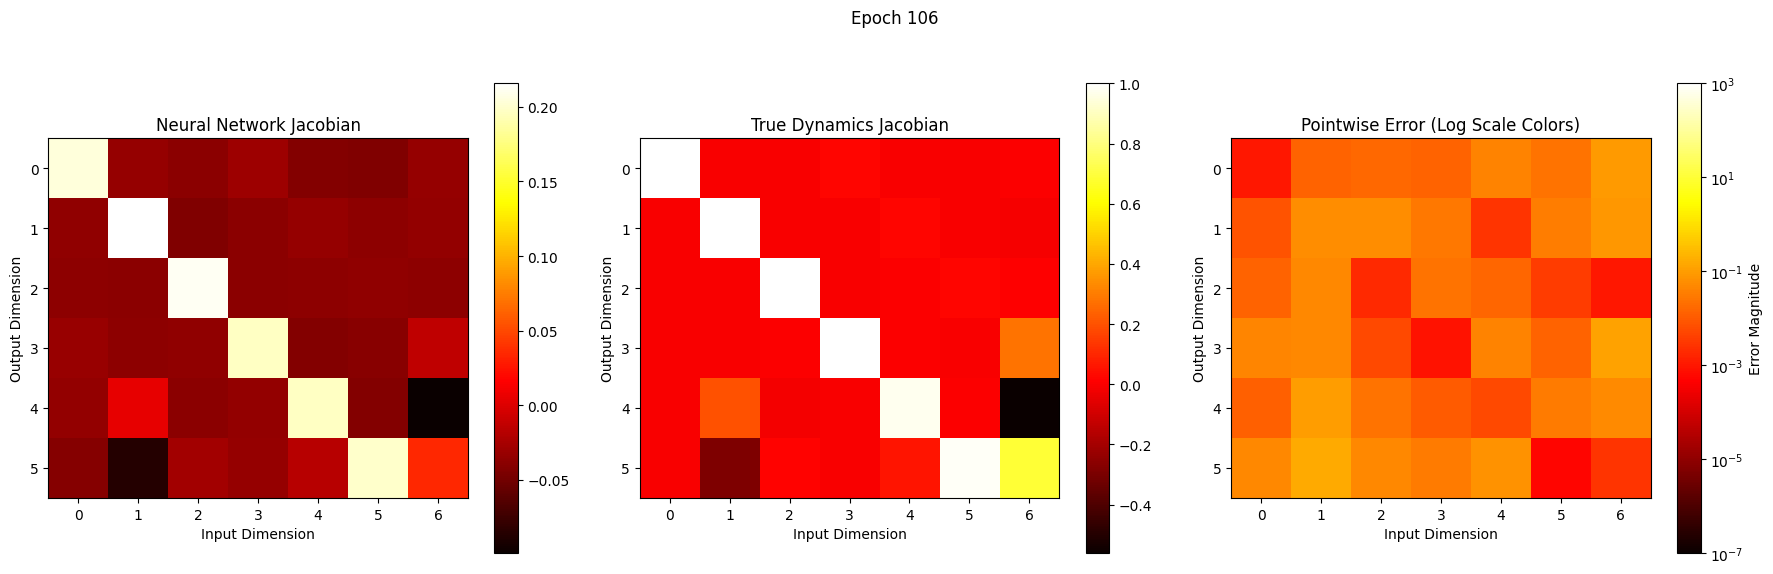

Epoch 107/200 complete: Avg Prediction Loss = 1.0008, Avg Alignment Loss = 0.0216, Total Batches Processed = 47
Epoch 108/200 complete: Avg Prediction Loss = 1.0219, Avg Alignment Loss = 0.0202, Total Batches Processed = 47
Epoch 109/200 complete: Avg Prediction Loss = 1.0805, Avg Alignment Loss = 0.0206, Total Batches Processed = 47
Epoch 110/200 complete: Avg Prediction Loss = 1.0930, Avg Alignment Loss = 0.0199, Total Batches Processed = 47
Epoch 111/200 complete: Avg Prediction Loss = 1.0667, Avg Alignment Loss = 0.0210, Total Batches Processed = 47
Epoch 112/200 complete: Avg Prediction Loss = 1.0600, Avg Alignment Loss = 0.0207, Total Batches Processed = 47
Epoch 113/200 complete: Avg Prediction Loss = 1.0238, Avg Alignment Loss = 0.0214, Total Batches Processed = 47
Epoch 114/200 complete: Avg Prediction Loss = 0.9805, Avg Alignment Loss = 0.0184, Total Batches Processed = 47
Epoch 115/200 complete: Avg Prediction Loss = 1.0359, Avg Alignment Loss = 0.0173, Total Batches Process

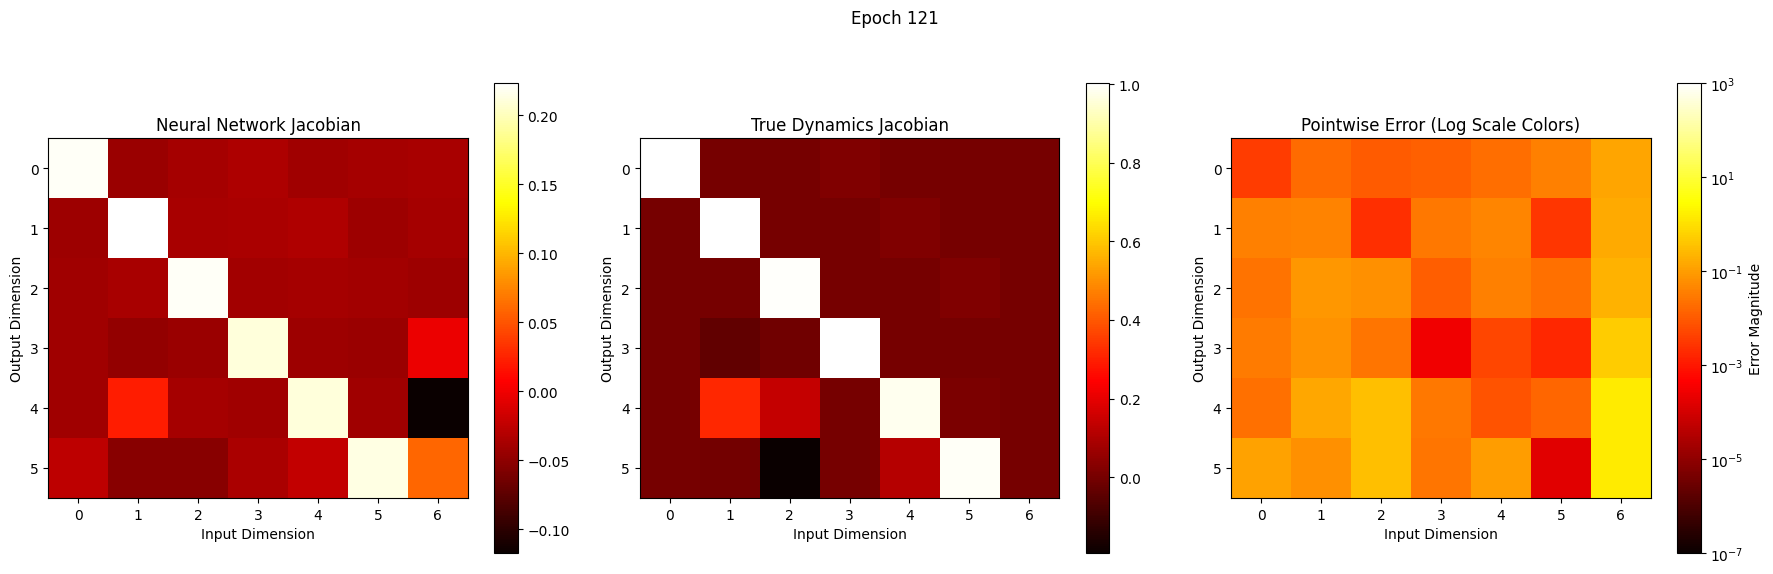

Epoch 122/200 complete: Avg Prediction Loss = 0.8888, Avg Alignment Loss = 0.0197, Total Batches Processed = 47
Epoch 123/200 complete: Avg Prediction Loss = 0.9639, Avg Alignment Loss = 0.0206, Total Batches Processed = 47
Epoch 124/200 complete: Avg Prediction Loss = 0.9528, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
Epoch 125/200 complete: Avg Prediction Loss = 0.8718, Avg Alignment Loss = 0.0196, Total Batches Processed = 47
Epoch 126/200 complete: Avg Prediction Loss = 0.9383, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
Epoch 127/200 complete: Avg Prediction Loss = 0.8549, Avg Alignment Loss = 0.0210, Total Batches Processed = 47
Epoch 128/200 complete: Avg Prediction Loss = 0.9295, Avg Alignment Loss = 0.0209, Total Batches Processed = 47
Epoch 129/200 complete: Avg Prediction Loss = 0.8352, Avg Alignment Loss = 0.0208, Total Batches Processed = 47
Epoch 130/200 complete: Avg Prediction Loss = 0.8521, Avg Alignment Loss = 0.0183, Total Batches Process

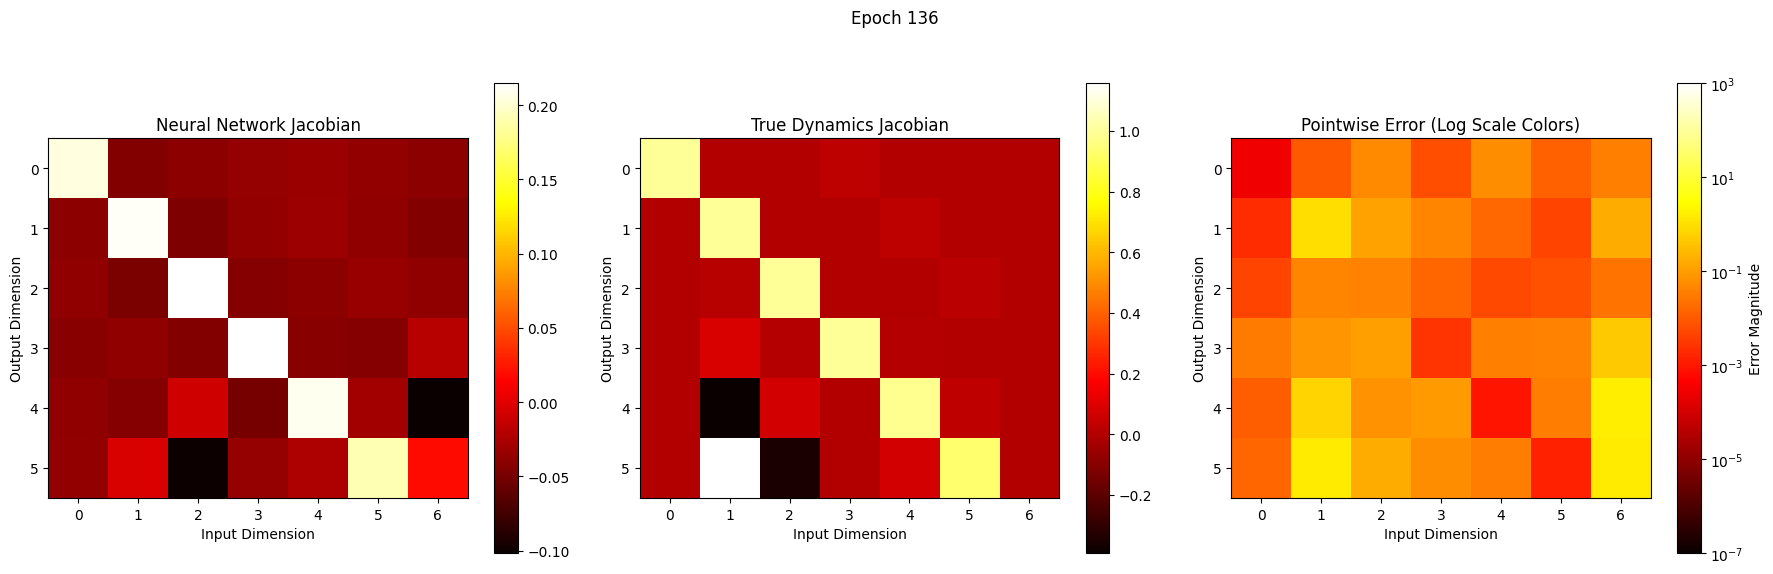

Epoch 137/200 complete: Avg Prediction Loss = 0.8514, Avg Alignment Loss = 0.0210, Total Batches Processed = 47
Epoch 138/200 complete: Avg Prediction Loss = 0.8959, Avg Alignment Loss = 0.0200, Total Batches Processed = 47
Epoch 139/200 complete: Avg Prediction Loss = 0.9437, Avg Alignment Loss = 0.0208, Total Batches Processed = 47
Epoch 140/200 complete: Avg Prediction Loss = 0.8075, Avg Alignment Loss = 0.0196, Total Batches Processed = 47
Epoch 141/200 complete: Avg Prediction Loss = 0.8718, Avg Alignment Loss = 0.0194, Total Batches Processed = 47
Epoch 142/200 complete: Avg Prediction Loss = 0.8199, Avg Alignment Loss = 0.0211, Total Batches Processed = 47
Epoch 143/200 complete: Avg Prediction Loss = 0.8322, Avg Alignment Loss = 0.0195, Total Batches Processed = 47
Epoch 144/200 complete: Avg Prediction Loss = 0.8589, Avg Alignment Loss = 0.0205, Total Batches Processed = 47
Epoch 145/200 complete: Avg Prediction Loss = 0.8808, Avg Alignment Loss = 0.0145, Total Batches Process

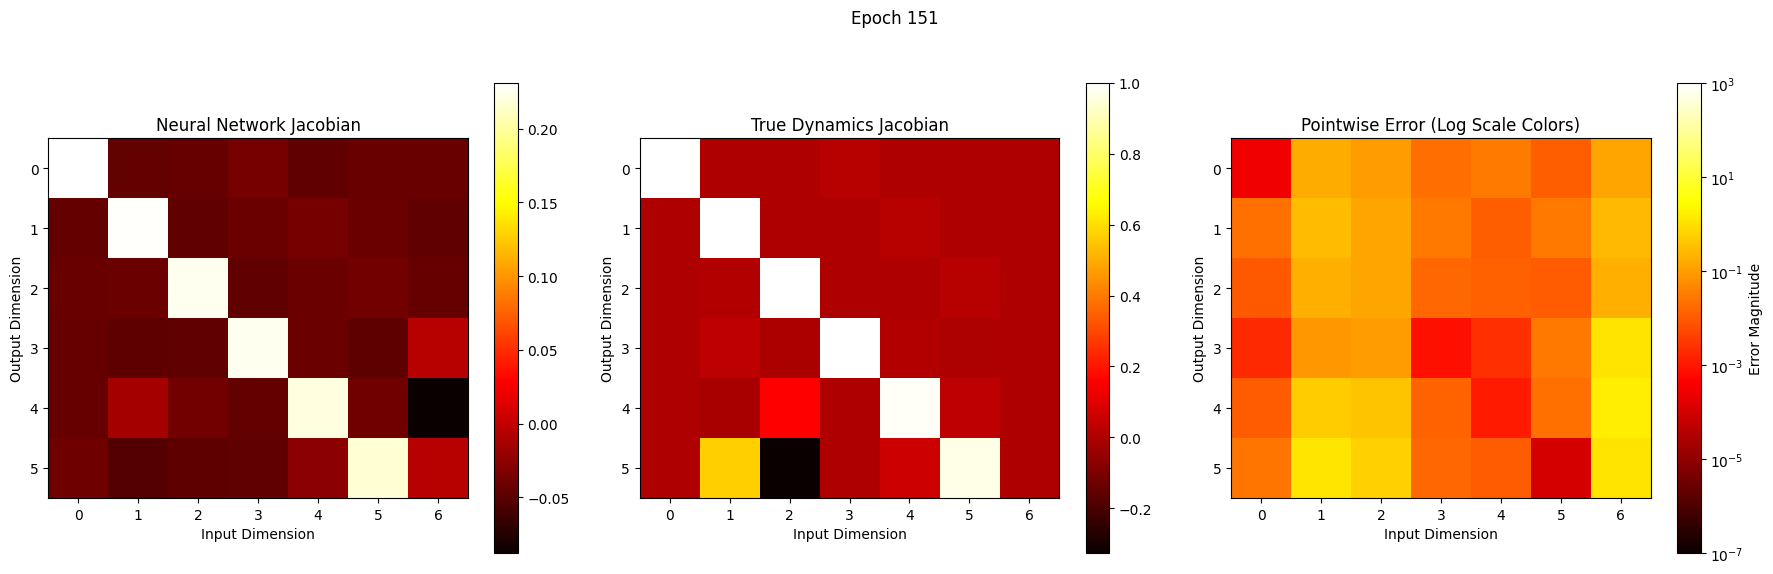

Epoch 152/200 complete: Avg Prediction Loss = 0.7672, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
Epoch 153/200 complete: Avg Prediction Loss = 0.8956, Avg Alignment Loss = 0.0205, Total Batches Processed = 47
Epoch 154/200 complete: Avg Prediction Loss = 0.7674, Avg Alignment Loss = 0.0198, Total Batches Processed = 47
Epoch 155/200 complete: Avg Prediction Loss = 0.8002, Avg Alignment Loss = 0.0206, Total Batches Processed = 47
Epoch 156/200 complete: Avg Prediction Loss = 0.8321, Avg Alignment Loss = 0.0201, Total Batches Processed = 47
Epoch 157/200 complete: Avg Prediction Loss = 0.7342, Avg Alignment Loss = 0.0200, Total Batches Processed = 47
Epoch 158/200 complete: Avg Prediction Loss = 0.8352, Avg Alignment Loss = 0.0190, Total Batches Processed = 47
Epoch 159/200 complete: Avg Prediction Loss = 0.7582, Avg Alignment Loss = 0.0210, Total Batches Processed = 47
Epoch 160/200 complete: Avg Prediction Loss = 0.9051, Avg Alignment Loss = 0.0195, Total Batches Process

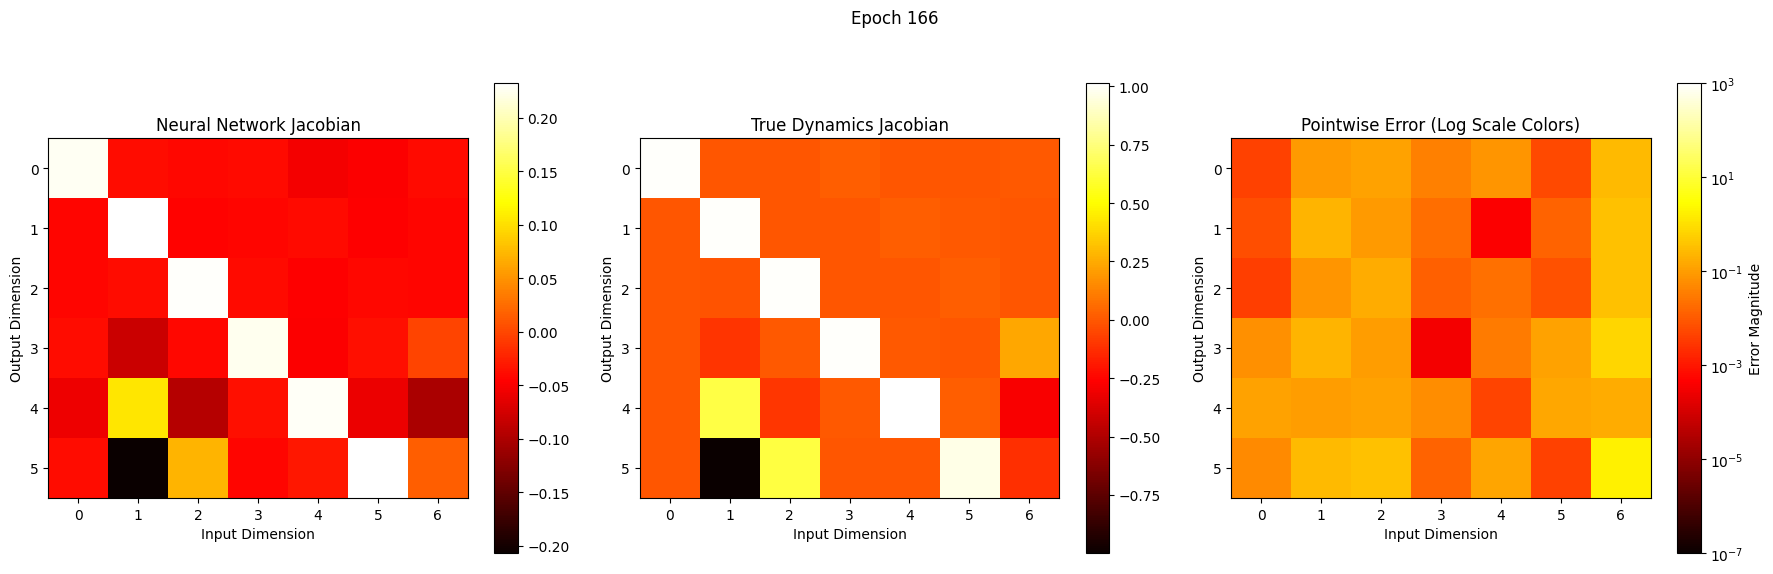

Epoch 167/200 complete: Avg Prediction Loss = 0.7306, Avg Alignment Loss = 0.0199, Total Batches Processed = 47
Epoch 168/200 complete: Avg Prediction Loss = 0.6649, Avg Alignment Loss = 0.0182, Total Batches Processed = 47
Epoch 169/200 complete: Avg Prediction Loss = 0.7168, Avg Alignment Loss = 0.0193, Total Batches Processed = 47
Epoch 170/200 complete: Avg Prediction Loss = 0.6793, Avg Alignment Loss = 0.0191, Total Batches Processed = 47
Epoch 171/200 complete: Avg Prediction Loss = 0.7269, Avg Alignment Loss = 0.0196, Total Batches Processed = 47
Epoch 172/200 complete: Avg Prediction Loss = 0.6538, Avg Alignment Loss = 0.0187, Total Batches Processed = 47
Epoch 173/200 complete: Avg Prediction Loss = 0.6728, Avg Alignment Loss = 0.0205, Total Batches Processed = 47
Epoch 174/200 complete: Avg Prediction Loss = 0.6826, Avg Alignment Loss = 0.0185, Total Batches Processed = 47
Epoch 175/200 complete: Avg Prediction Loss = 0.7482, Avg Alignment Loss = 0.0189, Total Batches Process

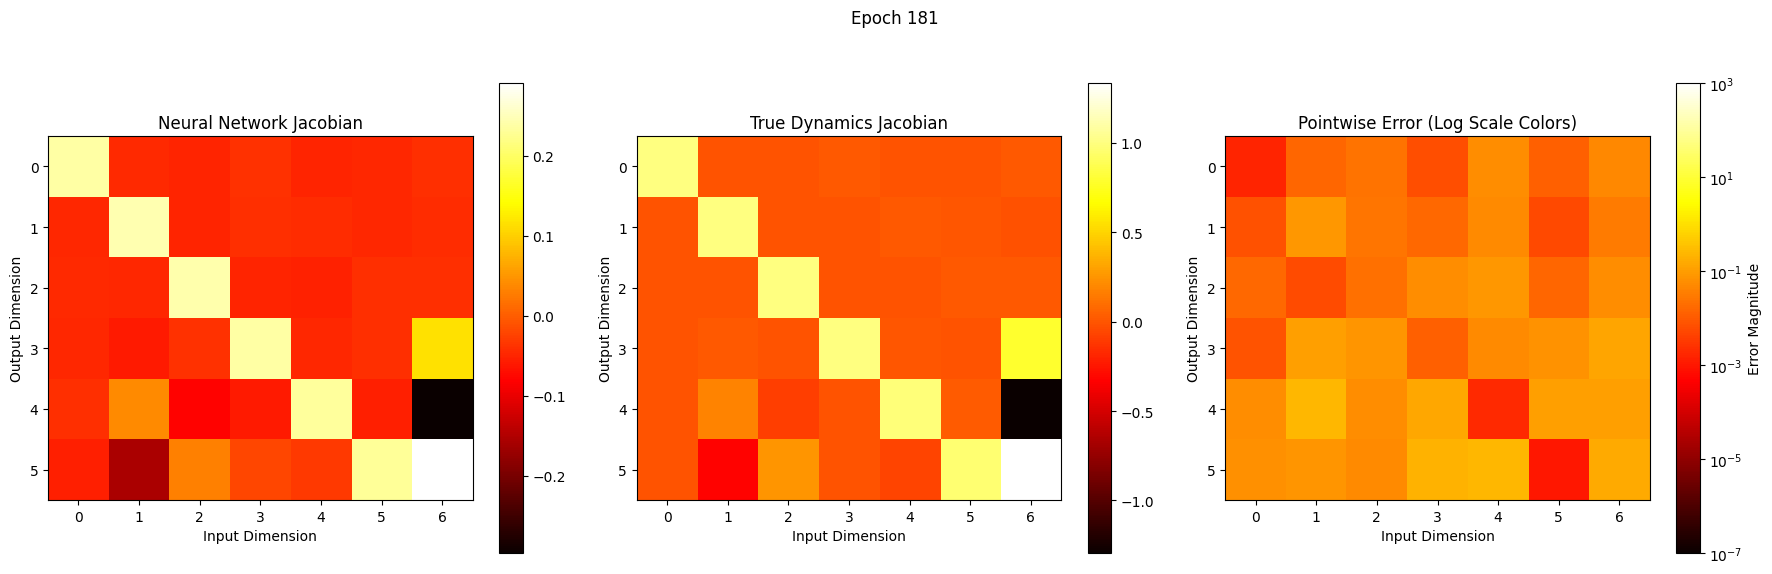

Epoch 182/200 complete: Avg Prediction Loss = 0.6434, Avg Alignment Loss = 0.0187, Total Batches Processed = 47
Epoch 183/200 complete: Avg Prediction Loss = 0.7193, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
Epoch 184/200 complete: Avg Prediction Loss = 0.7150, Avg Alignment Loss = 0.0179, Total Batches Processed = 47
Epoch 185/200 complete: Avg Prediction Loss = 0.6512, Avg Alignment Loss = 0.0183, Total Batches Processed = 47
Epoch 186/200 complete: Avg Prediction Loss = 0.7086, Avg Alignment Loss = 0.0197, Total Batches Processed = 47
Epoch 187/200 complete: Avg Prediction Loss = 0.6837, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 188/200 complete: Avg Prediction Loss = 0.6367, Avg Alignment Loss = 0.0195, Total Batches Processed = 47
Epoch 189/200 complete: Avg Prediction Loss = 0.7126, Avg Alignment Loss = 0.0194, Total Batches Processed = 47
Epoch 190/200 complete: Avg Prediction Loss = 0.6206, Avg Alignment Loss = 0.0190, Total Batches Process

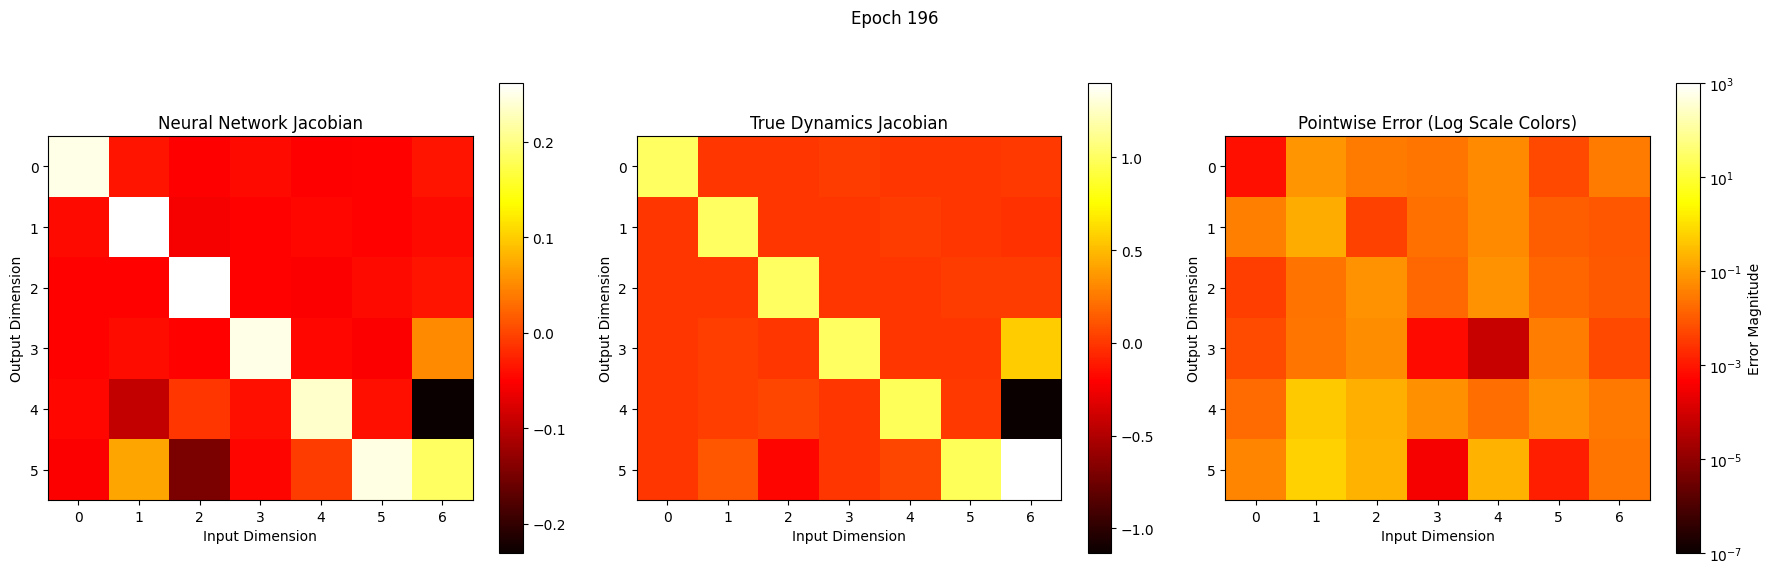

Epoch 197/200 complete: Avg Prediction Loss = 0.5888, Avg Alignment Loss = 0.0185, Total Batches Processed = 47
Epoch 198/200 complete: Avg Prediction Loss = 0.5776, Avg Alignment Loss = 0.0215, Total Batches Processed = 47
Epoch 199/200 complete: Avg Prediction Loss = 0.6227, Avg Alignment Loss = 0.0190, Total Batches Processed = 47
Epoch 200/200 complete: Avg Prediction Loss = 0.5902, Avg Alignment Loss = 0.0194, Total Batches Processed = 47
Alignment model training completed.
Training both model...
Epoch 1/200 complete: Avg Prediction Loss = 2.4037, Avg Alignment Loss = 0.1182, Total Batches Processed = 47
Plotting the Jacobians During Training
States shape: torch.Size([3, 6])
Actions shape: torch.Size([3, 1])
Jacobians shape: torch.Size([3, 6, 7])
nn_jacobian shape: torch.Size([3, 6, 3, 7])
jacobians shape: torch.Size([3, 6, 7])


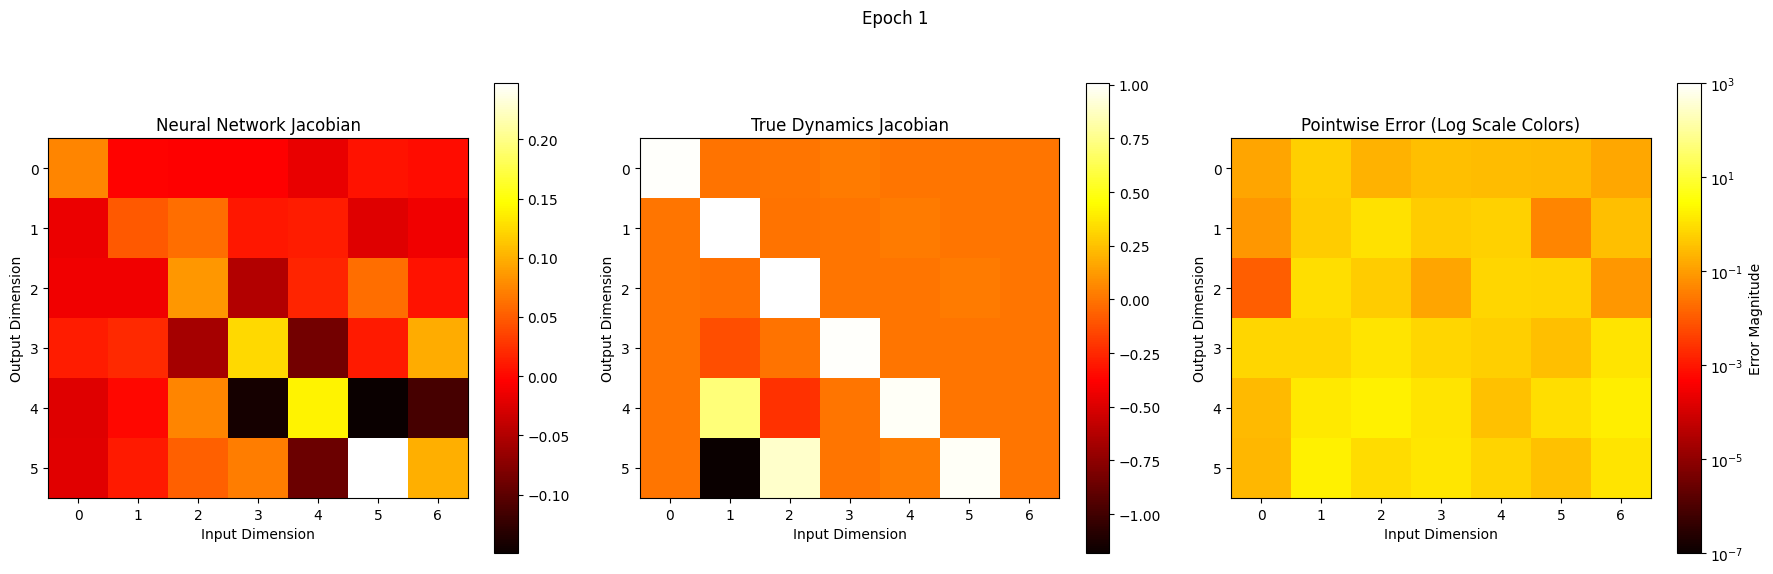

Epoch 2/200 complete: Avg Prediction Loss = 0.3859, Avg Alignment Loss = 0.0768, Total Batches Processed = 47
Epoch 3/200 complete: Avg Prediction Loss = 0.2578, Avg Alignment Loss = 0.0591, Total Batches Processed = 47
Epoch 4/200 complete: Avg Prediction Loss = 0.2363, Avg Alignment Loss = 0.0546, Total Batches Processed = 47
Epoch 5/200 complete: Avg Prediction Loss = 0.2194, Avg Alignment Loss = 0.0513, Total Batches Processed = 47
Epoch 6/200 complete: Avg Prediction Loss = 0.2062, Avg Alignment Loss = 0.0483, Total Batches Processed = 47
Epoch 7/200 complete: Avg Prediction Loss = 0.1979, Avg Alignment Loss = 0.0431, Total Batches Processed = 47
Epoch 8/200 complete: Avg Prediction Loss = 0.1879, Avg Alignment Loss = 0.0448, Total Batches Processed = 47
Epoch 9/200 complete: Avg Prediction Loss = 0.1810, Avg Alignment Loss = 0.0425, Total Batches Processed = 47
Epoch 10/200 complete: Avg Prediction Loss = 0.1717, Avg Alignment Loss = 0.0406, Total Batches Processed = 47
Epoch 11/

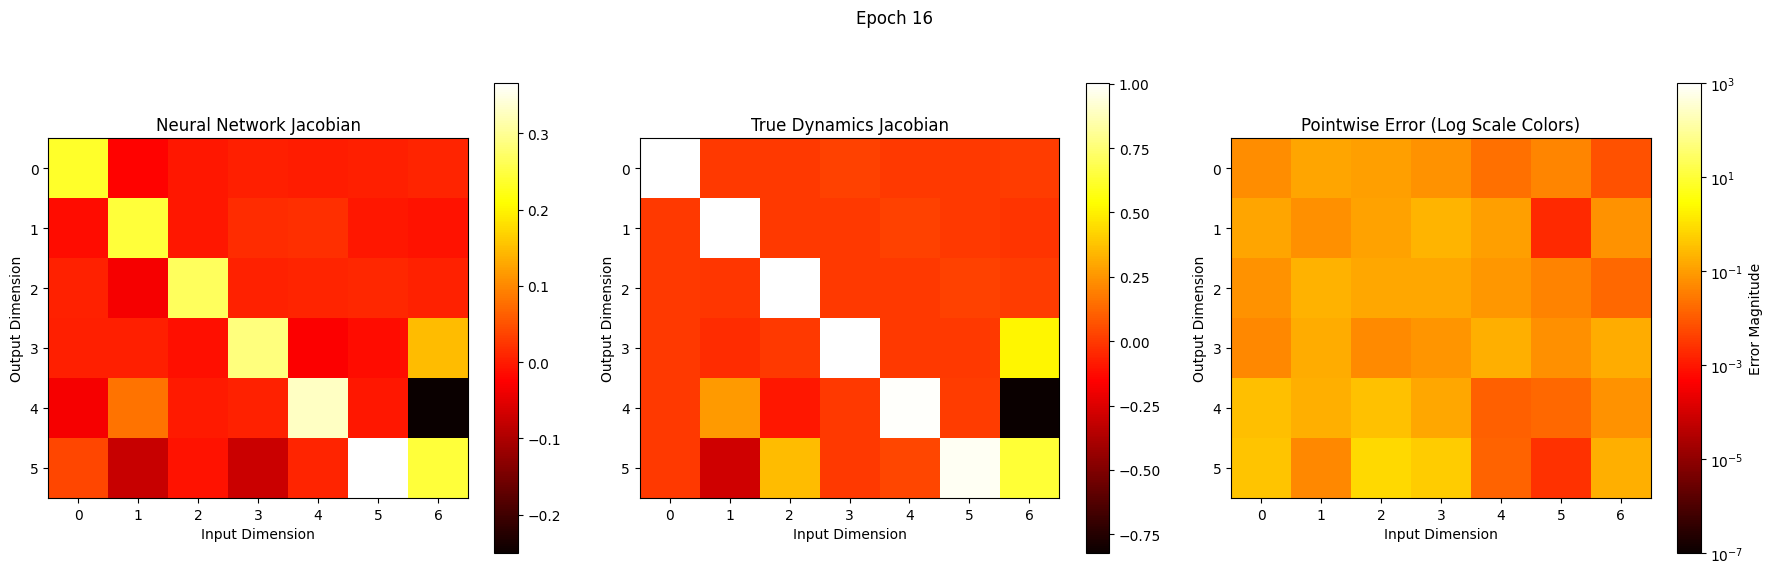

Epoch 17/200 complete: Avg Prediction Loss = 0.1245, Avg Alignment Loss = 0.0290, Total Batches Processed = 47
Epoch 18/200 complete: Avg Prediction Loss = 0.1183, Avg Alignment Loss = 0.0263, Total Batches Processed = 47
Epoch 19/200 complete: Avg Prediction Loss = 0.1119, Avg Alignment Loss = 0.0261, Total Batches Processed = 47
Epoch 20/200 complete: Avg Prediction Loss = 0.1070, Avg Alignment Loss = 0.0239, Total Batches Processed = 47
Epoch 21/200 complete: Avg Prediction Loss = 0.1016, Avg Alignment Loss = 0.0241, Total Batches Processed = 47
Epoch 22/200 complete: Avg Prediction Loss = 0.0960, Avg Alignment Loss = 0.0244, Total Batches Processed = 47
Epoch 23/200 complete: Avg Prediction Loss = 0.0916, Avg Alignment Loss = 0.0235, Total Batches Processed = 47
Epoch 24/200 complete: Avg Prediction Loss = 0.0876, Avg Alignment Loss = 0.0232, Total Batches Processed = 47
Epoch 25/200 complete: Avg Prediction Loss = 0.0840, Avg Alignment Loss = 0.0229, Total Batches Processed = 47
E

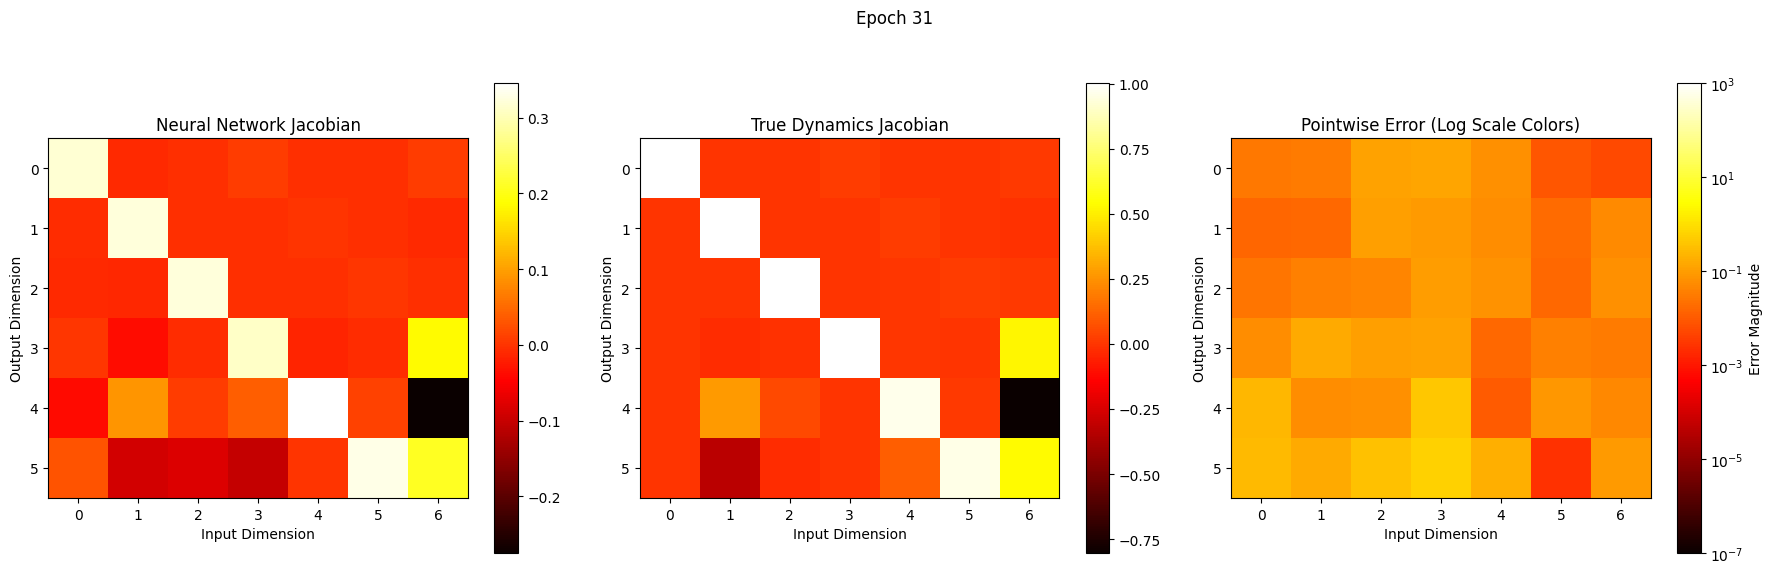

Epoch 32/200 complete: Avg Prediction Loss = 0.0646, Avg Alignment Loss = 0.0207, Total Batches Processed = 47
Epoch 33/200 complete: Avg Prediction Loss = 0.0624, Avg Alignment Loss = 0.0197, Total Batches Processed = 47
Epoch 34/200 complete: Avg Prediction Loss = 0.0603, Avg Alignment Loss = 0.0191, Total Batches Processed = 47
Epoch 35/200 complete: Avg Prediction Loss = 0.0592, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
Epoch 36/200 complete: Avg Prediction Loss = 0.0573, Avg Alignment Loss = 0.0202, Total Batches Processed = 47
Epoch 37/200 complete: Avg Prediction Loss = 0.0552, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
Epoch 38/200 complete: Avg Prediction Loss = 0.0555, Avg Alignment Loss = 0.0189, Total Batches Processed = 47
Epoch 39/200 complete: Avg Prediction Loss = 0.0531, Avg Alignment Loss = 0.0190, Total Batches Processed = 47
Epoch 40/200 complete: Avg Prediction Loss = 0.0521, Avg Alignment Loss = 0.0203, Total Batches Processed = 47
E

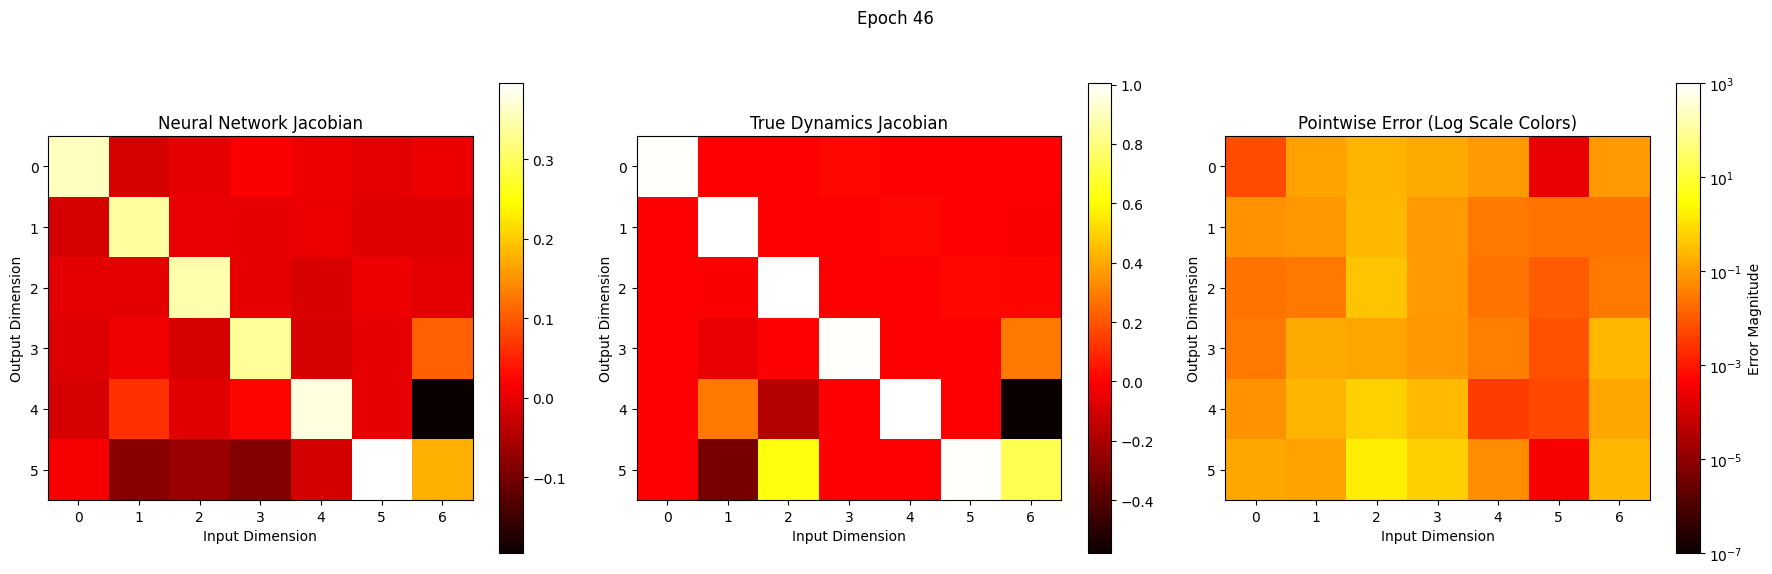

Epoch 47/200 complete: Avg Prediction Loss = 0.0441, Avg Alignment Loss = 0.0205, Total Batches Processed = 47
Epoch 48/200 complete: Avg Prediction Loss = 0.0427, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
Epoch 49/200 complete: Avg Prediction Loss = 0.0414, Avg Alignment Loss = 0.0175, Total Batches Processed = 47
Epoch 50/200 complete: Avg Prediction Loss = 0.0415, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
Epoch 51/200 complete: Avg Prediction Loss = 0.0389, Avg Alignment Loss = 0.0185, Total Batches Processed = 47
Epoch 52/200 complete: Avg Prediction Loss = 0.0398, Avg Alignment Loss = 0.0197, Total Batches Processed = 47
Epoch 53/200 complete: Avg Prediction Loss = 0.0377, Avg Alignment Loss = 0.0195, Total Batches Processed = 47
Epoch 54/200 complete: Avg Prediction Loss = 0.0378, Avg Alignment Loss = 0.0197, Total Batches Processed = 47
Epoch 55/200 complete: Avg Prediction Loss = 0.0392, Avg Alignment Loss = 0.0197, Total Batches Processed = 47
E

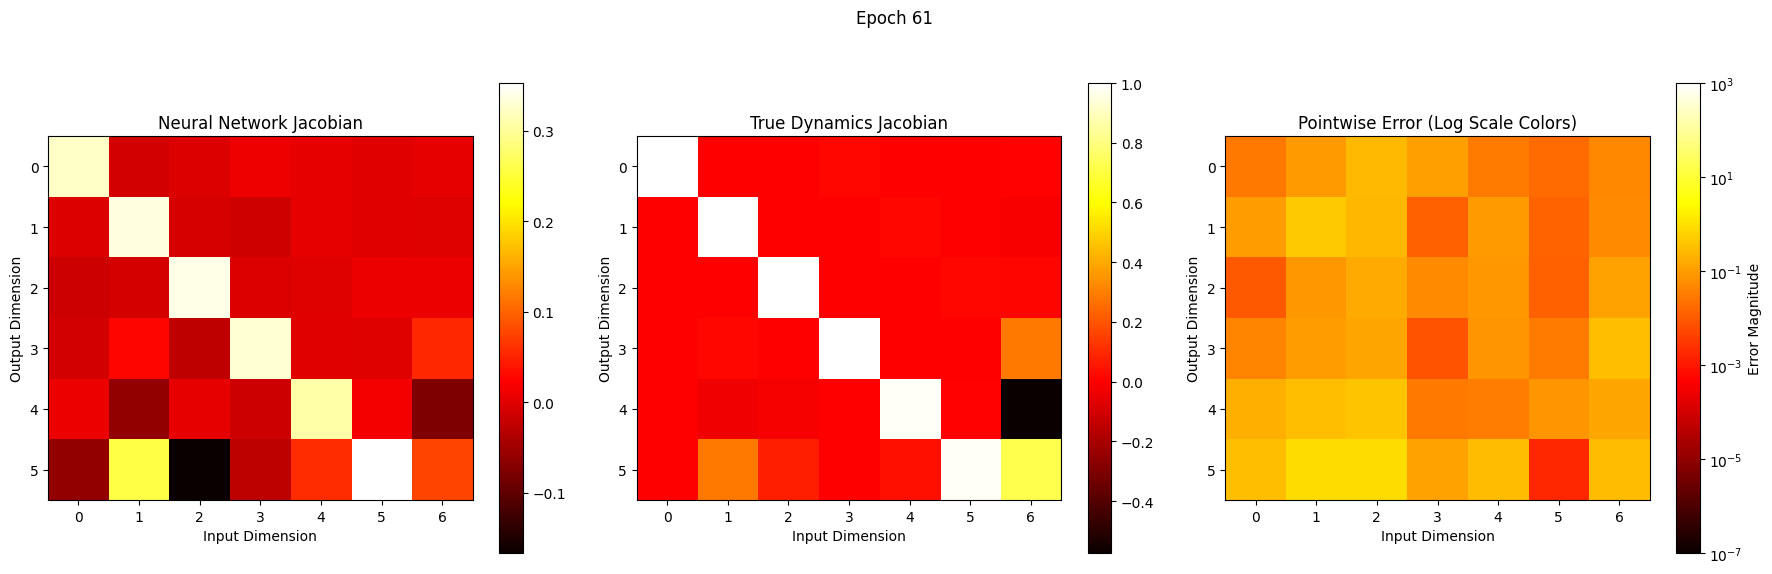

Epoch 62/200 complete: Avg Prediction Loss = 0.0331, Avg Alignment Loss = 0.0187, Total Batches Processed = 47
Epoch 63/200 complete: Avg Prediction Loss = 0.0333, Avg Alignment Loss = 0.0184, Total Batches Processed = 47
Epoch 64/200 complete: Avg Prediction Loss = 0.0331, Avg Alignment Loss = 0.0192, Total Batches Processed = 47
Epoch 65/200 complete: Avg Prediction Loss = 0.0337, Avg Alignment Loss = 0.0185, Total Batches Processed = 47
Epoch 66/200 complete: Avg Prediction Loss = 0.0327, Avg Alignment Loss = 0.0158, Total Batches Processed = 47
Epoch 67/200 complete: Avg Prediction Loss = 0.0316, Avg Alignment Loss = 0.0190, Total Batches Processed = 47
Epoch 68/200 complete: Avg Prediction Loss = 0.0298, Avg Alignment Loss = 0.0198, Total Batches Processed = 47
Epoch 69/200 complete: Avg Prediction Loss = 0.0302, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
Epoch 70/200 complete: Avg Prediction Loss = 0.0304, Avg Alignment Loss = 0.0150, Total Batches Processed = 47
E

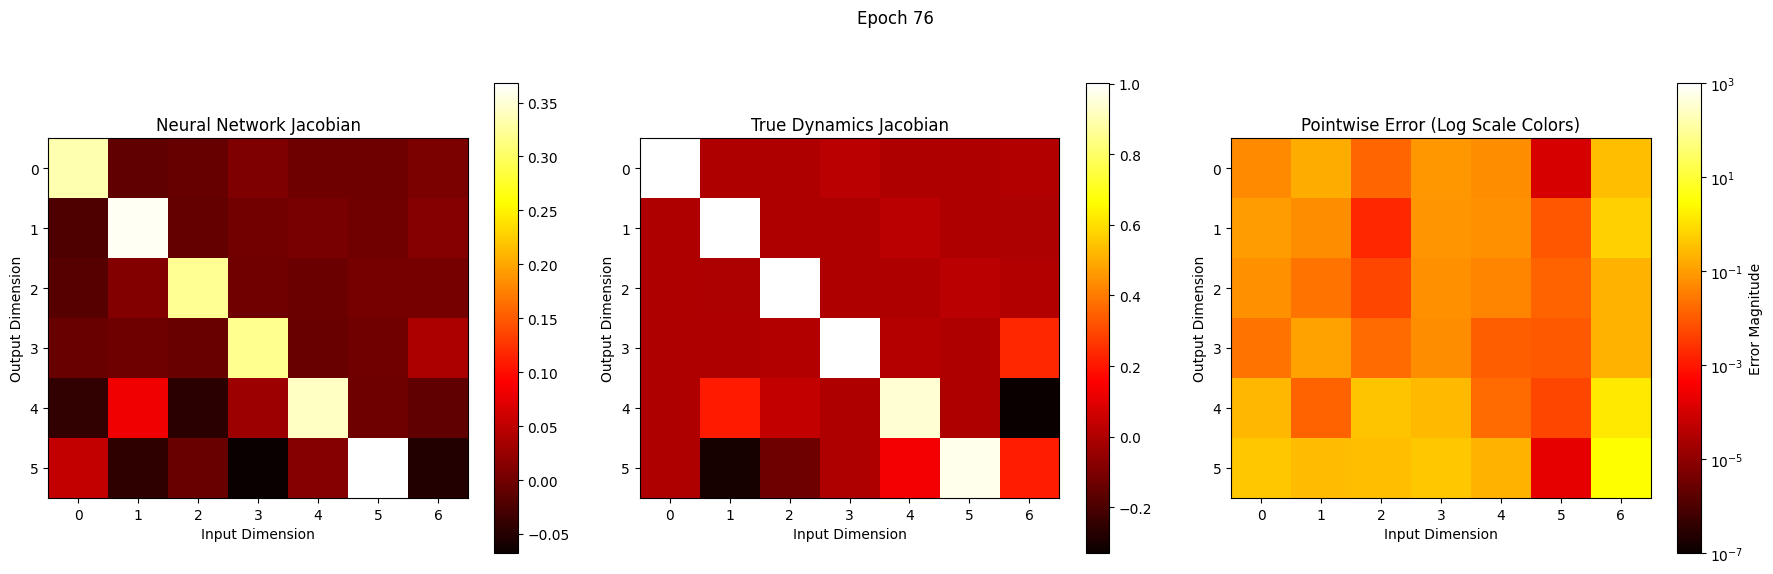

Epoch 77/200 complete: Avg Prediction Loss = 0.0281, Avg Alignment Loss = 0.0186, Total Batches Processed = 47
Epoch 78/200 complete: Avg Prediction Loss = 0.0276, Avg Alignment Loss = 0.0126, Total Batches Processed = 47
Epoch 79/200 complete: Avg Prediction Loss = 0.0278, Avg Alignment Loss = 0.0177, Total Batches Processed = 47
Epoch 80/200 complete: Avg Prediction Loss = 0.0265, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 81/200 complete: Avg Prediction Loss = 0.0268, Avg Alignment Loss = 0.0166, Total Batches Processed = 47
Epoch 82/200 complete: Avg Prediction Loss = 0.0261, Avg Alignment Loss = 0.0178, Total Batches Processed = 47
Epoch 83/200 complete: Avg Prediction Loss = 0.0264, Avg Alignment Loss = 0.0185, Total Batches Processed = 47
Epoch 84/200 complete: Avg Prediction Loss = 0.0275, Avg Alignment Loss = 0.0182, Total Batches Processed = 47
Epoch 85/200 complete: Avg Prediction Loss = 0.0283, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
E

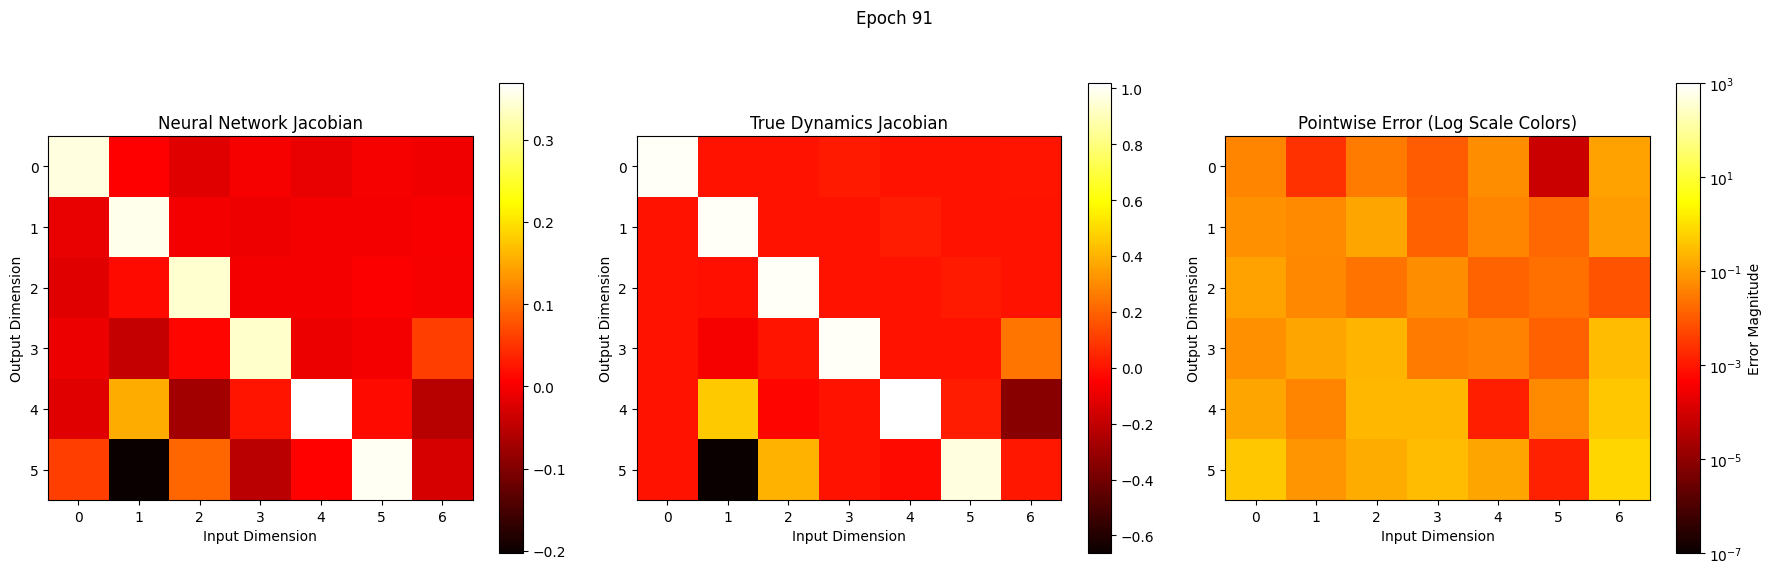

Epoch 92/200 complete: Avg Prediction Loss = 0.0264, Avg Alignment Loss = 0.0176, Total Batches Processed = 47
Epoch 93/200 complete: Avg Prediction Loss = 0.0253, Avg Alignment Loss = 0.0173, Total Batches Processed = 47
Epoch 94/200 complete: Avg Prediction Loss = 0.0257, Avg Alignment Loss = 0.0170, Total Batches Processed = 47
Epoch 95/200 complete: Avg Prediction Loss = 0.0251, Avg Alignment Loss = 0.0148, Total Batches Processed = 47
Epoch 96/200 complete: Avg Prediction Loss = 0.0245, Avg Alignment Loss = 0.0202, Total Batches Processed = 47
Epoch 97/200 complete: Avg Prediction Loss = 0.0239, Avg Alignment Loss = 0.0184, Total Batches Processed = 47
Epoch 98/200 complete: Avg Prediction Loss = 0.0238, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 99/200 complete: Avg Prediction Loss = 0.0248, Avg Alignment Loss = 0.0166, Total Batches Processed = 47
Epoch 100/200 complete: Avg Prediction Loss = 0.0244, Avg Alignment Loss = 0.0170, Total Batches Processed = 47


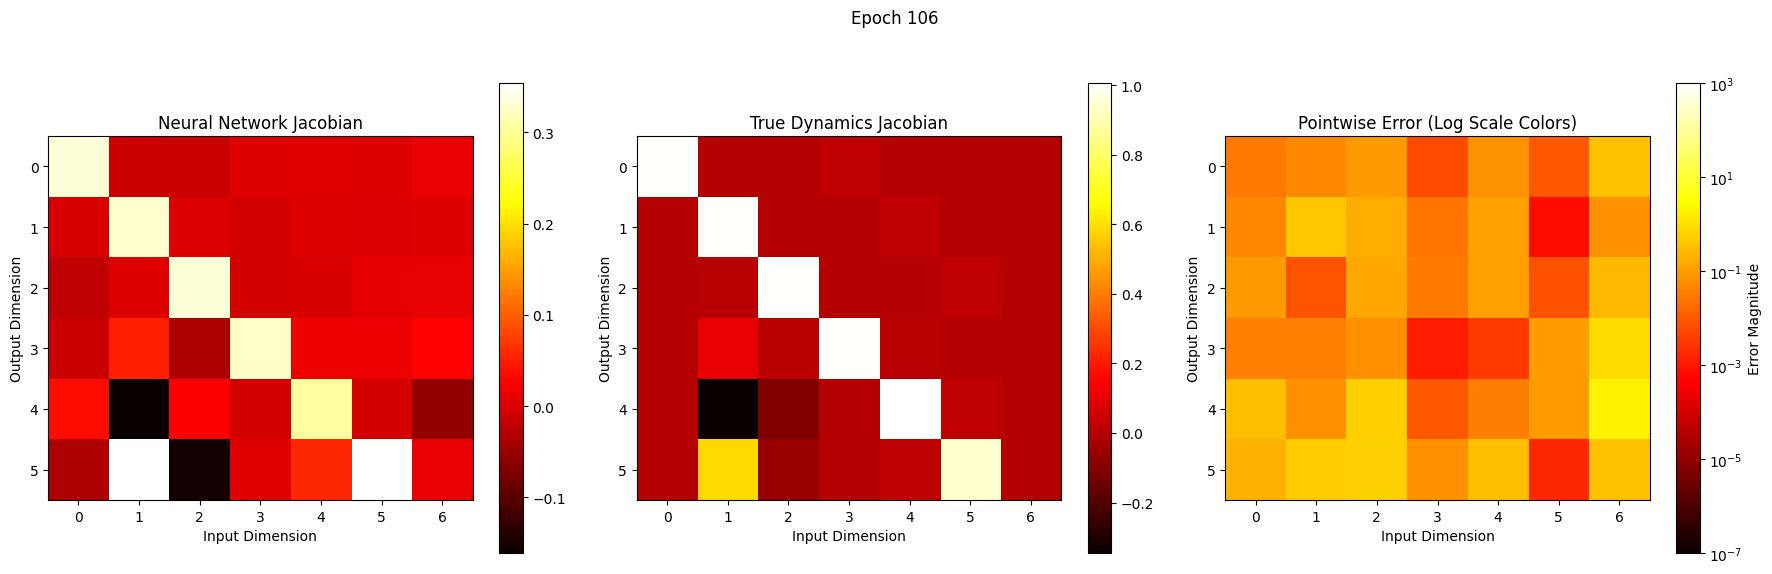

Epoch 107/200 complete: Avg Prediction Loss = 0.0228, Avg Alignment Loss = 0.0166, Total Batches Processed = 47
Epoch 108/200 complete: Avg Prediction Loss = 0.0249, Avg Alignment Loss = 0.0176, Total Batches Processed = 47
Epoch 109/200 complete: Avg Prediction Loss = 0.0226, Avg Alignment Loss = 0.0189, Total Batches Processed = 47
Epoch 110/200 complete: Avg Prediction Loss = 0.0225, Avg Alignment Loss = 0.0185, Total Batches Processed = 47
Epoch 111/200 complete: Avg Prediction Loss = 0.0232, Avg Alignment Loss = 0.0178, Total Batches Processed = 47
Epoch 112/200 complete: Avg Prediction Loss = 0.0229, Avg Alignment Loss = 0.0169, Total Batches Processed = 47
Epoch 113/200 complete: Avg Prediction Loss = 0.0248, Avg Alignment Loss = 0.0182, Total Batches Processed = 47
Epoch 114/200 complete: Avg Prediction Loss = 0.0228, Avg Alignment Loss = 0.0189, Total Batches Processed = 47
Epoch 115/200 complete: Avg Prediction Loss = 0.0231, Avg Alignment Loss = 0.0198, Total Batches Process

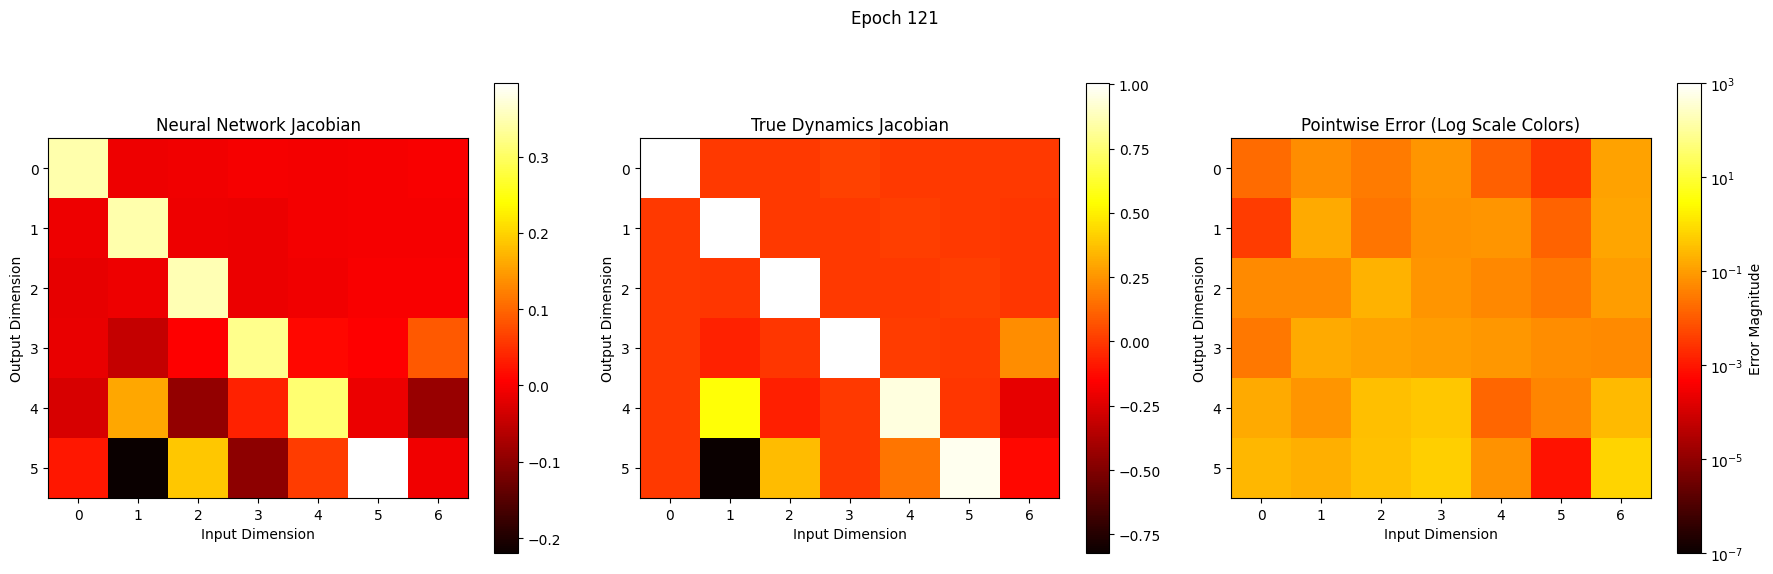

Epoch 122/200 complete: Avg Prediction Loss = 0.0227, Avg Alignment Loss = 0.0190, Total Batches Processed = 47
Epoch 123/200 complete: Avg Prediction Loss = 0.0213, Avg Alignment Loss = 0.0178, Total Batches Processed = 47
Epoch 124/200 complete: Avg Prediction Loss = 0.0213, Avg Alignment Loss = 0.0181, Total Batches Processed = 47
Epoch 125/200 complete: Avg Prediction Loss = 0.0214, Avg Alignment Loss = 0.0178, Total Batches Processed = 47
Epoch 126/200 complete: Avg Prediction Loss = 0.0217, Avg Alignment Loss = 0.0177, Total Batches Processed = 47
Epoch 127/200 complete: Avg Prediction Loss = 0.0213, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 128/200 complete: Avg Prediction Loss = 0.0215, Avg Alignment Loss = 0.0188, Total Batches Processed = 47
Epoch 129/200 complete: Avg Prediction Loss = 0.0220, Avg Alignment Loss = 0.0176, Total Batches Processed = 47
Epoch 130/200 complete: Avg Prediction Loss = 0.0211, Avg Alignment Loss = 0.0181, Total Batches Process

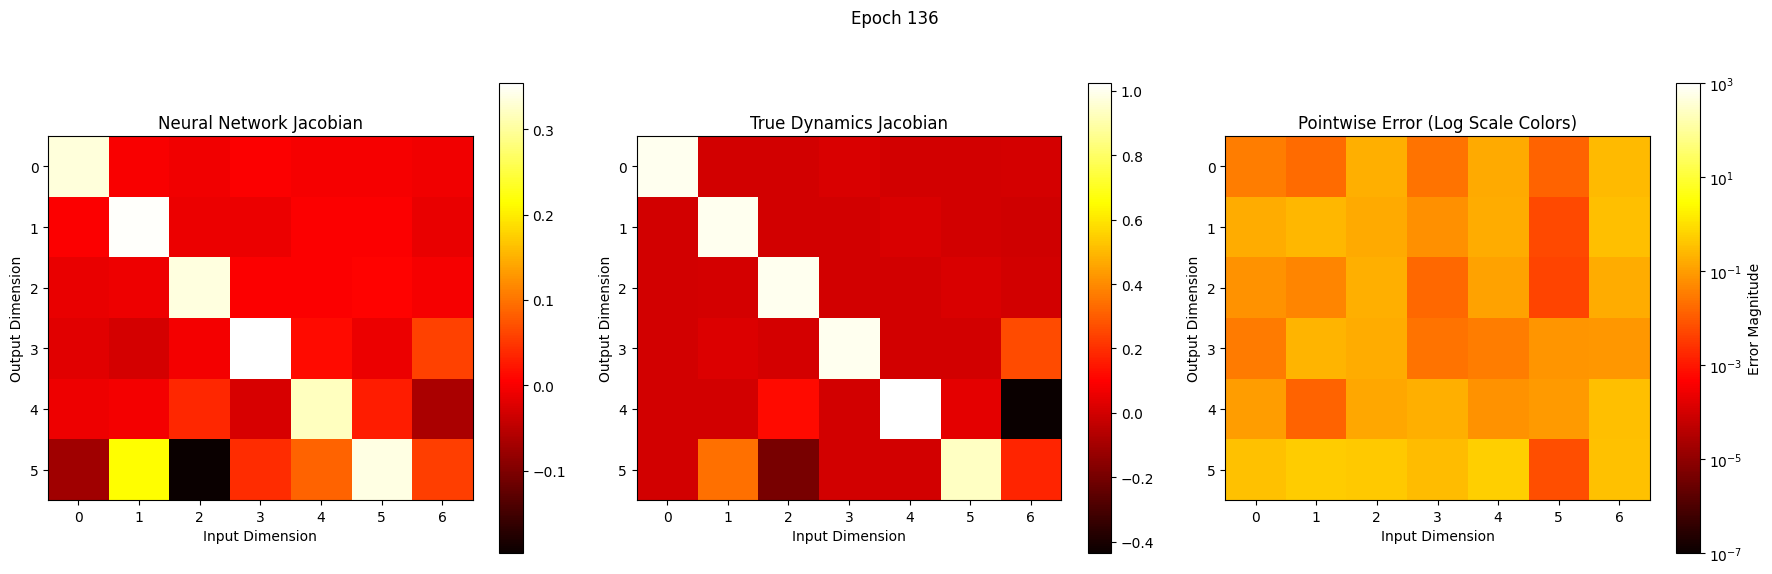

Epoch 137/200 complete: Avg Prediction Loss = 0.0199, Avg Alignment Loss = 0.0171, Total Batches Processed = 47
Epoch 138/200 complete: Avg Prediction Loss = 0.0198, Avg Alignment Loss = 0.0190, Total Batches Processed = 47
Epoch 139/200 complete: Avg Prediction Loss = 0.0212, Avg Alignment Loss = 0.0178, Total Batches Processed = 47
Epoch 140/200 complete: Avg Prediction Loss = 0.0206, Avg Alignment Loss = 0.0172, Total Batches Processed = 47
Epoch 141/200 complete: Avg Prediction Loss = 0.0209, Avg Alignment Loss = 0.0201, Total Batches Processed = 47
Epoch 142/200 complete: Avg Prediction Loss = 0.0202, Avg Alignment Loss = 0.0182, Total Batches Processed = 47
Epoch 143/200 complete: Avg Prediction Loss = 0.0203, Avg Alignment Loss = 0.0172, Total Batches Processed = 47
Epoch 144/200 complete: Avg Prediction Loss = 0.0208, Avg Alignment Loss = 0.0165, Total Batches Processed = 47
Epoch 145/200 complete: Avg Prediction Loss = 0.0199, Avg Alignment Loss = 0.0186, Total Batches Process

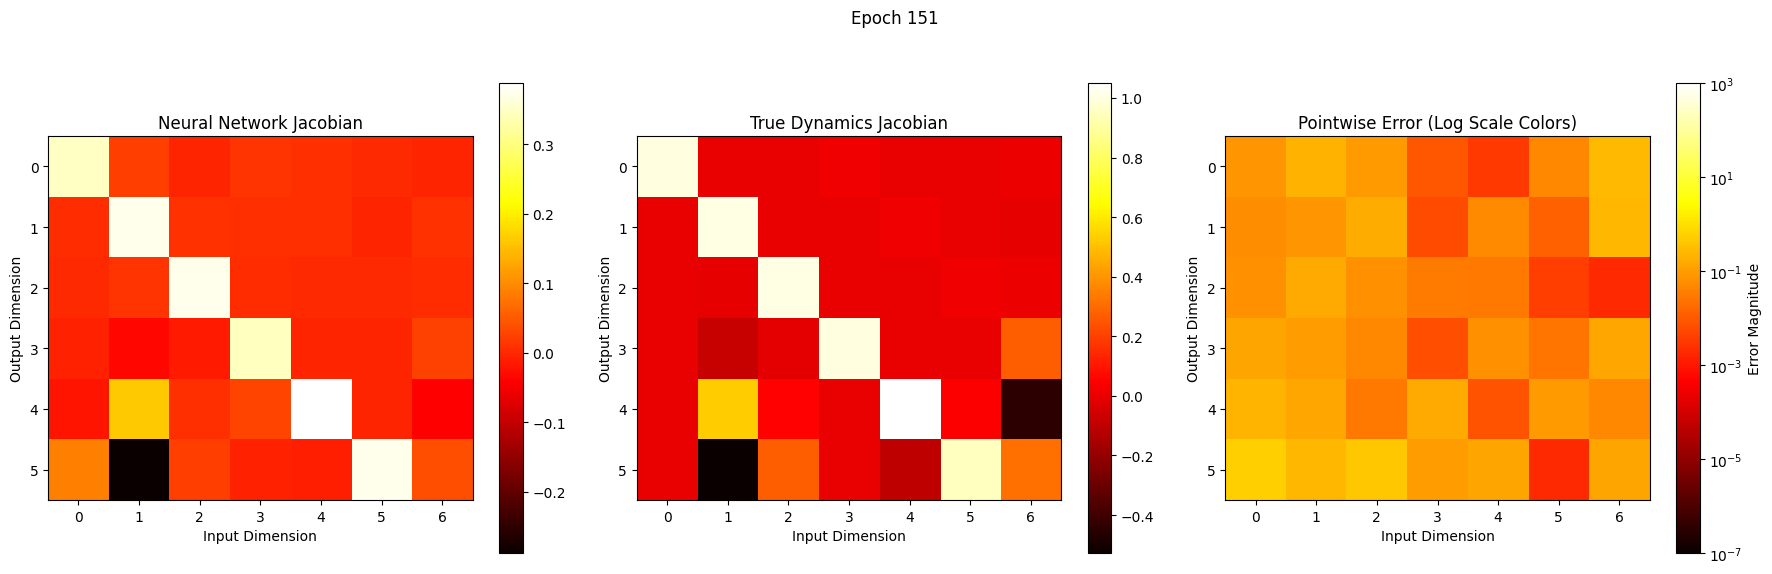

Epoch 152/200 complete: Avg Prediction Loss = 0.0196, Avg Alignment Loss = 0.0166, Total Batches Processed = 47
Epoch 153/200 complete: Avg Prediction Loss = 0.0194, Avg Alignment Loss = 0.0182, Total Batches Processed = 47
Epoch 154/200 complete: Avg Prediction Loss = 0.0197, Avg Alignment Loss = 0.0176, Total Batches Processed = 47
Epoch 155/200 complete: Avg Prediction Loss = 0.0197, Avg Alignment Loss = 0.0188, Total Batches Processed = 47
Epoch 156/200 complete: Avg Prediction Loss = 0.0192, Avg Alignment Loss = 0.0158, Total Batches Processed = 47
Epoch 157/200 complete: Avg Prediction Loss = 0.0182, Avg Alignment Loss = 0.0172, Total Batches Processed = 47
Epoch 158/200 complete: Avg Prediction Loss = 0.0196, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
Epoch 159/200 complete: Avg Prediction Loss = 0.0190, Avg Alignment Loss = 0.0184, Total Batches Processed = 47
Epoch 160/200 complete: Avg Prediction Loss = 0.0182, Avg Alignment Loss = 0.0182, Total Batches Process

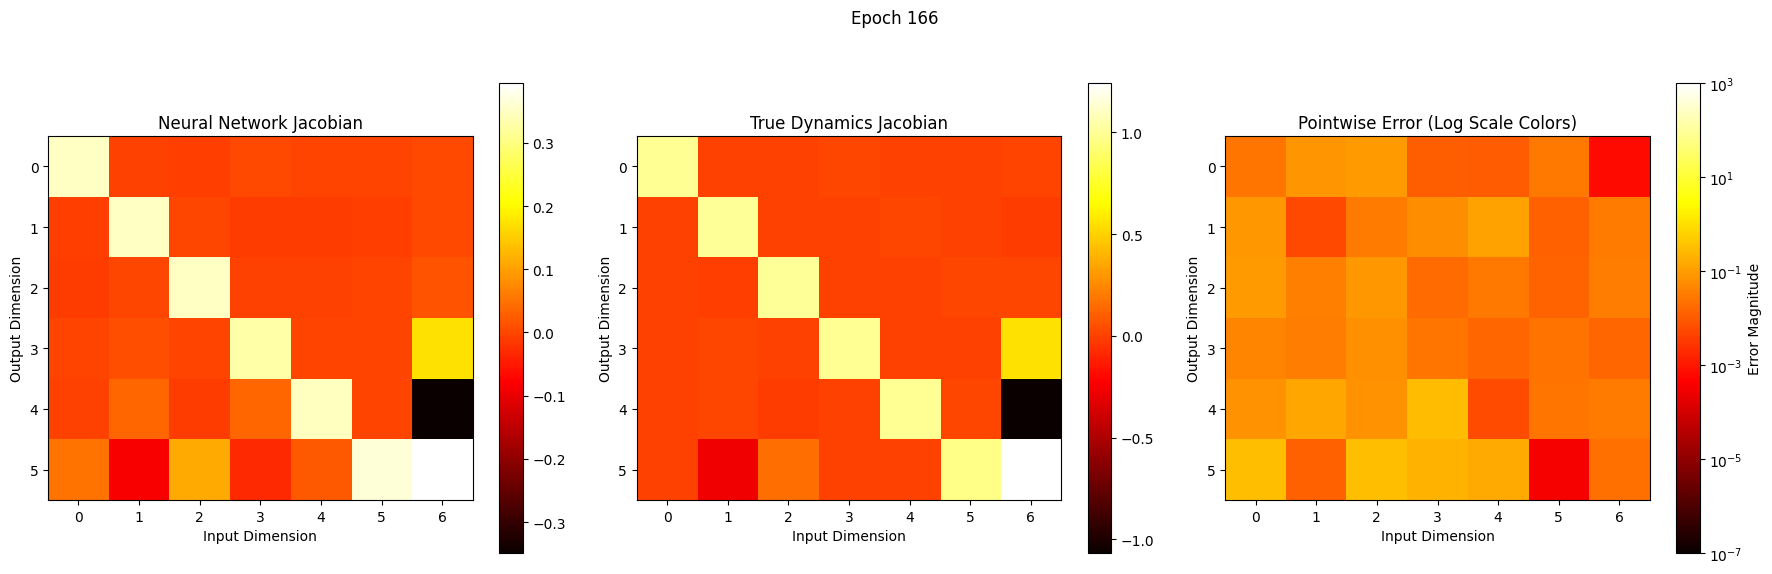

Epoch 167/200 complete: Avg Prediction Loss = 0.0186, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
Epoch 168/200 complete: Avg Prediction Loss = 0.0184, Avg Alignment Loss = 0.0172, Total Batches Processed = 47
Epoch 169/200 complete: Avg Prediction Loss = 0.0173, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 170/200 complete: Avg Prediction Loss = 0.0176, Avg Alignment Loss = 0.0177, Total Batches Processed = 47
Epoch 171/200 complete: Avg Prediction Loss = 0.0184, Avg Alignment Loss = 0.0173, Total Batches Processed = 47
Epoch 172/200 complete: Avg Prediction Loss = 0.0184, Avg Alignment Loss = 0.0167, Total Batches Processed = 47
Epoch 173/200 complete: Avg Prediction Loss = 0.0175, Avg Alignment Loss = 0.0166, Total Batches Processed = 47
Epoch 174/200 complete: Avg Prediction Loss = 0.0180, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 175/200 complete: Avg Prediction Loss = 0.0179, Avg Alignment Loss = 0.0178, Total Batches Process

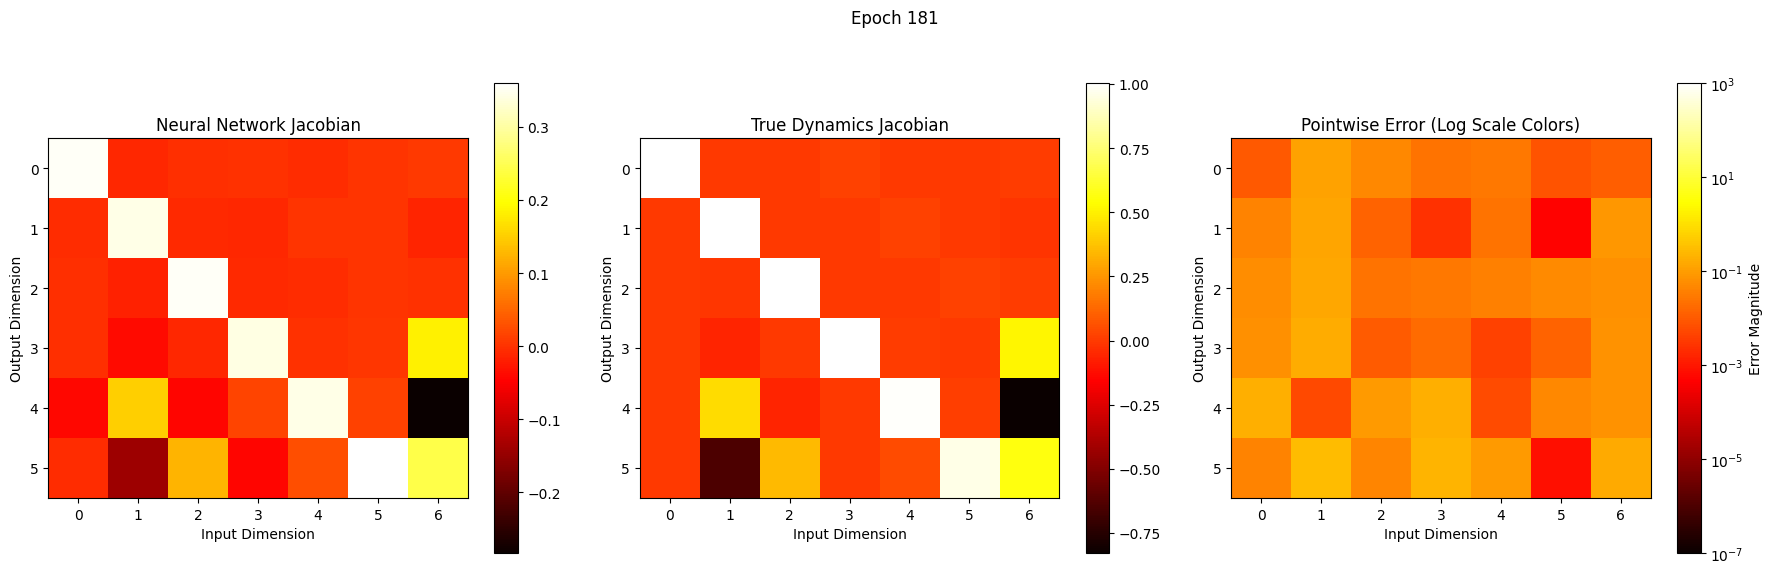

Epoch 182/200 complete: Avg Prediction Loss = 0.0174, Avg Alignment Loss = 0.0103, Total Batches Processed = 47
Epoch 183/200 complete: Avg Prediction Loss = 0.0181, Avg Alignment Loss = 0.0170, Total Batches Processed = 47
Epoch 184/200 complete: Avg Prediction Loss = 0.0179, Avg Alignment Loss = 0.0156, Total Batches Processed = 47
Epoch 185/200 complete: Avg Prediction Loss = 0.0178, Avg Alignment Loss = 0.0184, Total Batches Processed = 47
Epoch 186/200 complete: Avg Prediction Loss = 0.0178, Avg Alignment Loss = 0.0198, Total Batches Processed = 47
Epoch 187/200 complete: Avg Prediction Loss = 0.0179, Avg Alignment Loss = 0.0175, Total Batches Processed = 47
Epoch 188/200 complete: Avg Prediction Loss = 0.0175, Avg Alignment Loss = 0.0142, Total Batches Processed = 47
Epoch 189/200 complete: Avg Prediction Loss = 0.0182, Avg Alignment Loss = 0.0188, Total Batches Processed = 47
Epoch 190/200 complete: Avg Prediction Loss = 0.0190, Avg Alignment Loss = 0.0176, Total Batches Process

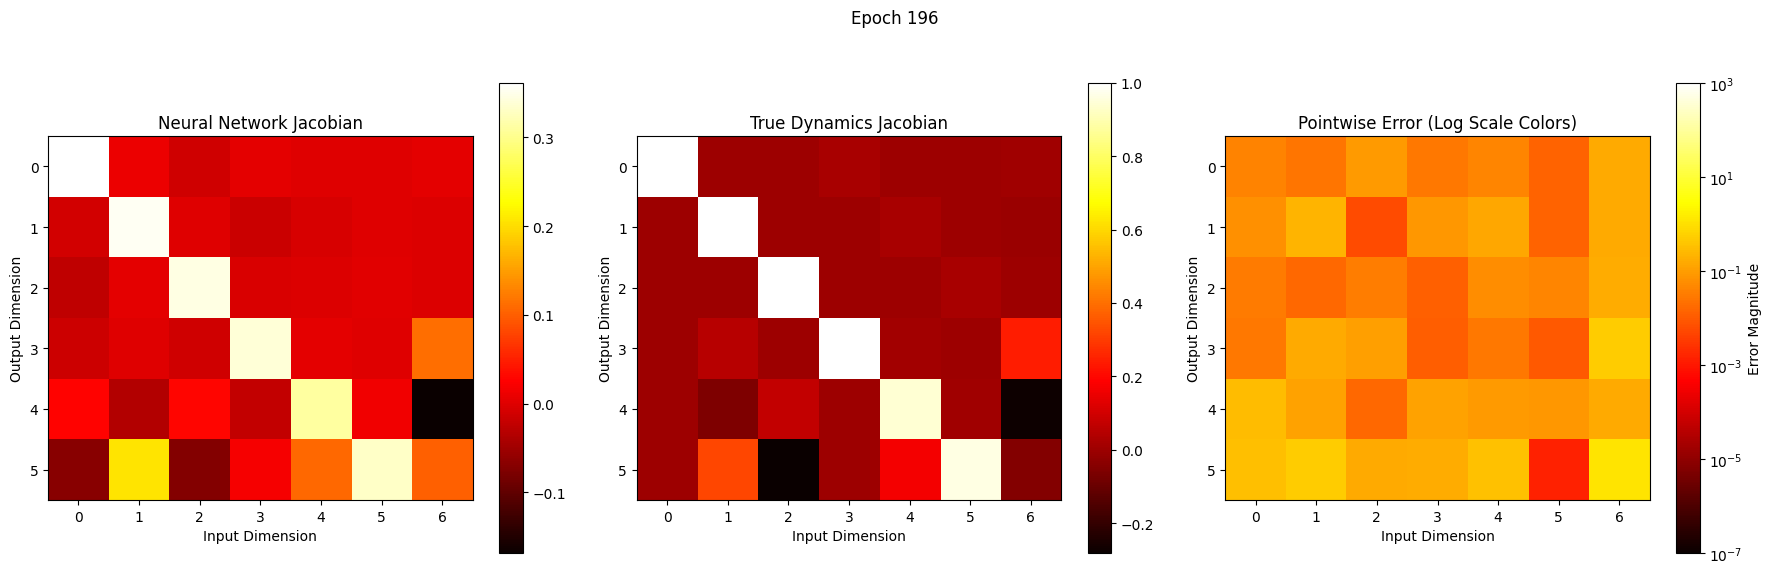

Epoch 197/200 complete: Avg Prediction Loss = 0.0164, Avg Alignment Loss = 0.0174, Total Batches Processed = 47
Epoch 198/200 complete: Avg Prediction Loss = 0.0158, Avg Alignment Loss = 0.0177, Total Batches Processed = 47
Epoch 199/200 complete: Avg Prediction Loss = 0.0170, Avg Alignment Loss = 0.0154, Total Batches Processed = 47
Epoch 200/200 complete: Avg Prediction Loss = 0.0172, Avg Alignment Loss = 0.0180, Total Batches Processed = 47
Both models training completed.


In [77]:
import brax
from brax import envs
import jax
import jax.numpy as jnp
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.colors import LogNorm
# Set up the Brax environment and wrap it in a Gym-like interface
#env = BraxToGymWrapper("half_cheetah")
state_dim = 6
action_dim =1

# Define the FCN model architecture
class NextStatePredictor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 256)                    # Second hidden layer
        self.fc3 = nn.Linear(256, 256)                    # Third hidden layer (new)
        self.fc4 = nn.Linear(256, 256)                    # Fourth hidden layer (new)
        self.fc5 = nn.Linear(256, 256)                    # Fifth hidden layer (new)
        self.fc6 = nn.Linear(256, state_dim)              # Output layer

    def forward(self, s, a):
        x = torch.cat((s, a), dim=-1)
        x = torch.relu(self.fc1(x))  # Activation function for the first layer
        #x = torch.relu(self.fc2(x))  # Activation function for the second layer
        #x = torch.relu(self.fc3(x))  # Activation function for the third layer
        #x = torch.relu(self.fc4(x))  # Activation function for the fourth layer
        #x = torch.relu(self.fc5(x))  # Activation function for the fifth layer
        x = self.fc6(x)              # No activation on the final layer to output the next state directly
        return x

# Implement the Jacobian alignment loss function
def compute_jacobian_alignment_loss(model, s, a, true_jacobian, device='cuda'):
    s = s.requires_grad_(True).to(device)
    a = a.requires_grad_(True).to(device)

    def model_outputs(s, a):
        return model(s, a)

    # Compute the Jacobian using the correct function signature
    model_jacobian = torch.autograd.functional.jacobian(model_outputs, (s, a), vectorize=True, create_graph=True)
    #print("Model Jacobian shape:", model_jacobian[0].shape)  # Depending on the output, adjust indexing
    #print("Model Jacobian shape:", model_jacobian[1].shape)  # Depending on the output, adjust indexing

    # Jacobian now has size: {batch_dim, output, batch_dim, input}
    model_jacobian = torch.cat((model_jacobian[0], model_jacobian[1]), dim=3)
    #print("Combined Model Jacobian shape:", model_jacobian.shape)

    # Jacobian now has size: {batch_dim, output, input}
    model_jacobian = torch.sum(model_jacobian, dim=2)
    #rint("Reduced Model Jacobian shape:", model_jacobian.shape)

    true_jacobian = true_jacobian.to(device)
    #print("True Jacobian shape:", true_jacobian.shape)
    #print(model_jacobian[0].shape)
    #print(true_jacobian.shape)

    # Min-Max scaling of the Jacobians
    def scaleJ(jacobian):
        # Compute the minimum and maximum values for each dimension
        min_value = torch.min(jacobian)
        max_value = torch.max(jacobian)
        return (jacobian - min_value) / (max_value - min_value) * 2 - 1

    # def scaleJ(tensor):
    #     # Compute the mean and standard deviation for each dimension
    #     # z_score_normalize
    #     mean = tensor.mean(dim=0, keepdim=True)
    #     std = tensor.std(dim=0, keepdim=True) + 1e-6  # Adding a small epsilon to avoid division by zero
    #     return (tensor - mean) / std

    model_jacobian = scaleJ(model_jacobian)
    true_jacobian = scaleJ(true_jacobian)


    loss = torch.nn.functional.mse_loss(model_jacobian, true_jacobian)
    return loss



def create_dataloader(states, actions, jacobians, next_states, batch_size=64):
    dataset = TensorDataset(states, actions, jacobians, next_states)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
# Training loop
def train(model, loss_type, num_epochs, dataloader, state_dim=6, action_dim=1):
    print(f"Training {loss_type} model...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    prediction_losses = []
    alignment_losses = []

    for epoch in range(num_epochs):
        epoch_prediction_losses = []
        epoch_alignment_losses = []

        for states, actions, jacobians, next_states in dataloader:
            optimizer.zero_grad()

            states, actions, jacobians, next_states = states.to('cuda'), actions.to('cuda'), jacobians.to('cuda'), next_states.to('cuda')

            predictions = model(states, actions)
            prediction_loss = nn.MSELoss()(predictions, next_states)
            alignment_loss = compute_jacobian_alignment_loss(model, states, actions, jacobians)

            if loss_type == 'prediction':
                total_loss = prediction_loss
            elif loss_type == 'alignment':
                total_loss = alignment_loss
            else:
                total_loss = prediction_loss + alignment_loss

            total_loss.backward()
            optimizer.step()

            epoch_prediction_losses.append(prediction_loss.item())
            epoch_alignment_losses.append(alignment_loss.item())

        # Average losses for the epoch
        avg_pred_loss = sum(epoch_prediction_losses) / len(epoch_prediction_losses)
        avg_align_loss = sum(epoch_alignment_losses) / len(epoch_alignment_losses)

        # Print comprehensive training progress update
        print(f"Epoch {epoch + 1}/{num_epochs} complete: Avg Prediction Loss = {avg_pred_loss:.4f}, Avg Alignment Loss = {avg_align_loss:.4f}, Total Batches Processed = {len(epoch_prediction_losses)}")

        # Append average losses to track trends over epochs
        prediction_losses.append(avg_pred_loss)
        alignment_losses.append(avg_align_loss)
        if epoch % 15 == 0:
          # Plot Jacobians after each epoch
          with torch.no_grad():
              # Select a random batch from the dataloader
              states, actions, jacobians, _ = next(iter(dataloader))
              states, actions, jacobians = states.to('cuda'), actions.to('cuda'), jacobians.to('cuda')

              states = states[:3,:]
              actions = actions[:3,:]
              jacobians = jacobians[:3,:, :]
              print(f'Plotting the Jacobians During Training')
              print(f"States shape: {states.shape}")
              print(f"Actions shape: {actions.shape}")
              print(f"Jacobians shape: {jacobians.shape}")


              # Compute Jacobian for the neural network
              def model_fn(x):
                  return model(x[:, :state_dim], x[:, state_dim:])

              combined_input = torch.cat((states, actions), dim=1)
              nn_jacobian = torch.autograd.functional.jacobian(model_fn, combined_input)

              print(f"nn_jacobian shape: {nn_jacobian.shape}")
              print(f"jacobians shape: {np.shape(jacobians)}")
              # Reshape and average Jacobians
              nn_jacobian_mean = nn_jacobian.mean(dim=[0, 2]).reshape(state_dim, state_dim + action_dim).cpu()
              true_jacobian_mean = jacobians.mean(dim=0).cpu()

              # Plot Jacobians and their error
              fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
              fig.suptitle(f'Epoch {epoch + 1}')

              im1 = ax1.imshow(nn_jacobian_mean, cmap='hot', interpolation='nearest')
              ax1.set_title('Neural Network Jacobian')
              ax1.set_xlabel('Input Dimension')
              ax1.set_ylabel('Output Dimension')
              fig.colorbar(im1, ax=ax1)

              im2 = ax2.imshow(true_jacobian_mean, cmap='hot', interpolation='nearest')
              ax2.set_title('True Dynamics Jacobian')
              ax2.set_xlabel('Input Dimension')
              ax2.set_ylabel('Output Dimension')
              fig.colorbar(im2, ax=ax2)

              def scaleJ(tensor):
                  # Compute the mean and standard deviation for each dimension
                  # z_score_normalize
                  mean = tensor.mean(dim=0, keepdim=True)
                  std = tensor.std(dim=0, keepdim=True) + 1e-6  # Adding a small epsilon to avoid division by zero
                  return (tensor - mean) / std

              nn_jacobian_mean = scaleJ(nn_jacobian_mean).cpu()
              true_jacobian_mean =    scaleJ(true_jacobian_mean).cpu()

              error_matrix = torch.abs(nn_jacobian_mean - true_jacobian_mean)
              im3 = ax3.imshow(error_matrix, norm=LogNorm(vmin=1e-7, vmax=1e3), cmap='hot', interpolation='nearest')
              ax3.set_title('Pointwise Error (Log Scale Colors)')
              ax3.set_xlabel('Input Dimension')
              ax3.set_ylabel('Output Dimension')
              cbar = fig.colorbar(im3, ax=ax3)
              cbar.set_label('Error Magnitude')

              plt.tight_layout(rect=[0, 0.03, 1, 0.95])
              plt.show()

    return model, prediction_losses, alignment_losses

# Train models
num_epochs = 200
dataloader = create_dataloader(states_tensor, actions_tensor, jacobians_tensor, next_states_tensor, batch_size=64)


# model_pred = NextStatePredictor(state_dim, action_dim).to(device)
# model_pred, prediction_losses_pred, alignment_losses_pred = train(model_pred, 'prediction', num_epochs, dataloader)
# print("Prediction model training completed.")

model_align = NextStatePredictor(state_dim, action_dim).to(device)
model_align, prediction_losses_align, alignment_losses_align = train(model_align, 'alignment', num_epochs, dataloader)
print("Alignment model training completed.")

model_both = NextStatePredictor(state_dim, action_dim).to(device)
model_both, prediction_losses_both, alignment_losses_both = train(model_both, 'both', num_epochs, dataloader)
print("Both models training completed.")



Training prediction model...
Epoch 1/200 complete: Avg Prediction Loss = 2.0391, Avg Alignment Loss = 0.1306, Total Batches Processed = 47
Plotting the Jacobians During Training
States shape: torch.Size([3, 6])
Actions shape: torch.Size([3, 1])
Jacobians shape: torch.Size([3, 6, 7])
nn_jacobian shape: torch.Size([3, 6, 3, 7])
jacobians shape: torch.Size([3, 6, 7])


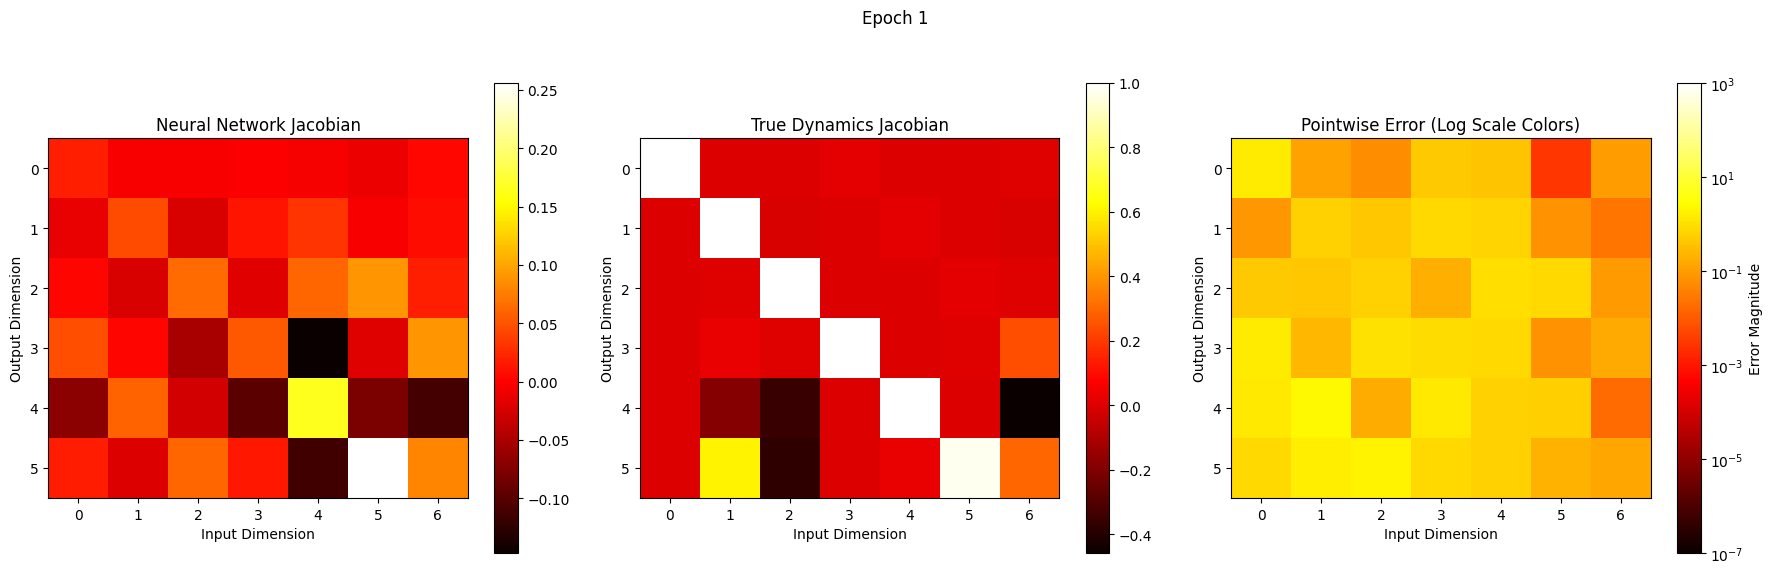

Epoch 2/200 complete: Avg Prediction Loss = 0.3470, Avg Alignment Loss = 0.1001, Total Batches Processed = 47
Epoch 3/200 complete: Avg Prediction Loss = 0.2455, Avg Alignment Loss = 0.0746, Total Batches Processed = 47
Epoch 4/200 complete: Avg Prediction Loss = 0.2226, Avg Alignment Loss = 0.0666, Total Batches Processed = 47
Epoch 5/200 complete: Avg Prediction Loss = 0.2075, Avg Alignment Loss = 0.0649, Total Batches Processed = 47
Epoch 6/200 complete: Avg Prediction Loss = 0.1943, Avg Alignment Loss = 0.0611, Total Batches Processed = 47
Epoch 7/200 complete: Avg Prediction Loss = 0.1855, Avg Alignment Loss = 0.0600, Total Batches Processed = 47
Epoch 8/200 complete: Avg Prediction Loss = 0.1755, Avg Alignment Loss = 0.0602, Total Batches Processed = 47
Epoch 9/200 complete: Avg Prediction Loss = 0.1672, Avg Alignment Loss = 0.0582, Total Batches Processed = 47
Epoch 10/200 complete: Avg Prediction Loss = 0.1611, Avg Alignment Loss = 0.0586, Total Batches Processed = 47
Epoch 11/

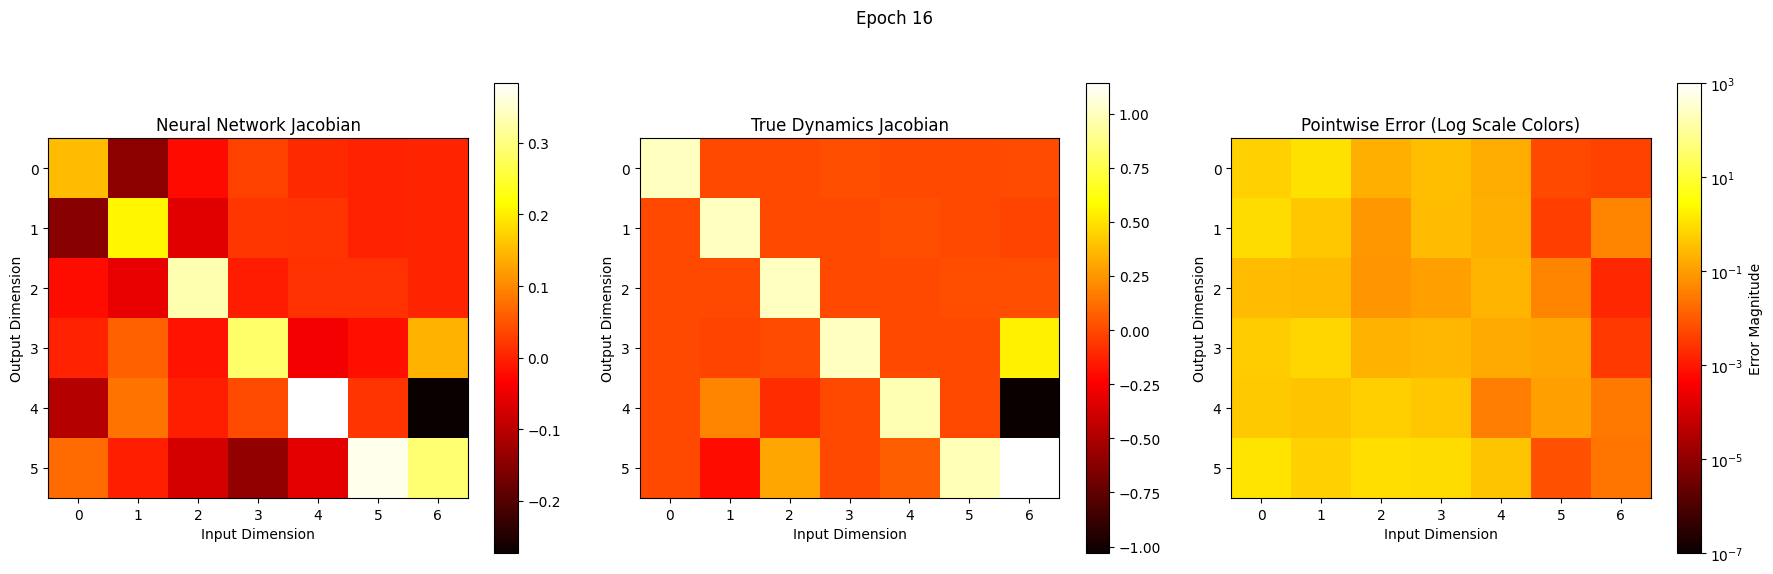

Epoch 17/200 complete: Avg Prediction Loss = 0.1127, Avg Alignment Loss = 0.0411, Total Batches Processed = 47
Epoch 18/200 complete: Avg Prediction Loss = 0.1077, Avg Alignment Loss = 0.0390, Total Batches Processed = 47
Epoch 19/200 complete: Avg Prediction Loss = 0.1030, Avg Alignment Loss = 0.0371, Total Batches Processed = 47
Epoch 20/200 complete: Avg Prediction Loss = 0.0977, Avg Alignment Loss = 0.0356, Total Batches Processed = 47
Epoch 21/200 complete: Avg Prediction Loss = 0.0910, Avg Alignment Loss = 0.0346, Total Batches Processed = 47
Epoch 22/200 complete: Avg Prediction Loss = 0.0870, Avg Alignment Loss = 0.0337, Total Batches Processed = 47
Epoch 23/200 complete: Avg Prediction Loss = 0.0820, Avg Alignment Loss = 0.0346, Total Batches Processed = 47
Epoch 24/200 complete: Avg Prediction Loss = 0.0774, Avg Alignment Loss = 0.0334, Total Batches Processed = 47
Epoch 25/200 complete: Avg Prediction Loss = 0.0729, Avg Alignment Loss = 0.0317, Total Batches Processed = 47
E

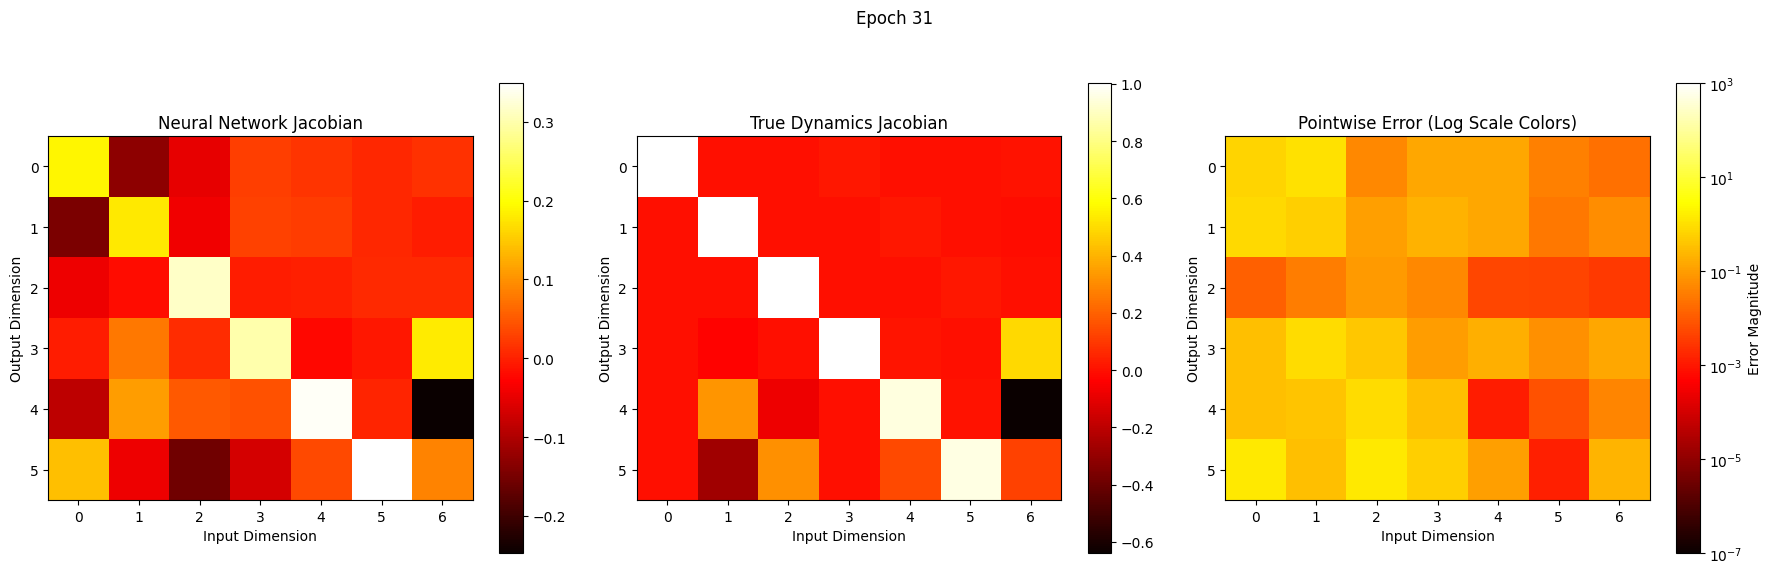

Epoch 32/200 complete: Avg Prediction Loss = 0.0539, Avg Alignment Loss = 0.0304, Total Batches Processed = 47
Epoch 33/200 complete: Avg Prediction Loss = 0.0524, Avg Alignment Loss = 0.0300, Total Batches Processed = 47
Epoch 34/200 complete: Avg Prediction Loss = 0.0518, Avg Alignment Loss = 0.0304, Total Batches Processed = 47
Epoch 35/200 complete: Avg Prediction Loss = 0.0494, Avg Alignment Loss = 0.0292, Total Batches Processed = 47
Epoch 36/200 complete: Avg Prediction Loss = 0.0471, Avg Alignment Loss = 0.0298, Total Batches Processed = 47
Epoch 37/200 complete: Avg Prediction Loss = 0.0462, Avg Alignment Loss = 0.0309, Total Batches Processed = 47
Epoch 38/200 complete: Avg Prediction Loss = 0.0452, Avg Alignment Loss = 0.0300, Total Batches Processed = 47
Epoch 39/200 complete: Avg Prediction Loss = 0.0437, Avg Alignment Loss = 0.0311, Total Batches Processed = 47
Epoch 40/200 complete: Avg Prediction Loss = 0.0430, Avg Alignment Loss = 0.0280, Total Batches Processed = 47
E

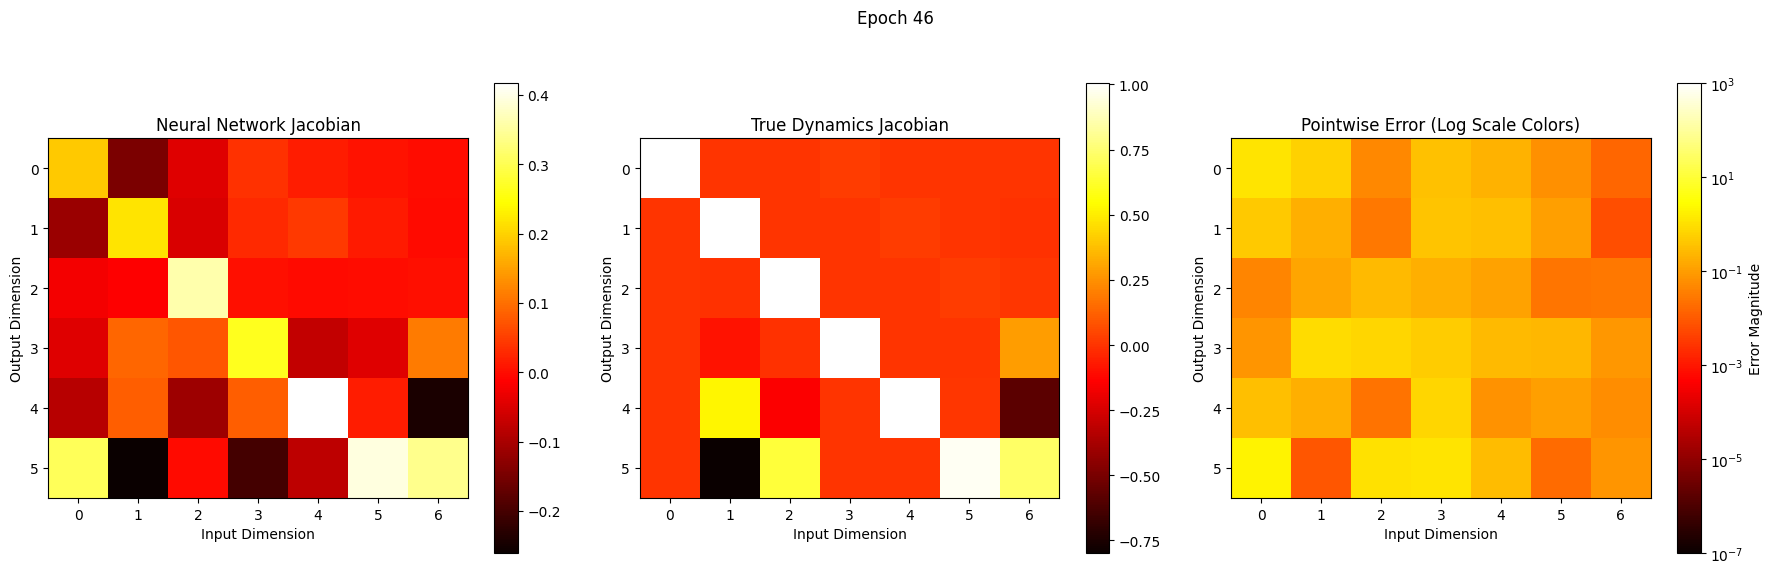

Epoch 47/200 complete: Avg Prediction Loss = 0.0373, Avg Alignment Loss = 0.0303, Total Batches Processed = 47
Epoch 48/200 complete: Avg Prediction Loss = 0.0368, Avg Alignment Loss = 0.0304, Total Batches Processed = 47
Epoch 49/200 complete: Avg Prediction Loss = 0.0358, Avg Alignment Loss = 0.0307, Total Batches Processed = 47
Epoch 50/200 complete: Avg Prediction Loss = 0.0333, Avg Alignment Loss = 0.0315, Total Batches Processed = 47
Epoch 51/200 complete: Avg Prediction Loss = 0.0347, Avg Alignment Loss = 0.0309, Total Batches Processed = 47
Epoch 52/200 complete: Avg Prediction Loss = 0.0337, Avg Alignment Loss = 0.0316, Total Batches Processed = 47
Epoch 53/200 complete: Avg Prediction Loss = 0.0319, Avg Alignment Loss = 0.0295, Total Batches Processed = 47
Epoch 54/200 complete: Avg Prediction Loss = 0.0318, Avg Alignment Loss = 0.0291, Total Batches Processed = 47
Epoch 55/200 complete: Avg Prediction Loss = 0.0321, Avg Alignment Loss = 0.0264, Total Batches Processed = 47
E

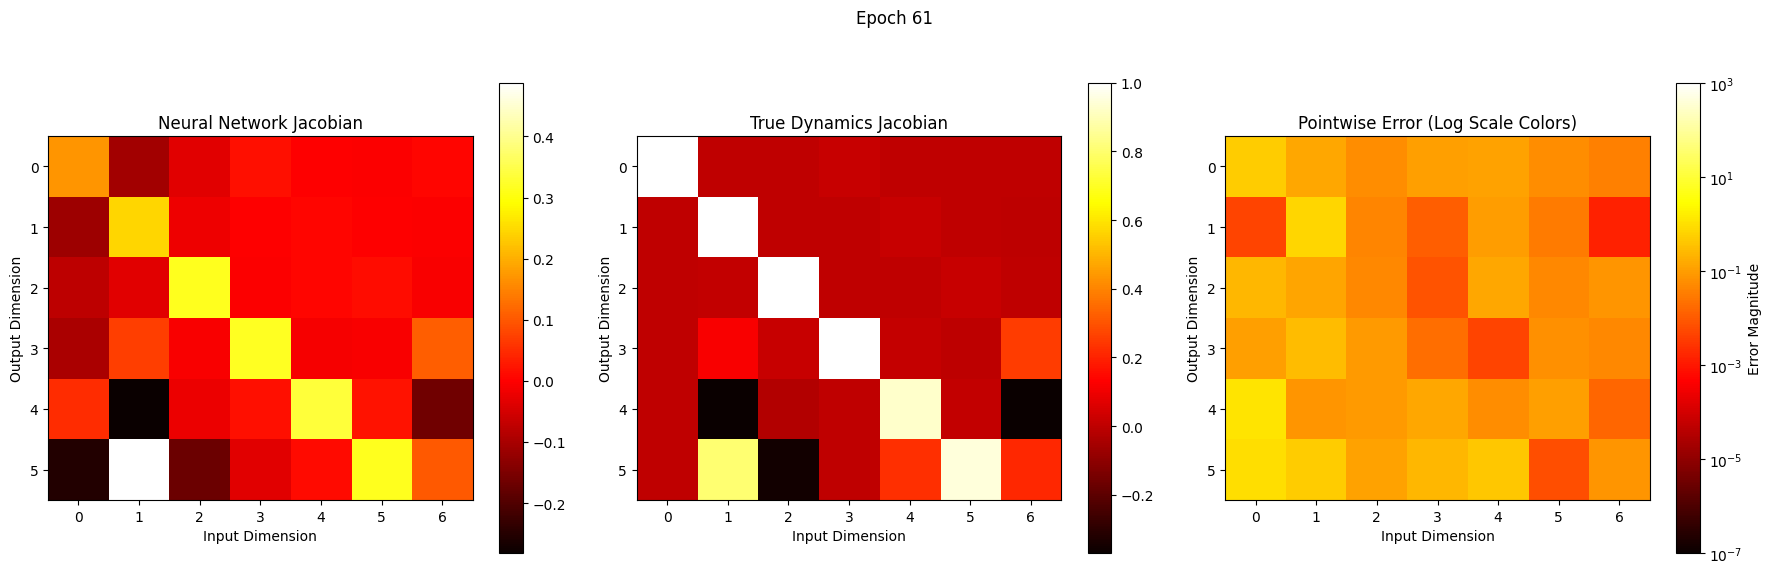

Epoch 62/200 complete: Avg Prediction Loss = 0.0280, Avg Alignment Loss = 0.0348, Total Batches Processed = 47
Epoch 63/200 complete: Avg Prediction Loss = 0.0274, Avg Alignment Loss = 0.0363, Total Batches Processed = 47
Epoch 64/200 complete: Avg Prediction Loss = 0.0280, Avg Alignment Loss = 0.0373, Total Batches Processed = 47
Epoch 65/200 complete: Avg Prediction Loss = 0.0269, Avg Alignment Loss = 0.0345, Total Batches Processed = 47
Epoch 66/200 complete: Avg Prediction Loss = 0.0262, Avg Alignment Loss = 0.0384, Total Batches Processed = 47
Epoch 67/200 complete: Avg Prediction Loss = 0.0263, Avg Alignment Loss = 0.0388, Total Batches Processed = 47
Epoch 68/200 complete: Avg Prediction Loss = 0.0256, Avg Alignment Loss = 0.0353, Total Batches Processed = 47
Epoch 69/200 complete: Avg Prediction Loss = 0.0262, Avg Alignment Loss = 0.0363, Total Batches Processed = 47
Epoch 70/200 complete: Avg Prediction Loss = 0.0250, Avg Alignment Loss = 0.0375, Total Batches Processed = 47
E

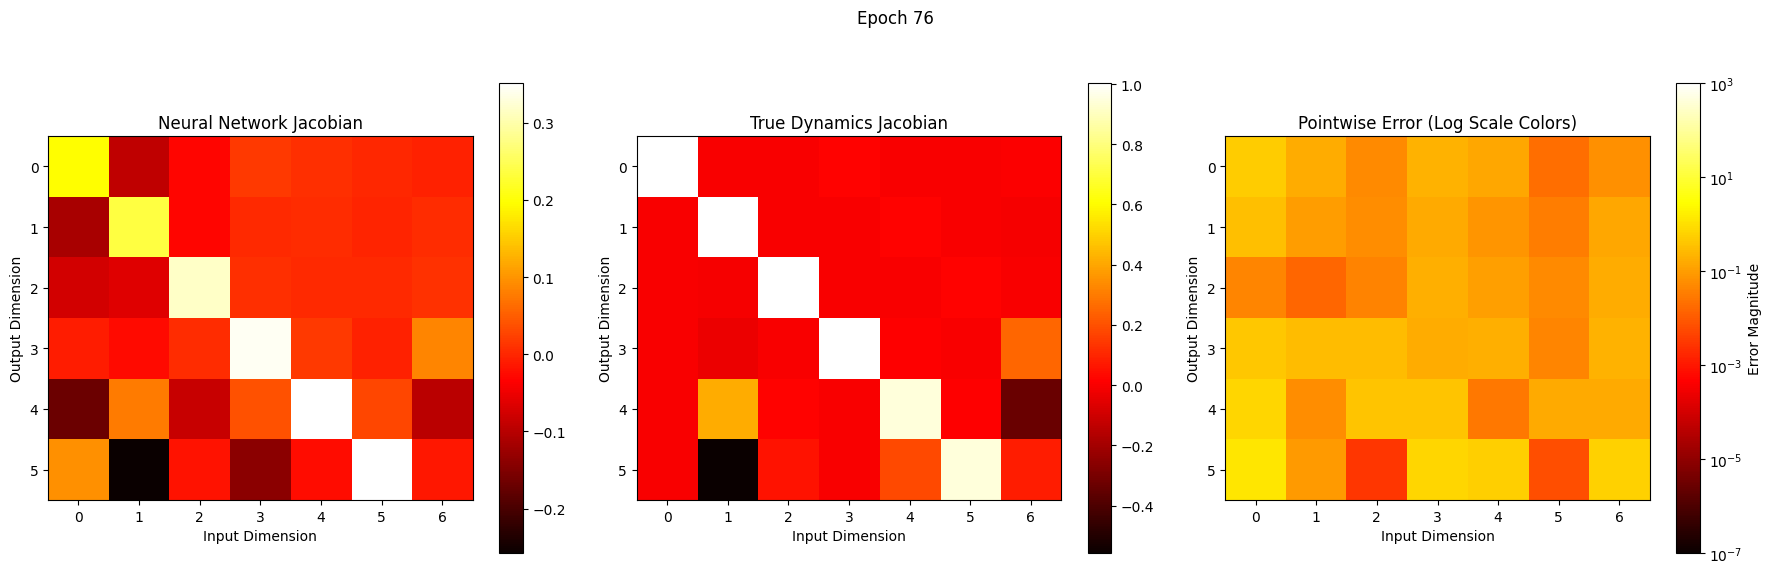

Epoch 77/200 complete: Avg Prediction Loss = 0.0226, Avg Alignment Loss = 0.0385, Total Batches Processed = 47
Epoch 78/200 complete: Avg Prediction Loss = 0.0229, Avg Alignment Loss = 0.0386, Total Batches Processed = 47
Epoch 79/200 complete: Avg Prediction Loss = 0.0238, Avg Alignment Loss = 0.0419, Total Batches Processed = 47
Epoch 80/200 complete: Avg Prediction Loss = 0.0228, Avg Alignment Loss = 0.0436, Total Batches Processed = 47
Epoch 81/200 complete: Avg Prediction Loss = 0.0219, Avg Alignment Loss = 0.0424, Total Batches Processed = 47
Epoch 82/200 complete: Avg Prediction Loss = 0.0228, Avg Alignment Loss = 0.0385, Total Batches Processed = 47
Epoch 83/200 complete: Avg Prediction Loss = 0.0218, Avg Alignment Loss = 0.0433, Total Batches Processed = 47
Epoch 84/200 complete: Avg Prediction Loss = 0.0225, Avg Alignment Loss = 0.0466, Total Batches Processed = 47
Epoch 85/200 complete: Avg Prediction Loss = 0.0215, Avg Alignment Loss = 0.0437, Total Batches Processed = 47
E

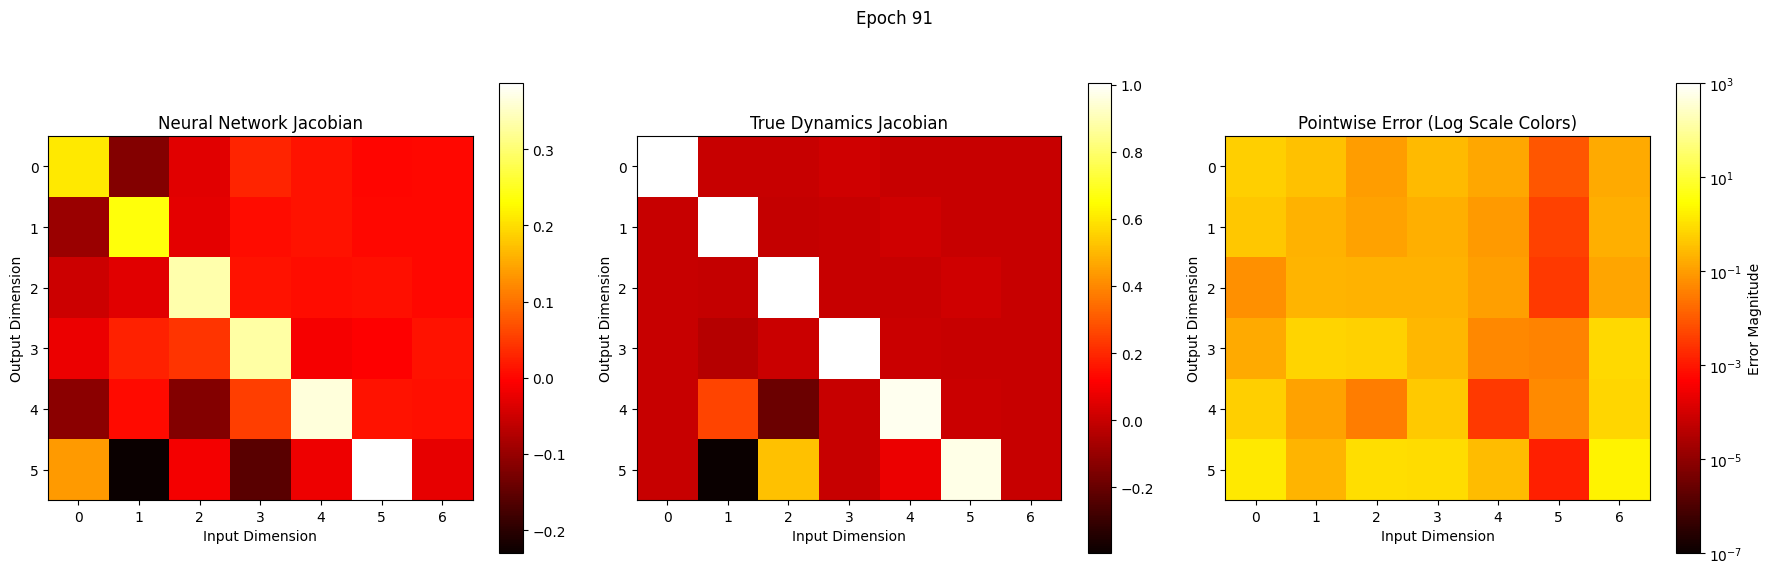

Epoch 92/200 complete: Avg Prediction Loss = 0.0204, Avg Alignment Loss = 0.0409, Total Batches Processed = 47
Epoch 93/200 complete: Avg Prediction Loss = 0.0200, Avg Alignment Loss = 0.0448, Total Batches Processed = 47
Epoch 94/200 complete: Avg Prediction Loss = 0.0207, Avg Alignment Loss = 0.0472, Total Batches Processed = 47
Epoch 95/200 complete: Avg Prediction Loss = 0.0200, Avg Alignment Loss = 0.0478, Total Batches Processed = 47
Epoch 96/200 complete: Avg Prediction Loss = 0.0202, Avg Alignment Loss = 0.0454, Total Batches Processed = 47
Epoch 97/200 complete: Avg Prediction Loss = 0.0204, Avg Alignment Loss = 0.0476, Total Batches Processed = 47
Epoch 98/200 complete: Avg Prediction Loss = 0.0200, Avg Alignment Loss = 0.0463, Total Batches Processed = 47
Epoch 99/200 complete: Avg Prediction Loss = 0.0189, Avg Alignment Loss = 0.0563, Total Batches Processed = 47
Epoch 100/200 complete: Avg Prediction Loss = 0.0197, Avg Alignment Loss = 0.0441, Total Batches Processed = 47


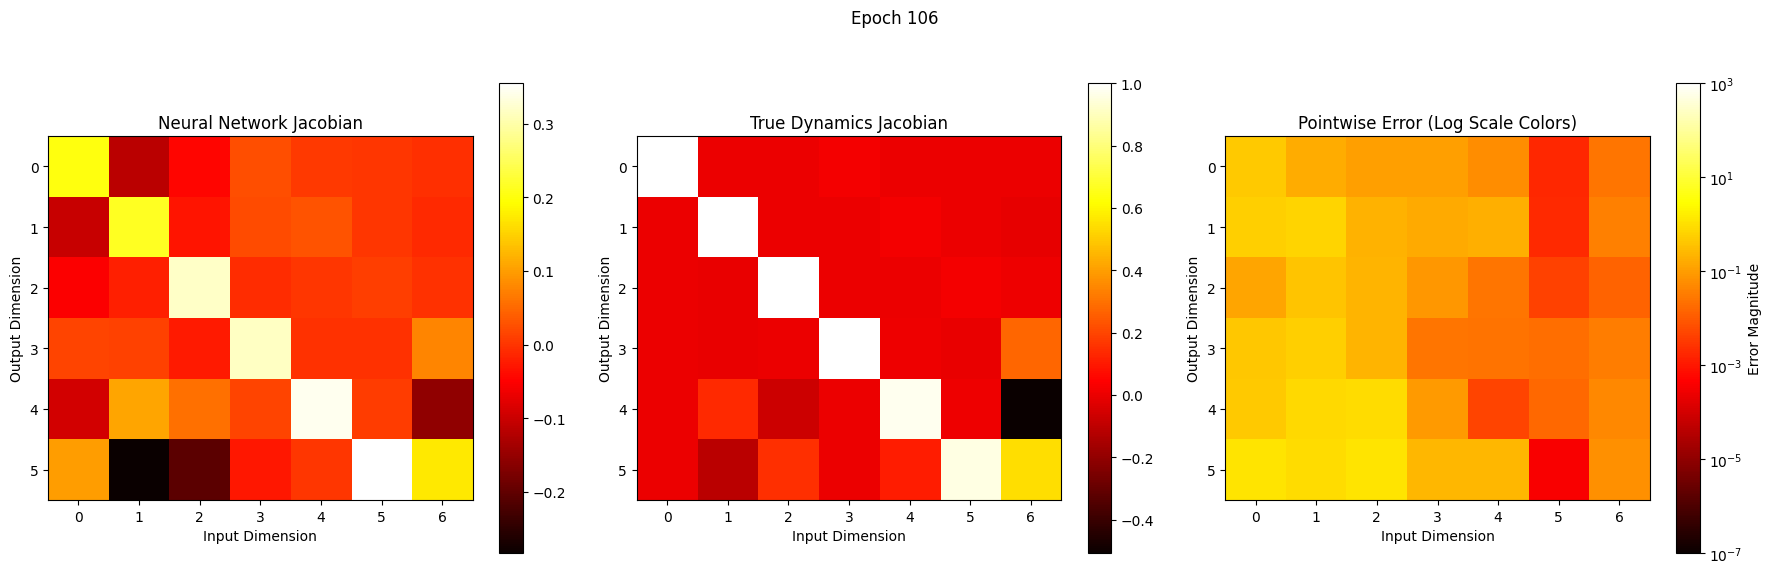

Epoch 107/200 complete: Avg Prediction Loss = 0.0188, Avg Alignment Loss = 0.0494, Total Batches Processed = 47
Epoch 108/200 complete: Avg Prediction Loss = 0.0180, Avg Alignment Loss = 0.0513, Total Batches Processed = 47
Epoch 109/200 complete: Avg Prediction Loss = 0.0182, Avg Alignment Loss = 0.0491, Total Batches Processed = 47
Epoch 110/200 complete: Avg Prediction Loss = 0.0183, Avg Alignment Loss = 0.0571, Total Batches Processed = 47
Epoch 111/200 complete: Avg Prediction Loss = 0.0181, Avg Alignment Loss = 0.0503, Total Batches Processed = 47
Epoch 112/200 complete: Avg Prediction Loss = 0.0177, Avg Alignment Loss = 0.0518, Total Batches Processed = 47
Epoch 113/200 complete: Avg Prediction Loss = 0.0172, Avg Alignment Loss = 0.0502, Total Batches Processed = 47
Epoch 114/200 complete: Avg Prediction Loss = 0.0168, Avg Alignment Loss = 0.0540, Total Batches Processed = 47
Epoch 115/200 complete: Avg Prediction Loss = 0.0174, Avg Alignment Loss = 0.0570, Total Batches Process

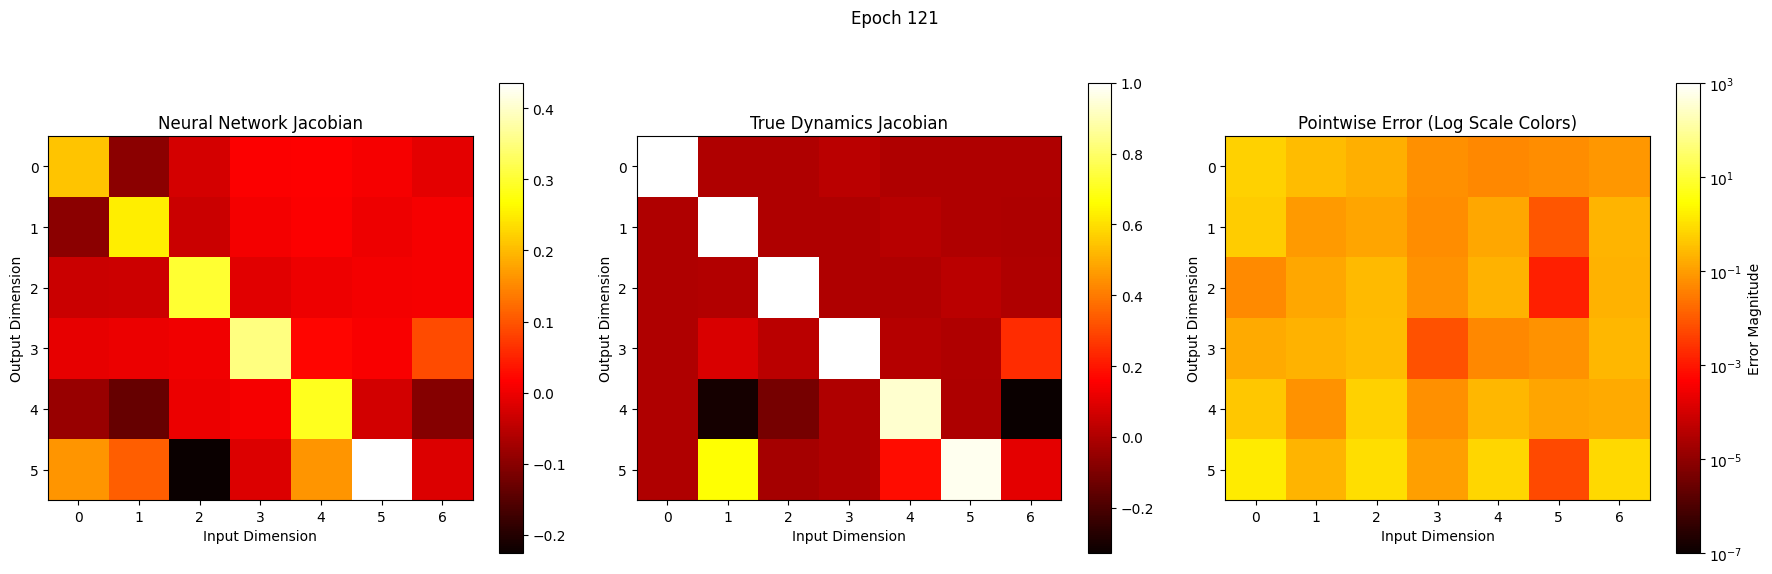

Epoch 122/200 complete: Avg Prediction Loss = 0.0173, Avg Alignment Loss = 0.0500, Total Batches Processed = 47
Epoch 123/200 complete: Avg Prediction Loss = 0.0170, Avg Alignment Loss = 0.0520, Total Batches Processed = 47
Epoch 124/200 complete: Avg Prediction Loss = 0.0169, Avg Alignment Loss = 0.0512, Total Batches Processed = 47
Epoch 125/200 complete: Avg Prediction Loss = 0.0159, Avg Alignment Loss = 0.0522, Total Batches Processed = 47
Epoch 126/200 complete: Avg Prediction Loss = 0.0157, Avg Alignment Loss = 0.0501, Total Batches Processed = 47
Epoch 127/200 complete: Avg Prediction Loss = 0.0161, Avg Alignment Loss = 0.0487, Total Batches Processed = 47
Epoch 128/200 complete: Avg Prediction Loss = 0.0177, Avg Alignment Loss = 0.0517, Total Batches Processed = 47
Epoch 129/200 complete: Avg Prediction Loss = 0.0166, Avg Alignment Loss = 0.0530, Total Batches Processed = 47
Epoch 130/200 complete: Avg Prediction Loss = 0.0161, Avg Alignment Loss = 0.0530, Total Batches Process

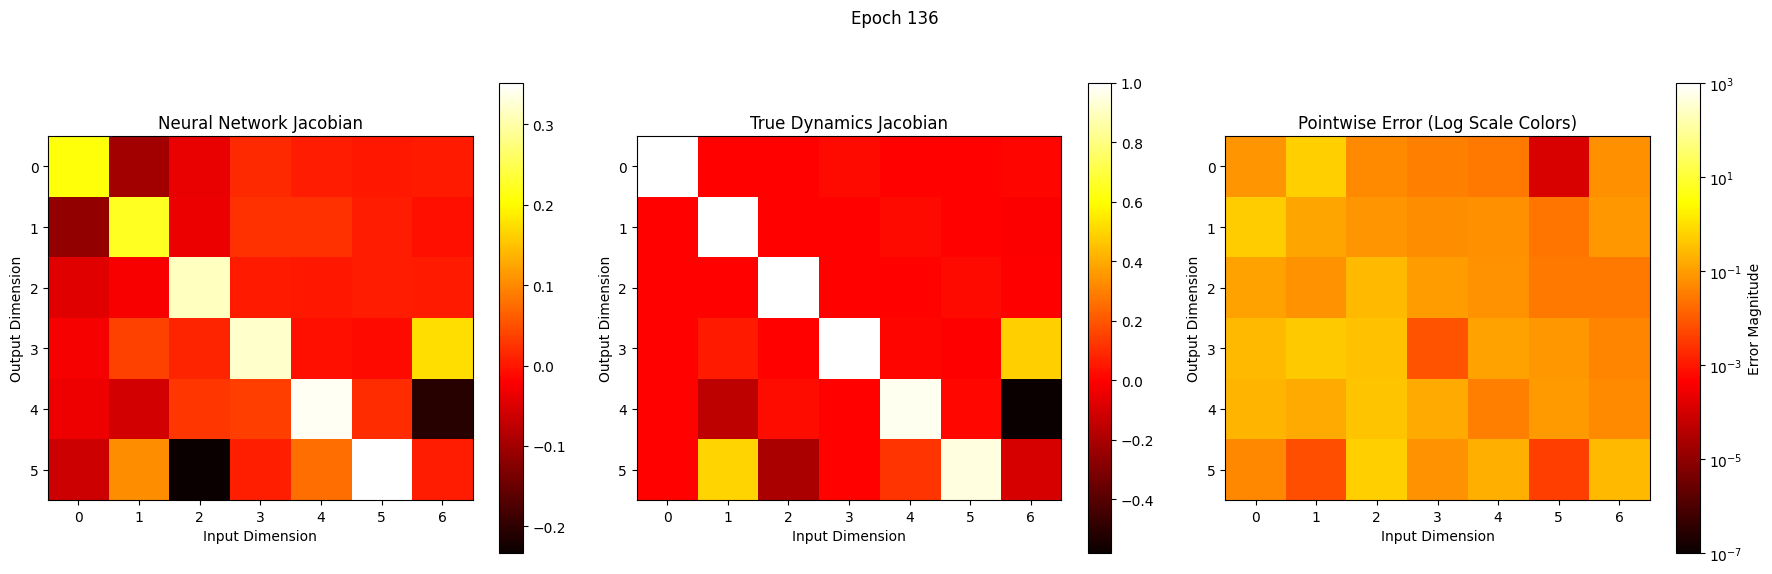

Epoch 137/200 complete: Avg Prediction Loss = 0.0148, Avg Alignment Loss = 0.0497, Total Batches Processed = 47
Epoch 138/200 complete: Avg Prediction Loss = 0.0156, Avg Alignment Loss = 0.0573, Total Batches Processed = 47
Epoch 139/200 complete: Avg Prediction Loss = 0.0153, Avg Alignment Loss = 0.0538, Total Batches Processed = 47
Epoch 140/200 complete: Avg Prediction Loss = 0.0153, Avg Alignment Loss = 0.0539, Total Batches Processed = 47
Epoch 141/200 complete: Avg Prediction Loss = 0.0152, Avg Alignment Loss = 0.0561, Total Batches Processed = 47
Epoch 142/200 complete: Avg Prediction Loss = 0.0149, Avg Alignment Loss = 0.0569, Total Batches Processed = 47
Epoch 143/200 complete: Avg Prediction Loss = 0.0156, Avg Alignment Loss = 0.0581, Total Batches Processed = 47
Epoch 144/200 complete: Avg Prediction Loss = 0.0144, Avg Alignment Loss = 0.0588, Total Batches Processed = 47
Epoch 145/200 complete: Avg Prediction Loss = 0.0154, Avg Alignment Loss = 0.0572, Total Batches Process

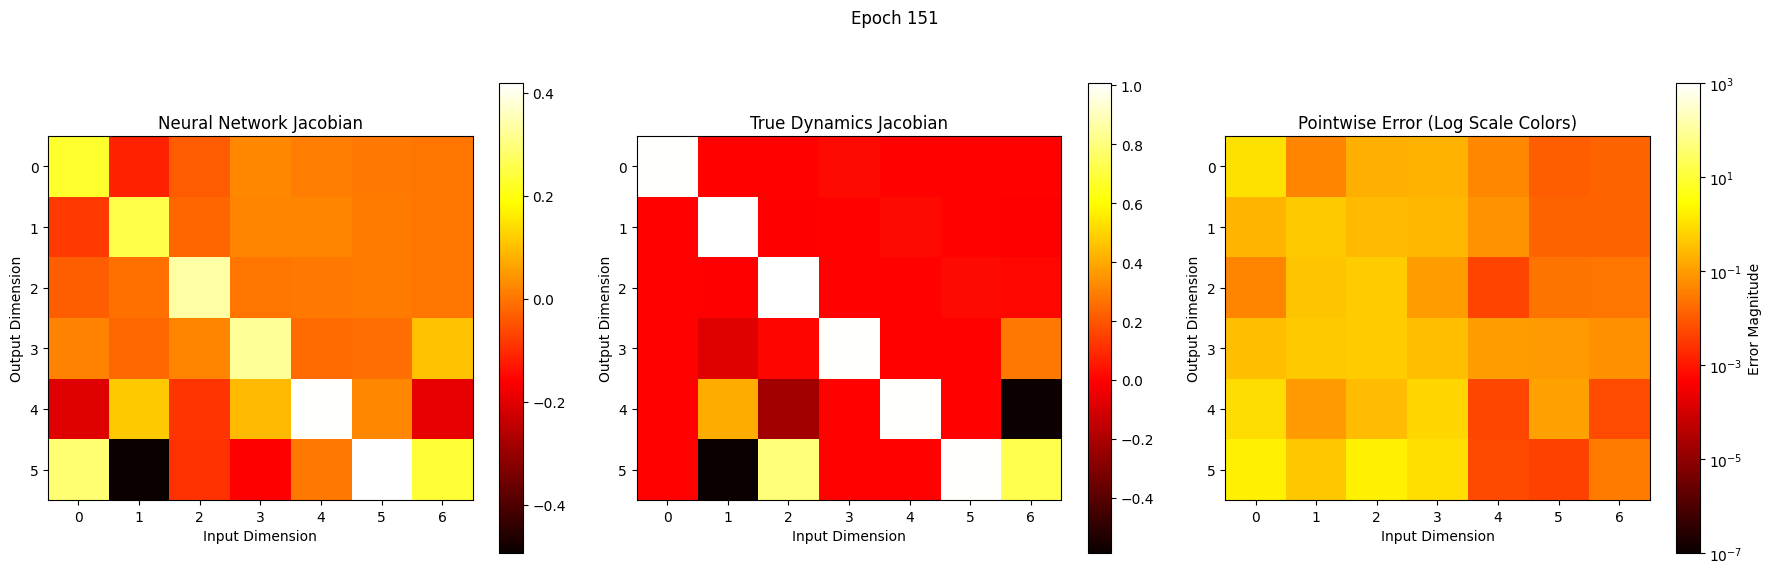

Epoch 152/200 complete: Avg Prediction Loss = 0.0144, Avg Alignment Loss = 0.0615, Total Batches Processed = 47
Epoch 153/200 complete: Avg Prediction Loss = 0.0148, Avg Alignment Loss = 0.0592, Total Batches Processed = 47
Epoch 154/200 complete: Avg Prediction Loss = 0.0149, Avg Alignment Loss = 0.0624, Total Batches Processed = 47
Epoch 155/200 complete: Avg Prediction Loss = 0.0143, Avg Alignment Loss = 0.0629, Total Batches Processed = 47
Epoch 156/200 complete: Avg Prediction Loss = 0.0140, Avg Alignment Loss = 0.0639, Total Batches Processed = 47
Epoch 157/200 complete: Avg Prediction Loss = 0.0158, Avg Alignment Loss = 0.0667, Total Batches Processed = 47
Epoch 158/200 complete: Avg Prediction Loss = 0.0137, Avg Alignment Loss = 0.0597, Total Batches Processed = 47
Epoch 159/200 complete: Avg Prediction Loss = 0.0153, Avg Alignment Loss = 0.0717, Total Batches Processed = 47
Epoch 160/200 complete: Avg Prediction Loss = 0.0132, Avg Alignment Loss = 0.0642, Total Batches Process

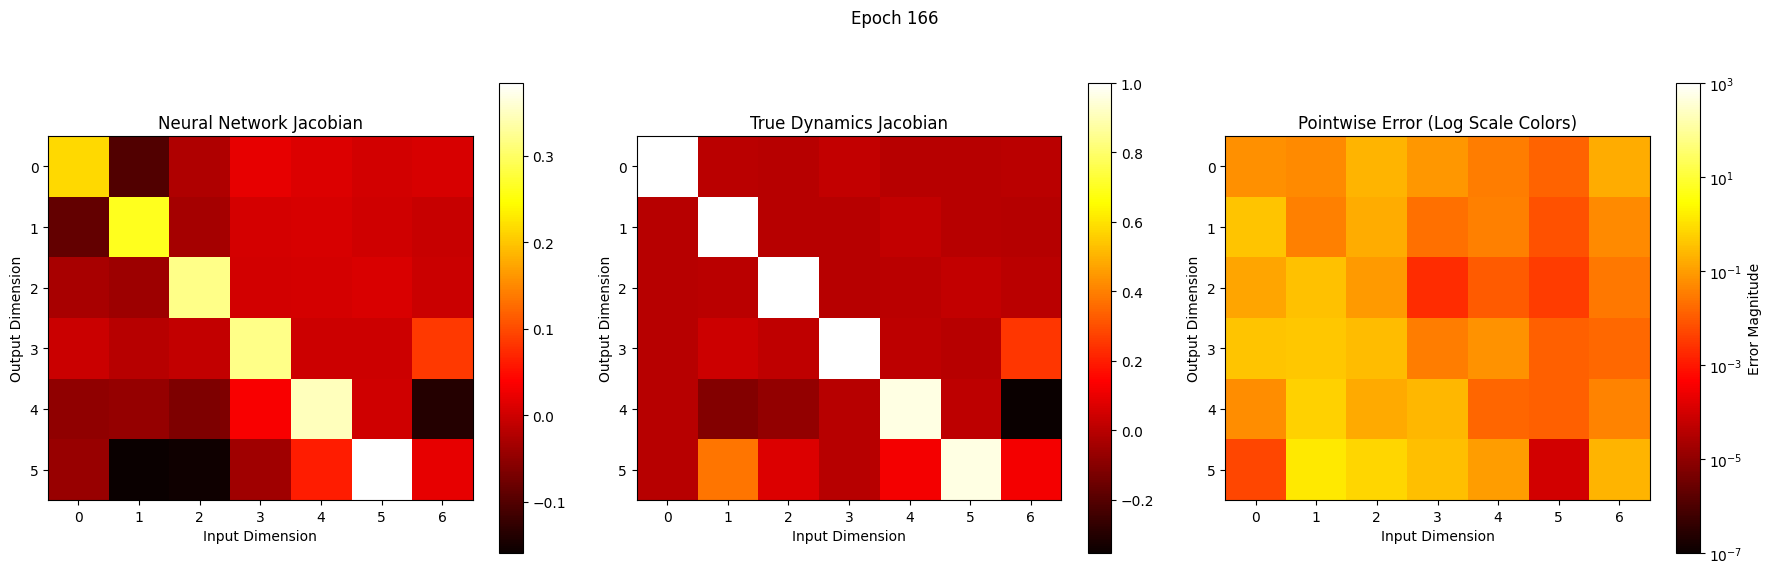

Epoch 167/200 complete: Avg Prediction Loss = 0.0144, Avg Alignment Loss = 0.0659, Total Batches Processed = 47
Epoch 168/200 complete: Avg Prediction Loss = 0.0131, Avg Alignment Loss = 0.0667, Total Batches Processed = 47
Epoch 169/200 complete: Avg Prediction Loss = 0.0132, Avg Alignment Loss = 0.0645, Total Batches Processed = 47
Epoch 170/200 complete: Avg Prediction Loss = 0.0133, Avg Alignment Loss = 0.0637, Total Batches Processed = 47
Epoch 171/200 complete: Avg Prediction Loss = 0.0137, Avg Alignment Loss = 0.0659, Total Batches Processed = 47
Epoch 172/200 complete: Avg Prediction Loss = 0.0134, Avg Alignment Loss = 0.0752, Total Batches Processed = 47
Epoch 173/200 complete: Avg Prediction Loss = 0.0137, Avg Alignment Loss = 0.0652, Total Batches Processed = 47
Epoch 174/200 complete: Avg Prediction Loss = 0.0133, Avg Alignment Loss = 0.0665, Total Batches Processed = 47
Epoch 175/200 complete: Avg Prediction Loss = 0.0138, Avg Alignment Loss = 0.0645, Total Batches Process

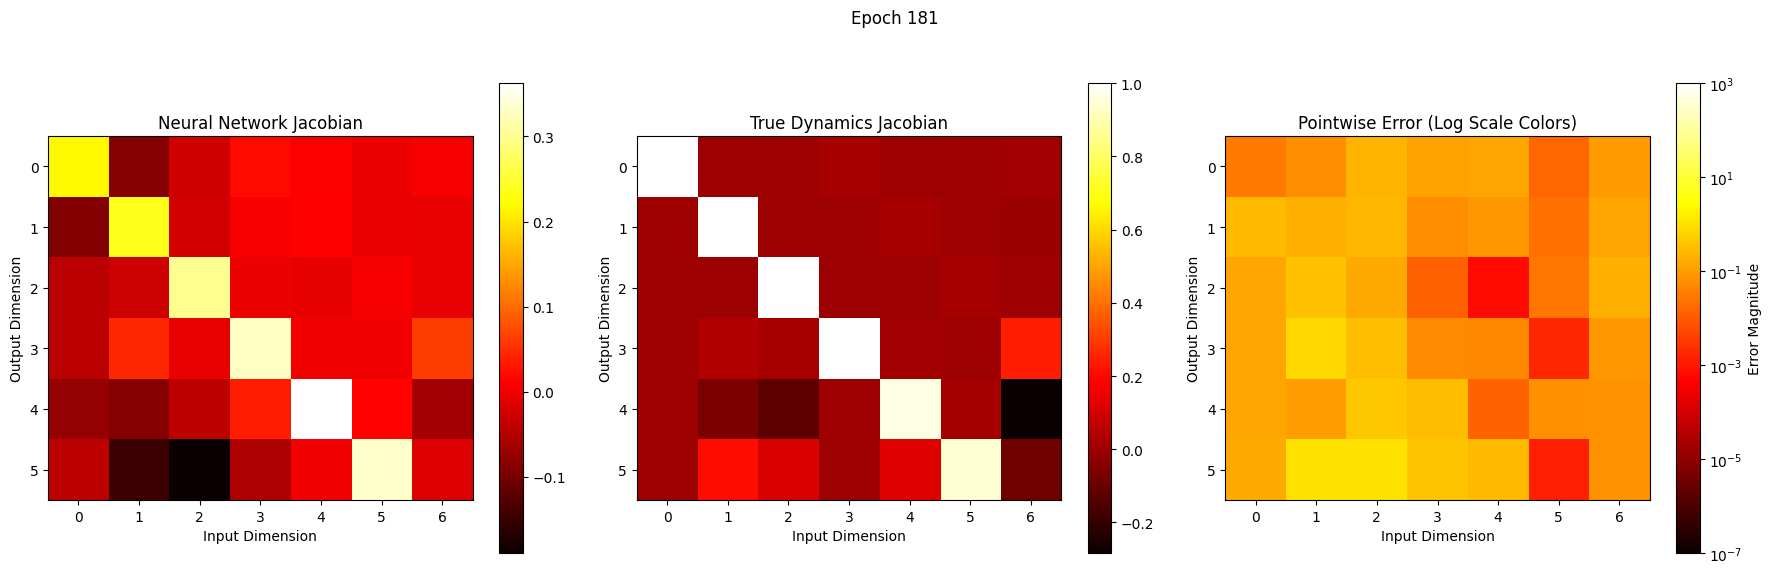

Epoch 182/200 complete: Avg Prediction Loss = 0.0127, Avg Alignment Loss = 0.0706, Total Batches Processed = 47
Epoch 183/200 complete: Avg Prediction Loss = 0.0130, Avg Alignment Loss = 0.0705, Total Batches Processed = 47
Epoch 184/200 complete: Avg Prediction Loss = 0.0138, Avg Alignment Loss = 0.0692, Total Batches Processed = 47
Epoch 185/200 complete: Avg Prediction Loss = 0.0129, Avg Alignment Loss = 0.0728, Total Batches Processed = 47
Epoch 186/200 complete: Avg Prediction Loss = 0.0129, Avg Alignment Loss = 0.0737, Total Batches Processed = 47
Epoch 187/200 complete: Avg Prediction Loss = 0.0128, Avg Alignment Loss = 0.0650, Total Batches Processed = 47
Epoch 188/200 complete: Avg Prediction Loss = 0.0125, Avg Alignment Loss = 0.0704, Total Batches Processed = 47
Epoch 189/200 complete: Avg Prediction Loss = 0.0131, Avg Alignment Loss = 0.0710, Total Batches Processed = 47
Epoch 190/200 complete: Avg Prediction Loss = 0.0121, Avg Alignment Loss = 0.0757, Total Batches Process

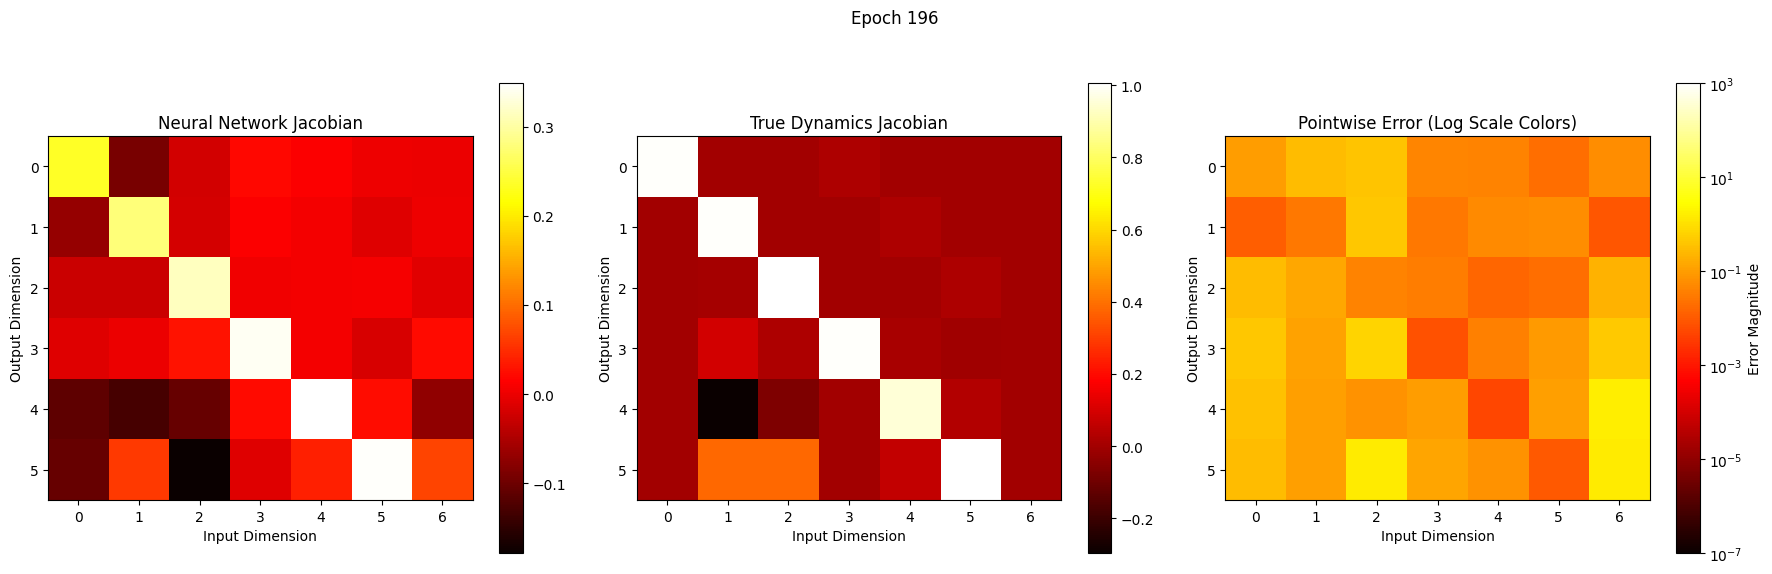

Epoch 197/200 complete: Avg Prediction Loss = 0.0128, Avg Alignment Loss = 0.0724, Total Batches Processed = 47
Epoch 198/200 complete: Avg Prediction Loss = 0.0122, Avg Alignment Loss = 0.0763, Total Batches Processed = 47
Epoch 199/200 complete: Avg Prediction Loss = 0.0114, Avg Alignment Loss = 0.0726, Total Batches Processed = 47
Epoch 200/200 complete: Avg Prediction Loss = 0.0122, Avg Alignment Loss = 0.0774, Total Batches Processed = 47
Prediction model training completed.


In [78]:
model_pred = NextStatePredictor(state_dim, action_dim).to(device)
model_pred, prediction_losses_pred, alignment_losses_pred = train(model_pred, 'prediction', num_epochs, dataloader)
print("Prediction model training completed.")


In [ ]:
d

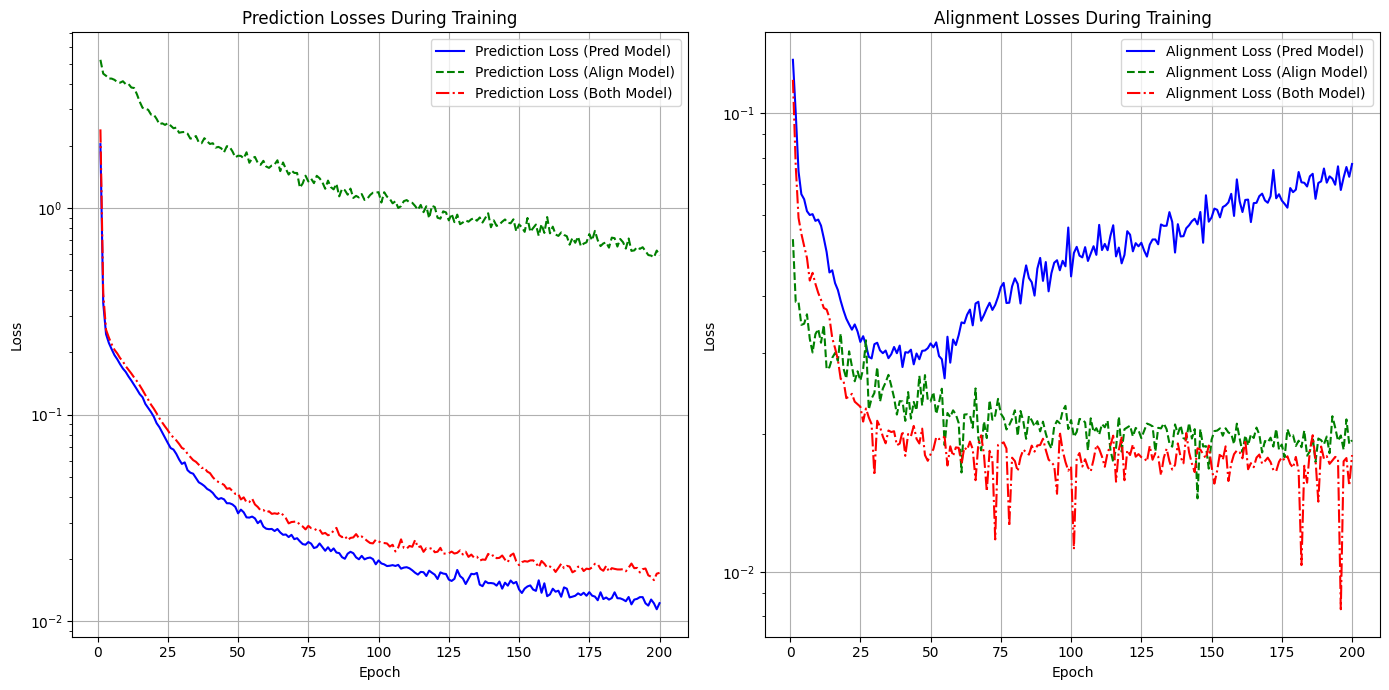

In [79]:
import matplotlib.pyplot as plt

def plot_training_results(num_epochs, prediction_losses_pred, alignment_losses_pred,
                          prediction_losses_align, alignment_losses_align,
                          prediction_losses_both, alignment_losses_both):
    epochs = range(1, num_epochs + 1)

    # Create a large figure to plot all comparisons
    plt.figure(figsize=(14, 7))

    # Subplot for prediction losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, prediction_losses_pred, label='Prediction Loss (Pred Model)', marker=None, linestyle='-', color='blue')
    plt.plot(epochs, prediction_losses_align, label='Prediction Loss (Align Model)', marker=None, linestyle='--', color='green')
    plt.plot(epochs, prediction_losses_both, label='Prediction Loss (Both Model)', marker=None, linestyle='-.', color='red')
    plt.title('Prediction Losses During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')

    plt.grid(True)

    # Subplot for alignment losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, alignment_losses_pred, label='Alignment Loss (Pred Model)', marker=None, linestyle='-', color='blue')
    plt.plot(epochs, alignment_losses_align, label='Alignment Loss (Align Model)', marker=None, linestyle='--', color='green')
    plt.plot(epochs, alignment_losses_both, label='Alignment Loss (Both Model)', marker=None, linestyle='-.', color='red')
    plt.title('Alignment Losses During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')

    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming the loss data is collected from the training function
plot_training_results(num_epochs,
                      prediction_losses_pred, alignment_losses_pred,
                      prediction_losses_align, alignment_losses_align,
                      prediction_losses_both, alignment_losses_both)


In [39]:
# Generate validation data
num_validation_rollouts = 1
validation_rollout_length = 400

validation_states_list, validation_actions_list, validation_jacobians_list, validation_next_states_list = [], [], [], []

for _ in range(num_validation_rollouts):
    states, actions, jacobians, next_states = rolloutBraxEnv(env, num_steps=validation_rollout_length)
    validation_states_list.append(states)
    validation_actions_list.append(actions)
    validation_jacobians_list.append(jacobians)
    validation_next_states_list.append(next_states)

validation_states_np = np.concatenate(validation_states_list, axis=0)
validation_actions_np = np.concatenate(validation_actions_list, axis=0)
validation_jacobians_np = np.concatenate(validation_jacobians_list, axis=0)
validation_next_states_np = np.concatenate(validation_next_states_list, axis=0)

validation_states_tensor = torch.from_numpy(validation_states_np).float().to(device)
validation_actions_tensor = torch.from_numpy(validation_actions_np).float().to(device)
validation_next_states_tensor = torch.from_numpy(validation_next_states_np).float().to(device)

# Evaluate models on validation data
with torch.no_grad():
    predictions_pred = model_pred(validation_states_tensor, validation_actions_tensor)
    predictions_align = model_align(validation_states_tensor, validation_actions_tensor)
    predictions_both = model_both(validation_states_tensor, validation_actions_tensor)

validation_loss_pred = nn.MSELoss()(predictions_pred, validation_next_states_tensor).item()
validation_loss_align = nn.MSELoss()(predictions_align, validation_next_states_tensor).item()
validation_loss_both = nn.MSELoss()(predictions_both, validation_next_states_tensor).item()

# Visualize results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(prediction_losses_pred, label='Prediction Loss Only')
plt.plot(prediction_losses_align, label='Alignment Loss Only')
plt.plot(prediction_losses_both, label='Prediction & Alignment Loss')
plt.title('Training Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['Pred Only', 'Align Only', 'Pred & Align'], [validation_loss_pred, validation_loss_align, validation_loss_both])
plt.title('Validation Prediction Loss')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("Script execution completed.")

Initial observation captured
Step 0: Action taken and next state observed
Step 0: Jacobian calculated
Step 1: Action taken and next state observed
Step 1: Jacobian calculated
Step 2: Action taken and next state observed
Step 2: Jacobian calculated
Step 3: Action taken and next state observed
Step 3: Jacobian calculated
Step 4: Action taken and next state observed
Step 4: Jacobian calculated
Step 5: Action taken and next state observed
Step 5: Jacobian calculated
Step 6: Action taken and next state observed
Step 6: Jacobian calculated
Step 7: Action taken and next state observed
Step 7: Jacobian calculated
Step 8: Action taken and next state observed
Step 8: Jacobian calculated
Step 9: Action taken and next state observed
Step 9: Jacobian calculated
Step 10: Action taken and next state observed
Step 10: Jacobian calculated
Step 11: Action taken and next state observed
Step 11: Jacobian calculated
Step 12: Action taken and next state observed
Step 12: Jacobian calculated
Step 13: Action 

KeyboardInterrupt: 

In [45]:
# Compute per-timestep prediction errors for models
def compute_timestep_errors(predictions, true_states):
    # Assuming predictions and true_states are tensors of shape [time, features]
    return torch.mean((predictions - true_states) ** 2, dim=1).detach().cpu().numpy()

# Evaluate models on validation data
with torch.no_grad():
    predictions_pred = model_pred(validation_states_tensor, validation_actions_tensor)
    predictions_align = model_align(validation_states_tensor, validation_actions_tensor)
    predictions_both = model_both(validation_states_tensor, validation_actions_tensor)

# Compute errors for each model
errors_pred = compute_timestep_errors(predictions_pred, validation_next_states_tensor)
errors_align = compute_timestep_errors(predictions_align, validation_next_states_tensor)
errors_both = compute_timestep_errors(predictions_both, validation_next_states_tensor)

# Visualize results
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(errors_pred, label='Prediction Model', marker='o')
plt.plot(errors_align, label='Alignment Model', marker='x')
plt.plot(errors_both, label='Both Model', marker='^')
plt.title('Per-Timestep Prediction Errors')
plt.xlabel('Timestep')
plt.ylabel('Mean Squared Error')
plt.yscale('log')

plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.bar(['Pred Only', 'Align Only', 'Pred & Align'],
        [np.mean(errors_pred), np.mean(errors_align), np.mean(errors_both)])
plt.title('Average Prediction Error Across All Timesteps')
plt.ylabel('Mean Squared Error')
plt.yscale('log')

plt.tight_layout()
plt.show()

print("Script execution completed.")

TypeError: unsupported operand type(s) for -: 'tuple' and 'Tensor'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results(prediction_losses_pred, alignment_losses_pred,
                          prediction_losses_align, alignment_losses_align,
                          prediction_losses_both, alignment_losses_both):
    epochs = range(1, len(prediction_losses_pred) + 1)

    # Calculate the derivative of the losses for additional insight
    d_pred_losses_pred = np.gradient(prediction_losses_pred)
    d_alignment_losses_pred = np.gradient(alignment_losses_pred)

    # Create a large figure to plot all comparisons
    plt.figure(figsize=(14, 14))  # Adjusted size for four plots

    # Plot prediction losses on a log scale
    plt.subplot(2, 2, 1)
    plt.semilogy(epochs, prediction_losses_pred, label='Prediction Loss (Pred Model)', marker='o')
    plt.semilogy(epochs, prediction_losses_align, label='Prediction Loss (Align Model)', marker='x')
    plt.semilogy(epochs, prediction_losses_both, label='Prediction Loss (Both Model)', marker='^')
    plt.title('Prediction Losses During Training (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.legend()
    plt.grid(True)

    # Plot alignment losses on a log scale
    plt.subplot(2, 2, 2)
    plt.semilogy(epochs, alignment_losses_pred, label='Alignment Loss (Pred Model)', marker='o')
    plt.semilogy(epochs, alignment_losses_align, label='Alignment Loss (Align Model)', marker='x')
    plt.semilogy(epochs, alignment_losses_both, label='Alignment Loss (Both Model)', marker='^')
    plt.title('Alignment Losses During Training (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.legend()
    plt.grid(True)

    # Additional subplot for the rate of change in prediction losses
    plt.subplot(2, 2, 3)
    plt.plot(epochs, d_pred_losses_pred, label='dPrediction Loss (Pred Model)', marker='o')
    plt.title('Rate of Change in Prediction Losses')
    plt.xlabel('Epoch')
    plt.ylabel('dLoss/dEpoch')
    plt.legend()
    plt.grid(True)

    # Additional subplot for the rate of change in alignment losses
    plt.subplot(2, 2, 4)
    plt.plot(epochs, d_alignment_losses_pred, label='dAlignment Loss (Pred Model)', marker='o')
    plt.title('Rate of Change in Alignment Losses')
    plt.xlabel('Epoch')
    plt.ylabel('dLoss/dEpoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming you have called your training functions and collected the losses
plot_training_results(prediction_losses_pred, alignment_losses_pred,
                      prediction_losses_align, alignment_losses_align,
                      prediction_losses_both, alignment_losses_both)


In [ ]:
import matplotlib.pyplot as plt

def plot_comparison_between_pred_both(prediction_losses_pred, prediction_losses_both, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 6))

    # Apply a small offset to the 'Both' model data
    offset = 0.005  # This offset is arbitrary; adjust based on your actual data scale
    adjusted_losses_both = [loss + offset for loss in prediction_losses_both]

    plt.plot(epochs, prediction_losses_pred, label='Prediction Only Model', color='blue', marker='o', linestyle='-', linewidth=2)
    plt.plot(epochs, adjusted_losses_both, label='Both Model (+offset)', color='red', marker='x', linestyle='--', linewidth=2)

    plt.title('Comparison of Prediction Losses: Pred Only vs. Both')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage, assuming you have the required data
plot_comparison_between_pred_both(prediction_losses_pred, prediction_losses_both, num_epochs)


In [ ]:
states.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3000, 18)

In [ ]:
# import torch
# import matplotlib.pyplot as plt

# def rollout_simulation(model, initial_state, actions, num_steps):
#     """
#     Simulate the environment by applying the same action sequence repetitively.

#     Args:
#         model (torch.nn.Module): The trained model to predict the next state.
#         initial_state (torch.Tensor): The initial state to start the simulation.
#         actions (torch.Tensor): The actions to apply at each step.
#         num_steps (int): Number of steps to simulate.

#     Returns:
#         list of torch.Tensor: The predicted states.
#     """
#     current_state = initial_state
#     predicted_states = [current_state]
#     for i in range(num_steps):
#         current_action = actions[i % len(actions)]  # Cycle through the action sequence
#         current_state = model(current_state.unsqueeze(0), current_action.unsqueeze(0)).squeeze(0)
#         predicted_states.append(current_state)
#     return predicted_states

# def compute_error(true_states, predicted_states):
#     """
#     Compute the mean squared error between the true states and the predicted states.

#     Args:
#         true_states (list of torch.Tensor): The true states of the system.
#         predicted_states (list of torch.Tensor): The predicted states by the model.

#     Returns:
#         list of float: The error at each step.
#     """
#     errors = [(true_state - pred_state).pow(2).mean().item() for true_state, pred_state in zip(true_states, predicted_states)]
#     return errors

# # Assuming initial_state and actions are already defined, and you have true_states for comparison
# num_steps = 50  # Number of steps to simulate
# initial_state = torch.from_numpy(states[0]).float().to(device)


# #actions_p = torch.from_numpy(actions[:50]).float().to(device)
# true_states = torch.from_numpy(states[:50]).float().to(device)
# actions_p = actions
# # Simulate the rollout for each model
# predicted_states_pred = rollout_simulation(model_pred, initial_state, actions_p, num_steps)
# predicted_states_align = rollout_simulation(model_align, initial_state, actions_p, num_steps)
# predicted_states_both = rollout_simulation(model_both, initial_state, actions_p, num_steps)

# # Assuming you have true states for comparison
# errors_pred = compute_error(true_states, predicted_states_pred)
# errors_align = compute_error(true_states, predicted_states_align)
# errors_both = compute_error(true_states, predicted_states_both)

# # Plot the results
# plt.figure(figsize=(10, 5))
# plt.plot(errors_pred, label='Prediction Model', marker='o')
# plt.plot(errors_align, label='Alignment Model', marker='x')
# plt.plot(errors_both, label='Both Model', marker='^')
# plt.title('Error Over Time for Each Model')
# plt.xlabel('Step')
# plt.ylabel('Mean Squared Error')
# plt.yscale('log')

# plt.legend()
# plt.grid(True)
# plt.show()


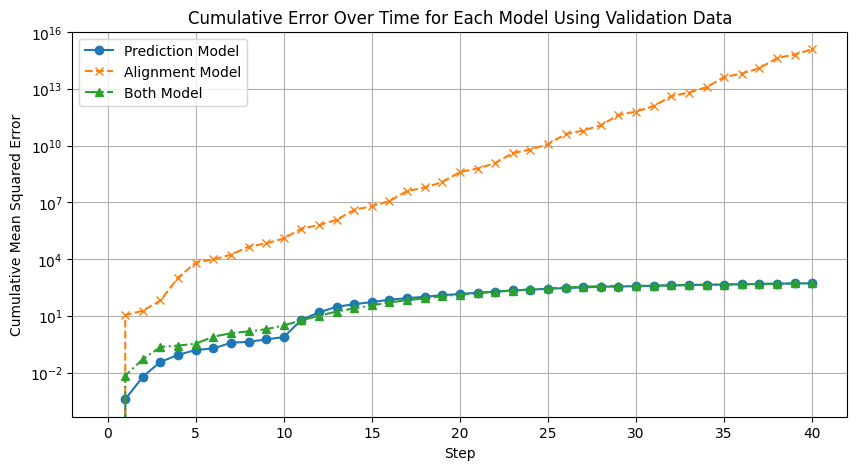

In [38]:
import torch
import matplotlib.pyplot as plt

def rollout_simulation(model, initial_state, actions, num_steps):
    current_state = initial_state
    predicted_states = [current_state]
    for i in range(num_steps):
        current_action = actions[i % len(actions)]  # Cycle through the action sequence
        current_state = model(current_state.unsqueeze(0), current_action.unsqueeze(0)).squeeze(0)
        predicted_states.append(current_state)
    return predicted_states

def compute_cumulative_error(true_states, predicted_states):
    """
    Compute the cumulative mean squared error between the true states and the predicted states over time.

    Args:
        true_states (list of torch.Tensor): The true states of the system.
        predicted_states (list of torch.Tensor): The predicted states by the model.

    Returns:
        list of float: The cumulative error at each step.
    """
    cumulative_error = []
    sum_error = 0
    for true_state, pred_state in zip(true_states, predicted_states):
        current_error = (true_state - pred_state).pow(2).mean().item()
        sum_error += current_error
        cumulative_error.append(sum_error)
    return cumulative_error

# Assuming initial_state, actions, and true_states are predefined torch.Tensors
# Assume num_validation_rollouts and validation_rollout_length are defined
num_steps = validation_rollout_length  # Use the number of steps as defined by the rollout length

# Use the first state in the validation set as the initial state for each simulation
initial_state = validation_states_tensor[0]

# Use all actions from the validation set (assuming the number of steps matches the actions length)
actions = validation_actions_tensor

# Simulate the rollout for each model
predicted_states_pred = rollout_simulation(model_pred, initial_state, actions, num_steps)
predicted_states_align = rollout_simulation(model_align, initial_state, actions, num_steps)
predicted_states_both = rollout_simulation(model_both, initial_state, actions, num_steps)

# Compute the cumulative error using the true states from the validation set
errors_pred = compute_cumulative_error(validation_states_tensor, predicted_states_pred)
errors_align = compute_cumulative_error(validation_states_tensor, predicted_states_align)
errors_both = compute_cumulative_error(validation_states_tensor, predicted_states_both)

# Plot the cumulative errors
plt.figure(figsize=(10, 5))
plt.plot(errors_pred, label='Prediction Model', marker='o', linestyle='-')
plt.plot(errors_align, label='Alignment Model', marker='x', linestyle='--')
plt.plot(errors_both, label='Both Model', marker='^', linestyle='-.')
plt.title('Cumulative Error Over Time for Each Model Using Validation Data')
plt.xlabel('Step')
plt.ylabel('Cumulative Mean Squared Error')
plt.yscale('log')  # Using logarithmic scale to better visualize differences over orders of magnitude

plt.legend()
plt.grid(True)
plt.show()

#Define Model


##VAE

In [ ]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)  # outputs mean and log variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu, log_var = x.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        return self.decode(z), mu, log_var

# # Example of using encode and decode
# # Assume `model` is an instance of VAE and `x` is some input tensor
# z, mu, log_var = model.encode(x)
# reconstructed_x = model.decode(z)



##MDNRNN

In [ ]:

class MDNRNN(nn.Module):
    def __init__(self, z_dim=32, hidden_dim=256, n_gaussians=5, action_dim=6):
        super(MDNRNN, self).__init__()
        input_dim = z_dim + hidden_dim + action_dim  # Assuming `z_dim + hidden_dim + action_dim`
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # Correcting the output dimension:
        output_dim = n_gaussians + 2 * n_gaussians * z_dim  # Mixtures + Means + Log Stds
        # self.fc = nn.Linear(hidden_dim, 3 * n_gaussians * z_dim)  # Use 3 * 5 = 15 for 5 mixtures
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, h):
        # inputs should be batched and contain [z, action, hidden_state]
        inputs = torch.cat([z, h], dim=-1)
        output, hidden = self.rnn(inputs)
        y = self.fc(output)
        return y, hidden

    def initial_state(self, batch_size):
        # Initial states for LSTM should be (h_0, c_0)
        return (torch.zeros(1, batch_size, 256), torch.zeros(1, batch_size, 256))  # Assuming one LSTM layer


##Controller

In [ ]:
class Controller(nn.Module):
    def __init__(self, z_dim=32, hidden_dim=256, action_dim=3):
        super(Controller, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.linear = nn.Linear(z_dim + hidden_dim, action_dim)

    def forward(self, z, h):
        # print(z.size())
        # print(h.size())
        z = z.unsqueeze(0)
        inputs = torch.cat([z, h], dim=1)
        return self.linear(inputs)



#Train

##Current

In [ ]:
!pip install dask[distributed]

In [ ]:
from dask.distributed import Client

# client = Client()  # Starts a local Dask client with automatically determined number of workers and threads


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
env.action_space.sample()

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import gym
import cma
from torchvision import transforms
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import dask
from dask.distributed import as_completed
import gym
import os


base_dir = "/content/drive/MyDrive/WorldModel"
run_id = "run_{}".format(np.random.randint(10000))  # Example of generating a random run ID
run_dir = os.path.join(base_dir, run_id)

# Create the directory if it does not exist
os.makedirs(run_dir, exist_ok=True)
print(f"Data will be saved in directory: {run_dir}")

# Check if GPU/CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming VAE, MDNRNN, and Controller classes have been defined as earlier
# Initialize the environment
# env = gym.make('CarRacing-v2')
# env = gym.make('HalfCheetah-v4')

# # Parameters
input_dim = 18  # Adjust this if the dimension of the observation space changes
latent_dim = 8

# # Model and optimizer
vae = VAE(input_dim, latent_dim).to(device)
# optimizer = Adam(model.parameters(), lr=1e-3)
# Initialize models and move them to the device
# vae = VAE(input_channels=1, feature_dim=17).to(device)
mdnrnn = MDNRNN(z_dim=8, hidden_dim=256, n_gaussians=5, action_dim=6).to(device)
# controller = Controller(z_dim=32, hidden_dim=256, action_dim=3).to(device)
controller = Controller(z_dim=8, hidden_dim=256, action_dim=6).to(device)



def mdnrnn_loss(output, target, n_gaussians=5, z_dim=8):
    # output is the result from the MDNRNN which contains mixture coefficients, means, and log standard deviations
    batch_size = target.size(0)

    pi, mu, log_sigma = torch.split(output, [n_gaussians, n_gaussians*z_dim, n_gaussians*z_dim], dim=1)

    # Softmax the mixture coefficients to ensure they sum to 1
    pi = F.softmax(pi, dim=1)
    # Exponentiate the log standard deviations to get the standard deviations
    sigma = torch.exp(log_sigma)

    # Reshape mu and sigma to align with the target for calculation
    mu = mu.view(batch_size, n_gaussians, z_dim)
    sigma = sigma.view(batch_size, n_gaussians, z_dim)

    # Target is duplicated across each mixture component for calculation
    target = target.unsqueeze(1).expand_as(mu)

    # Calculate the Gaussian probability densities
    exponent = -0.5 * ((target - mu) ** 2) / sigma ** 2
    norm_factor = torch.sqrt(2 * torch.pi * sigma ** 2)
    prob = torch.exp(exponent) / norm_factor

    # Sum over dimensions and multiply by the mixture coefficients
    prob = torch.sum(prob, dim=2)  # Sum over z_dim
    prob = pi * prob  # Apply mixing coefficients
    total_prob = torch.sum(prob, dim=1)  # Sum over n_gaussians

    # Calculate negative log likelihood
    nll = -torch.log(total_prob + 1e-8)  # Add a small number to avoid log(0)

    # Mean over batch
    return torch.mean(nll)

# Example usage inside your train function
# loss = mdnrnn_loss(outputs, next_z, n_gaussians=5, z_dim=32)


# Optimizers
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)
mdnrnn_optimizer = optim.Adam(mdnrnn.parameters(), lr=0.001)

# Transform for preprocessing the observations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])



def load_rollout_data(filename='/content/drive/MyDrive/WorldModel/rollout_data.pkl'):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Function to save model weights
def save_model_weights(model, filename):
    file_path = os.path.join(run_dir, filename)
    torch.save(model.state_dict(), file_path)
    print(f"Model weights saved to {file_path}")

def save_rollout_data(data, filename="rollout_data.pkl"):
    file_path = os.path.join(run_dir, filename)
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {file_path}")

def collect_single_rollout(env, max_steps=100):
    obs = env.reset()
    done = False
    data = []
    cur_steps = 0
    while not done and cur_steps < max_steps:
      print(f'[rollout collecting] {cur_steps}')
      action = env.action_space.sample()
      next_obs, reward, done, info = env.step(action)
      data.append((obs.numpy(), action, reward.numpy(), next_obs.numpy(), done.numpy()))
      obs = next_obs
      cur_steps += 1
    return data

def collect_data_dask(env, n_rollouts=100):
    # Lazy execution of rollouts
    lazy_results = [dask.delayed(collect_single_rollout)(env) for _ in range(n_rollouts)]
    futures = client.compute(lazy_results)  # Trigger parallel computation
    results = client.gather(futures)  # Collect results
    all_data = [item for sublist in results for item in sublist]  # Flatten list of lists
    save_rollout_data(all_data)  # Save collected data
    return all_data

def train_vae(data, epochs=100):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for obs, _, _, _, _ in data:
            obs = torch.tensor(obs).to(device).float()
            recon, mu, log_var = vae(obs)
            recon_loss = F.mse_loss(recon, obs)
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kl_div
            vae_optimizer.zero_grad()
            loss.backward()
            vae_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: Loss {total_loss / len(data)}")
        if epoch % 10 == 0 or epoch == epochs - 1:  # Save every 10 epochs and last epoch
            save_model_weights(vae, f"vae_epoch_{epoch}.pth")

def train_mdn_rnn(data, epochs=100):
    mdnrnn.train()
    for epoch in range(epochs):
        total_loss = 0
        for obs, action, _, next_obs, _ in data:
            obs = torch.tensor(obs).to(device).float()
            next_obs = torch.tensor(next_obs).to(device).float()
            with torch.no_grad():
                z = vae.encode(obs)[0].unsqueeze(0)
                next_z = vae.encode(next_obs)[0].unsqueeze(0)
            action = torch.tensor(action).float().unsqueeze(0).to(device)
            outputs, _ = mdnrnn(torch.cat([z, action], dim=1), torch.zeros(1, 256).to(device))

            loss = mdnrnn_loss(outputs, next_z)
            mdnrnn_optimizer.zero_grad()
            loss.backward()
            mdnrnn_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: MDN-RNN Loss {total_loss / len(data)}")
        if epoch % 10 == 0 or epoch == epochs - 1:  # Save every 10 epochs and last epoch
            save_model_weights(mdnrnn, f"mdnrnn_epoch_{epoch}.pth")

import time
tmm = time.time()
print("Collecting data...")
# data = collect_data(env, n_rollouts=5000)  # Collect some data
#client = Client()

# data is a list of tuples, where each tuple represents a single transition in the environment.
# Each tuple contains the following items:
#   - obs: numpy array representing the current observation (state) of the environment
#   - action: numpy array representing the action taken in the current state
#   - reward: numpy array (scalar) representing the reward received after taking the action
#   - next_obs: numpy array representing the next observation (state) after taking the action
#   - done: numpy array (scalar) indicating whether the episode has ended (True) or not (False)
#
# The shapes of the items in each tuple depend on the specific environment:
#   - obs: (observation_dim,)
#   - action: (action_dim,)
#   - reward: (1,)
#   - next_obs: (observation_dim,)
#   - done: (1,)
#
# For example, if the environment has an observation space of shape (6,) and an action space of shape (1,),
# the shapes of the items in each tuple would be:
#   - obs: (6,)
#   - action: (1,)
#   - reward: (1,)
#   - next_obs: (6,)
#   - done: (1,)
#
#data = collect_data_dask("HalfCheetah-v4", n_rollouts=100)
#client.close()
# data = load_rollout_data()


print("time to collect: " + str(time.time() - tmm))
#data = collect_single_rollout(env,max_steps=5000)
data = load_rollout_data(filename='/content/drive/MyDrive/WorldModel/run_7503/initial_data.pkl')
print(f'number of samples: {len(data)}')
#save_rollout_data(data, "initial_data.pkl")

print(data[0])

print(np.shape(data[0][0]))
print(np.shape(data[0][1]))
print(np.shape(data[0][2]))
print(np.shape(data[0][3]))

# Train VAE
print("Training VAE...")
#train_vae(data)
# Path to the saved weights
model_path = '/content/drive/MyDrive/WorldModel/run_7503/vae_epoch_20.pth'

# Load the model weights
if os.path.exists(model_path):
    vae.load_state_dict(torch.load(model_path, map_location=device))
    print("Model weights loaded successfully.")
else:
    print("Model path does not exist.")
print("Finished Training VAE...")

# Train MDN-RNN
print("Training MDN-RNN...")
train_mdn_rnn(data)
print("Finished Training MDN-RNN...")

def rollout(controller, device='cuda'):
    controller.to(device)
    obs = env.reset()
    h = torch.zeros(1, 256, device=device).float()
    done = False
    cumulative_reward = 0
    cur_step = 0  # Initialize the counter
    while not done and cur_step < 500:
        if cur_step % 250 == 0:
            print(f'[rollout training] {cur_step}, cumulative_reward = {cumulative_reward}')
        with torch.no_grad():
            obs = torch.tensor(obs).to(device).float()
            z = vae.encode(obs)[0].to(device).float()
            # h = h.to(device).float()
            # print(h)
            action_tensor = controller(z, h)
            a = action_tensor.squeeze(0).cpu().numpy()
        obs, reward, done, _ = env.step(a)
        cumulative_reward += reward

        o, (h,c) = mdnrnn.forward(torch.cat([z.unsqueeze(0), action_tensor], dim=1),h)
        cur_step += 1
    return cumulative_reward

def evaluate_controller(parameters):
    # Assert the number of parameters is as expected
    expected_num_params = ((controller.z_dim + controller.hidden_dim) * controller.action_dim) + controller.action_dim
    assert len(parameters) == expected_num_params, f"Parameter size mismatch, expected {expected_num_params}, got {len(parameters)}"

    parameters_tensor = torch.tensor(parameters, dtype=torch.float32, device=device)

    # Calculate the number of weight parameters
    weight_params_count = (controller.z_dim + controller.hidden_dim) * controller.action_dim

    # Reshape the weight parameters
    controller.linear.weight.data = parameters_tensor[:weight_params_count].view(controller.action_dim, controller.z_dim + controller.hidden_dim)

    # Remaining parameters are for the bias
    controller.linear.bias.data = parameters_tensor[weight_params_count:weight_params_count + controller.action_dim]

    return rollout(controller)


print("Evaluating controller...")
# Initialize the controller
# Calculate the total number of parameters needed
param_count = (controller.z_dim + controller.hidden_dim) * controller.action_dim + controller.action_dim
print(f"Calculated parameter count: {param_count}")

# Initialize parameters
params = np.random.randn(param_count)  # initial parameter guess
print(f"Initial parameters: {params}")

# Initialize CMA-ES with the initial parameters and a standard deviation of 0.5
es = cma.CMAEvolutionStrategy(params, 0.5)
print("CMA-ES initialized.")

# Run optimization
while not es.stop():
    print("CMA-ES iteration started.")

    # Ask for a new set of solutions
    solutions = es.ask()
    print(f"New solutions: {solutions}")

    # Evaluate fitness for each solution
    fitness = [evaluate_controller(s) for s in solutions]
    print(f"Fitness values: {fitness}")

    # Tell CMA-ES the fitness values
    es.tell(solutions, fitness)
    print("Fitness values provided to CMA-ES.")

    # Log progress
    es.logger.add()
    print("Progress logged.")

    # Print best fitness value so far
    print("Best fitness so far:", es.result.fbest)

# Load best parameters back into the controller
best_params = es.result.xbest
print(f"Best parameters found: {best_params}")

# Evaluate the controller with the best parameters
evaluate_controller(best_params)  # This sets the controller with the best parameters found
print("Controller evaluated with the best parameters.")
# Close the environment
env.close()


In [ ]:
save_rollout_data(data, "initial_data.pkl")


In [ ]:
env

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/WorldModel/vae_epoch_2.pth')  # Change filename accordingly
files.download("/content/drive/MyDrive/WorldModel/mdnrnn_epoch_20.pth")
files.download('/content/drive/MyDrive/WorldModel/rollout_data.csv')  # Change filename accordingly
